In [1]:
import polars as pl
import numpy as np
import os
import json
os.chdir(os.path.expanduser('~/vEcoli/notebooks/mia_notebooks/metal_count_data/'))
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats
from sklearn.metrics import r2_score

# Set the default style
sns.set(style="darkgrid")

# LB Media Data

## Ground truth data from Outten & O'Halloran, Science, 2001 (https://pubmed.ncbi.nlm.nih.gov/11397910/)

Media type: LB media

Bacterial species: I believe E. coli BW25113

Units used in calculations: Atoms/cell

QUESTIONS/ISSUES: need to confirm if this is the correct strain of E. coli


In [2]:
# load in the "ground truth" data that cyrus collected from Outten & O'Halloran, Science, 2001 (https://pubmed.ncbi.nlm.nih.gov/11397910/): 
GT_data = pd.read_csv("cofactor_ground_truth_data_from_cyrus_for_mia.csv")
GT_data

Condition  Below_LOD  Cell Element    Distance  ScaleDist  ScaleCounts  \
0    Minimal          0     1      MO  138.225817     354.00      9.08603   
1    Minimal          0     1      ZN  205.106947     354.00      9.08603   
2    Minimal          0     1      CU  149.815832     354.00      9.08603   
3    Minimal          1     1      NI  137.331179     354.00      9.08603   
4    Minimal          1     1      CO  103.448109     354.00      9.08603   
5    Minimal          0     1      FE  203.321486     354.00      9.08603   
6    Minimal          0     1      MN  135.088853     354.00      9.08603   
7    Minimal          0     1      CR  122.171244     354.00      9.08603   
8    Minimal          0     1       V  113.253635     354.00      9.08603   
9       Rich          0     1      MO  146.248788     353.14      9.30606   
10      Rich          0     1      ZN  207.787945     353.14      9.30606   
11      Rich          0     1      CU  181.919225     353.14      9.30606   
12      Rich          1     1      NI  125.738288     353.14      9.30606   
13      Rich          1     1      CO   91.851373     353.14      9.30606   
14      Rich          0     1      FE  214.914378     353.14      9.30606   
15      Rich          0     1      MN  171.220416     353.14      9.30606   
16      Rich          0     1      CR  126.630048     353.14      9.30606   
17      Rich          0     1       V   82.042003     353.14      9.30606   

            Error  Log_concentration  Concentration_(M)     Atoms/cell  
0     1000.000000          -5.485784       3.267501e-06    3983.324414  
1    55212.922173          -3.785417       1.639017e-04  199808.236064  
2     1000.000000          -5.191123       6.439870e-06    7850.676467  
3     1000.000000          -5.508529       3.100778e-06    3780.077086  
4     1000.000000          -6.369963       4.266155e-07     520.075813  
5    24669.603524          -3.830810       1.476353e-04  179978.374255  
6     1000.000000          -5.565538       2.719333e-06    3315.067378  
7     1000.000000          -5.893951       1.276582e-06    1556.247155  
8     1000.000000          -6.120670       7.574077e-07     923.335846  
9     1000.000000          -5.272756       5.336351e-06   10797.032626  
10   88105.726872          -3.704391       1.975192e-04  399640.415582  
11   29368.575624          -4.363672       4.328410e-05   87576.668290  
12    1000.000000          -5.795479       1.601479e-06    3240.269333  
13    1000.000000          -6.659109       2.192256e-07     443.558908  
14  128046.989721          -3.522769       3.000759e-04  607143.184501  
15   12922.173275          -4.636338       2.310268e-05   46743.626407  
16    1000.000000          -5.772752       1.687517e-06    3414.351358  
17    1000.000000          -6.909107       1.232802e-07     249.432594

In [3]:
# LB media data from GT data: 
GT_lb_data = GT_data[9:]
GT_lb_df = pl.DataFrame(GT_lb_data[["Element","Atoms/cell"]])
GT_lb_df = GT_lb_df.with_columns(pl.col("Atoms/cell").log10().alias("$\t{E. coli}$ BW25113 (Outten & O'Halloran, 2001)"))

# replace the element names with the column names for merging later:
col_names = ["Mo", "Zn", "Cu", "Ni", "Co", "Fe", "Mn", "Cr", "V"]
GT_lb_df0 = GT_lb_df.with_columns(pl.col("Element").replace(pl.col("Element"), col_names).alias("Element"))
GT_lb_df = pl.DataFrame(GT_lb_df0[["Element", "$\t{E. coli}$ BW25113 (Outten & O'Halloran, 2001)"]])
GT_lb_df0

shape: (9, 3)
┌─────────┬───────────────┬────────────────────────────────┐
│ Element ┆ Atoms/cell    ┆ $	{E. coli}$ BW25113 (Outten &… │
│ ---     ┆ ---           ┆ ---                            │
│ str     ┆ f64           ┆ f64                            │
╞═════════╪═══════════════╪════════════════════════════════╡
│ Mo      ┆ 10797.032626  ┆ 4.033304                       │
│ Zn      ┆ 399640.415582 ┆ 5.601669                       │
│ Cu      ┆ 87576.66829   ┆ 4.942388                       │
│ Ni      ┆ 3240.269333   ┆ 3.510581                       │
│ Co      ┆ 443.558908    ┆ 2.646951                       │
│ Fe      ┆ 607143.184501 ┆ 5.783291                       │
│ Mn      ┆ 46743.626407  ┆ 4.669722                       │
│ Cr      ┆ 3414.351358   ┆ 3.533308                       │
│ V       ┆ 249.432594    ┆ 2.396953                       │
└─────────┴───────────────┴────────────────────────────────┘

## Covert Lab Simulation Data 

Media type: rich media (pressuably LB)

Bacterial Species: E. coli MG1655

Units used in calculations: Bulk atoms/cell (atoms per cell)

QUESTIONS/ISSUES:
- did he accidently send me the wrong data for this?

In [4]:
# load in the Covert lab simulation data (manually put in since there is so few):
sim_elements = ["Zn", "Fe", "Ni", "Cu", "Mn", "Co", "Mo"]
sim_values = [357248.6491, 438271.9937, 1342.232233, 19116.19354, 70569.16543, 1191.478964, 3623.204996]

# create a data frame:
sim_df = pd.DataFrame({"Element": sim_elements, "atoms/cell": sim_values})
sim_df = pl.DataFrame(sim_df)
sim_df0 = sim_df.with_columns(pl.col("atoms/cell").log10().alias("$\t{E. coli}$ MG1655 (Covert Lab Simulation Data)"))
sim_df = pl.DataFrame(sim_df0[["Element", "$\t{E. coli}$ MG1655 (Covert Lab Simulation Data)"]])
sim_df0

shape: (7, 3)
┌─────────┬─────────────┬────────────────────────────────┐
│ Element ┆ atoms/cell  ┆ $	{E. coli}$ MG1655 (Covert La… │
│ ---     ┆ ---         ┆ ---                            │
│ str     ┆ f64         ┆ f64                            │
╞═════════╪═════════════╪════════════════════════════════╡
│ Zn      ┆ 357248.6491 ┆ 5.552971                       │
│ Fe      ┆ 438271.9937 ┆ 5.641744                       │
│ Ni      ┆ 1342.232233 ┆ 3.127828                       │
│ Cu      ┆ 19116.19354 ┆ 4.281401                       │
│ Mn      ┆ 70569.16543 ┆ 4.848615                       │
│ Co      ┆ 1191.478964 ┆ 3.076086                       │
│ Mo      ┆ 3623.204996 ┆ 3.559093                       │
└─────────┴─────────────┴────────────────────────────────┘

## LB media data from Huynh et al., 2022 fig 1c and 1d (https://journals.asm.org/doi/full/10.1128/spectrum.01006-21): 

Media type: LB media

Bacterial species: E. coli K-12 BW25113

Units used in calculations: Atoms/CFU

QUESTIONS/ISSUES: 
- double check that I did my web plot analyzer stuff right when I do it for the minimal media conditions

In [5]:
# load in LB media data from Huynh et al., 2022 fig 1c and d (https://journals.asm.org/doi/full/10.1128/spectrum.01006-21): 
Huynh_2022 = pd.read_excel("Huynh_2022_F1CD_data.xlsx")

# convert data frames to polars data frames and rename the columns to be more descriptive: 
Huynh_2022 = pl.DataFrame(Huynh_2022[["Element","log10 LB (atoms/CFU)"]])
H_2022 = Huynh_2022.with_columns(pl.col("log10 LB (atoms/CFU)").alias("$\t{E. coli}$ K-12 BW25113 (Huynh et al., 2022)"))
H_2022

shape: (8, 3)
┌─────────┬──────────────────────┬────────────────────────────────┐
│ Element ┆ log10 LB (atoms/CFU) ┆ $	{E. coli}$ K-12 BW25113 (Huy… │
│ ---     ┆ ---                  ┆ ---                            │
│ str     ┆ f64                  ┆ f64                            │
╞═════════╪══════════════════════╪════════════════════════════════╡
│ Mn      ┆ 3.5727               ┆ 3.5727                         │
│ Fe      ┆ 5.79822              ┆ 5.79822                        │
│ Cu      ┆ 4.596439             ┆ 4.596439                       │
│ Zn      ┆ 4.534125             ┆ 4.534125                       │
│ V       ┆ 2.699801             ┆ 2.699801                       │
│ Cr      ┆ 4.230616             ┆ 4.230616                       │
│ Co      ┆ 1.976143             ┆ 1.976143                       │
│ Ni      ┆ 3.38171              ┆ 3.38171                        │
└─────────┴──────────────────────┴────────────────────────────────┘

## LB media data from Budhraja, et al., 2019 Fig 1 (https://academic.oup.com/metallomics/article/11/5/925/5962190#supplementary-data):

Media type: LB media

Bacterial species: E. coli strain BW25113 (derived from K-12 lineage) (confirmed with author: K12 BW25113)

Units used in calculations: Atoms/cell

QUESTIONS/ISSUES: 
- not entirely sure about what strain is used in the specific graph here, but pretty sure it is BW25113? (the WT in the paper) 

In [6]:
# data from Budhraja, et al., 2019 Fig 1 (https://academic.oup.com/metallomics/article/11/5/925/5962190#supplementary-data): 
LBM_F1_2019 = pd.read_excel("Budhraja_2019_F1_data.xlsx")
LBM_F1_2019_df = pl.DataFrame(LBM_F1_2019[["metal","raise to ten"]])

# add the log of the metal ions per cell to the data frame:
LBM_F1_2019_df = LBM_F1_2019_df.with_columns(pl.col("raise to ten").log10().alias("LBM_Budhraja_log_APC"))
B_2019 = LBM_F1_2019_df.rename({"metal": "Element", "raise to ten": "atoms/cell", "LBM_Budhraja_log_APC": "$\t{E. coli}$ K-12 BW25113 (Budhraja et al., 2019)"});
B_2019

shape: (4, 3)
┌─────────┬──────────────┬────────────────────────────────┐
│ Element ┆ atoms/cell   ┆ $	{E. coli}$ K-12 BW25113 (Bud… │
│ ---     ┆ ---          ┆ ---                            │
│ str     ┆ f64          ┆ f64                            │
╞═════════╪══════════════╪════════════════════════════════╡
│ Mo      ┆ 14677.992676 ┆ 4.166667                       │
│ Ni      ┆ 14065.272421 ┆ 4.148148                       │
│ Co      ┆ 3300.034791  ┆ 3.518519                       │
│ Fe      ┆ 2.0354e6     ┆ 6.308642                       │
└─────────┴──────────────┴────────────────────────────────┘

## LB media data from Umemura et al., 2017, table 11.2 (https://link.springer.com/chapter/10.1007/978-4-431-56463-8_11)

Media type: LB media

Bacterial species: E. coli MG1655

Units used in calculations: Atoms/cell

QUESTIONS/ISSUES: 

In [7]:
# data from Umemura et al., 2017, table 11.2 (https://link.springer.com/chapter/10.1007/978-4-431-56463-8_11): 
LBM_T112_2017 = pd.read_excel("Umemura_2017_T112_data.xlsx")

# transform into a polars data frame and rename the columns:
LBM_T112_2017_df = pl.DataFrame(LBM_T112_2017[["Symbol","E. coli\xa0MG1655 in LB"]])
LBM_T112_2017_df = LBM_T112_2017_df.with_columns(pl.col("E. coli\xa0MG1655 in LB").log10().alias("$\t{E. coli}$ MG1655 (Umemura et al., 2017)"))
U_2017 = LBM_T112_2017_df.rename({"Symbol": "Element", "E. coli\xa0MG1655 in LB": "atoms/cell"})
U_2017

shape: (48, 3)
┌─────────┬────────────┬────────────────────────────────┐
│ Element ┆ atoms/cell ┆ $	{E. coli}$ MG1655 (Umemura e… │
│ ---     ┆ ---        ┆ ---                            │
│ str     ┆ f64        ┆ f64                            │
╞═════════╪════════════╪════════════════════════════════╡
│ Mg      ┆ 7.5e7      ┆ 7.875061                       │
│ P       ┆ 4.2e8      ┆ 8.623249                       │
│ S       ┆ 1.7e8      ┆ 8.230449                       │
│ K       ┆ 2.6e8      ┆ 8.414973                       │
│ Ca      ┆ 6.2e6      ┆ 6.792392                       │
│ …       ┆ …          ┆ …                              │
│ Au      ┆ 0.25       ┆ -0.60206                       │
│ Tl      ┆ 45.0       ┆ 1.653213                       │
│ Pb      ┆ 60.0       ┆ 1.778151                       │
│ Th      ┆ 26.0       ┆ 1.414973                       │
│ U       ┆ 12.0       ┆ 1.079181                       │
└─────────┴────────────┴────────────────────────────────┘

## LB media data from Nies & Herzberg, 2012: https://onlinelibrary.wiley.com/doi/full/10.1111/mmi.12123 / Kristen et al., 2011: https://journals.asm.org/doi/full/10.1128/jb.05293-11

Media type: LB media

Bacterial species: E. coli W3110 

Units used in calculations: Atoms/cell

QUESTIONS/ISSUES: 

In [8]:
# LB media data from Nies et al., 2012: https://onlinelibrary.wiley.com/doi/full/10.1111/mmi.12123
Nies_2012 = pd.read_excel("Nies_2012_T1_data.xlsx")
Nies_2012 = pl.DataFrame(Nies_2012[["Element", "Atoms/cell"]])
N_2012 = Nies_2012.with_columns(pl.col("Atoms/cell").log10().alias("$\t{E. coli}$ W3110 (Nies & Herzberg, 2012)"))
N_2012

shape: (9, 3)
┌─────────┬────────────┬────────────────────────────────┐
│ Element ┆ Atoms/cell ┆ $	{E. coli}$ W3110 (Nies & Her… │
│ ---     ┆ ---        ┆ ---                            │
│ str     ┆ f64        ┆ f64                            │
╞═════════╪════════════╪════════════════════════════════╡
│ Mg      ┆ 1.27e7     ┆ 7.103804                       │
│ Ca      ┆ 2.0500e6   ┆ 6.311754                       │
│ Fe      ┆ 290000.0   ┆ 5.462398                       │
│ Co      ┆ 4500.0     ┆ 3.653213                       │
│ Ni      ┆ 9700.0     ┆ 3.986772                       │
│ Zn      ┆ 114000.0   ┆ 5.056905                       │
│ Mn      ┆ 11700.0    ┆ 4.068186                       │
│ Mo      ┆ 3450.0     ┆ 3.537819                       │
│ Cu      ┆ 169000.0   ┆ 5.227887                       │
└─────────┴────────────┴────────────────────────────────┘

## Saenkham-Huntsinger et al., 2024 (https://journals.asm.org/doi/full/10.1128/mbio.03522-23#F4):

Media type: LB media

Bacterial species: uropathogenic E. coli strain CFT073 (UPEC)

Units used in calculations: pg/10^6 CFU

QUESTIONS/ISSUES: 
- Did I do my conversion right? 

In [9]:
# LB media from Saenkham-Huntsinger et al., 2024 (https://journals.asm.org/doi/full/10.1128/mbio.03522-23):
SH_F2A_2024 = pd.read_excel("Saenkham_2024_F2a_data.xlsx")
SH_F2A_2024 = pl.DataFrame(SH_F2A_2024)

# convert units to atoms/CFU:
# pg to g: 1 pg = 10^-12 g
SH_LBM_2024 = pl.DataFrame(SH_F2A_2024[["Element", "CFT073/pGEN (pg/10^6 CFU)"]])
SH_LBM_2024 = SH_LBM_2024.with_columns((pl.col("CFT073/pGEN (pg/10^6 CFU)") * 10**(-12)).alias("CFT073/pGEN (g/10^6 CFU)"))

# g/10^6 CFU to g/CFU:
SH_LBM_2024 = SH_LBM_2024.with_columns((pl.col("CFT073/pGEN (g/10^6 CFU)") / 10**6).alias("CFT073/pGEN (g/CFU)"))

# conversion numbers (all masses are from https://ptable.com/?lang=en#Properties):
mm_Cu = 63.546  # g/mol
mm_Fe = 55.845  # g/mol
mm_Mn = 54.938  # g/mol
mm_Zn = 65.380  # g/mol
Avogadro = 6.022 * 10**23  # atoms/mol

# g to atoms:
Cu_value = SH_LBM_2024.filter(pl.col("Element") == "Cu").select("CFT073/pGEN (g/CFU)").item()
Cu_value = (Cu_value / mm_Cu) * Avogadro
Fe_value = SH_LBM_2024.filter(pl.col("Element") == "Fe").select("CFT073/pGEN (g/CFU)").item()
Fe_value = (Fe_value / mm_Fe) * Avogadro
Mn_value = SH_LBM_2024.filter(pl.col("Element") == "Mn").select("CFT073/pGEN (g/CFU)").item()
Mn_value = (Mn_value / mm_Mn) * Avogadro
Zn_value = SH_LBM_2024.filter(pl.col("Element") == "Zn").select("CFT073/pGEN (g/CFU)").item()
Zn_value = (Zn_value / mm_Zn) * Avogadro

# create new data frame: 
values = [Cu_value, Fe_value, Mn_value, Zn_value]
SH_LBM_2024 = SH_LBM_2024.with_columns([pl.Series("CFT073/pGEN (atoms/CFU)", values)])
SH_2024 = pl.DataFrame(SH_LBM_2024[["Element", "CFT073/pGEN (atoms/CFU)"]])
SH_2024 = SH_2024.with_columns(pl.col("CFT073/pGEN (atoms/CFU)").log10().alias("uropathogenic $\t{E. coli}$ CFT073 (Saenkham-Huntsinger, et al., 2024)"))
SH_2024

shape: (4, 3)
┌─────────┬─────────────────────────┬────────────────────────────────┐
│ Element ┆ CFT073/pGEN (atoms/CFU) ┆ uropathogenic $	{E. coli}$ CFT… │
│ ---     ┆ ---                     ┆ ---                            │
│ str     ┆ f64                     ┆ f64                            │
╞═════════╪═════════════════════════╪════════════════════════════════╡
│ Cu      ┆ 1.0867e6                ┆ 6.036124                       │
│ Fe      ┆ 8.8559e6                ┆ 6.947232                       │
│ Mn      ┆ 241151.843897           ┆ 5.382291                       │
│ Zn      ┆ 7.1844e6                ┆ 6.85639                        │
└─────────┴─────────────────────────┴────────────────────────────────┘

## Casanova-Hampton et al., 2021: https://academic.oup.com/metallomics/article/13/9/mfab052/6355450

Media type: LB media

Bacterial species: E. coli BW25113 (derived from K-12 lineage)

Units used in calculations: ng/mg

QUESTIONS/ISSUES:
- need to confirm if it was right to multiply by wet weight based on the paper?

In [10]:
# load in the data from Casanova-Hampton et al., 2021: https://academic.oup.com/metallomics/article/13/9/mfab052/6355450
CH_F7_2021 = pd.read_excel("CasanovaHampton_2021_F4_data.xlsx")

# convert units to atoms/cells:
# ng/mg to g/g: 1 ng/mg = 10^-6 g/g 
CH_F7_2021 = pl.DataFrame(CH_F7_2021[["Element", "ng/mg"]]) 
CH_F7_2021 = CH_F7_2021.with_columns((pl.col("ng/mg") * 10**(-6)).alias("g/g")) #  g element / g cell
# I will eventually convert to individual element masses, but all need to be multiplied by Avogadro's number
CH_F7_2021 = CH_F7_2021.with_columns((pl.col("g/g") * Avogadro).alias("atoms*g-E/mol*g-cell"))

# conversion numbers (all masses are from https://ptable.com/?lang=en#Properties):
mm_Cu = 63.546  # g/mol
mm_Fe = 55.845  # g/mol
mm_Mn = 54.938  # g/mol
mm_Zn = 65.380  # g/mol
Avogadro = 6.022 * 10**23  # atoms/mol
wet_cell_mass = 1 * 10**(-12)  # g-cell / cell (wet weight of an E. coli cell according to https://ecmdb.ca/e_coli_stats)

# TODO: I am assuming this needs to be multiplied by the wet weight in order to get the atoms/cell, check with cyrus if he agrees
# convert individual element masses to atoms/cell:
Cu_value = CH_F7_2021.filter(pl.col("Element") == "Cu").select("atoms*g-E/mol*g-cell").item()
Cu_value = (Cu_value / mm_Cu)  * wet_cell_mass
Fe_value = CH_F7_2021.filter(pl.col("Element") == "Fe").select("atoms*g-E/mol*g-cell").item()
Fe_value = (Fe_value / mm_Fe) * wet_cell_mass
Zn_value = CH_F7_2021.filter(pl.col("Element") == "Zn").select("atoms*g-E/mol*g-cell").item()
Zn_value = (Zn_value / mm_Zn) * wet_cell_mass
Mn_value = CH_F7_2021.filter(pl.col("Element") == "Mn").select("atoms*g-E/mol*g-cell").item()
Mn_value = (Mn_value / mm_Mn) * wet_cell_mass
CH_values = [Cu_value, Fe_value, Zn_value, Mn_value]

# create new data frame: 
CH_F7_2021 = CH_F7_2021.with_columns([pl.Series("atoms/cell", CH_values)]) 
CH_2021 = pl.DataFrame(CH_F7_2021[["Element", "atoms/cell"]])
CH_2021 = CH_2021.with_columns(pl.col("atoms/cell").log10().alias("$\t{E. coli}$ K-12 BW25113 (Casanova-Hampton, et al., 2021)"))
CH_2021

shape: (4, 3)
┌─────────┬───────────────┬────────────────────────────────┐
│ Element ┆ atoms/cell    ┆ $	{E. coli}$ K-12 BW25113 (Cas… │
│ ---     ┆ ---           ┆ ---                            │
│ str     ┆ f64           ┆ f64                            │
╞═════════╪═══════════════╪════════════════════════════════╡
│ Cu      ┆ 10233.056896  ┆ 4.010005                       │
│ Fe      ┆ 357683.554061 ┆ 5.553499                       │
│ Zn      ┆ 76520.224957  ┆ 4.883776                       │
│ Mn      ┆ 8830.833623   ┆ 3.946002                       │
└─────────┴───────────────┴────────────────────────────────┘

## D'Souz & Holz, 1999: https://pubs.acs.org/doi/full/10.1021/bi990872h

Media type: LB media

Bacterial species: E. coli BL21(DE3) (pMetAAP)

Units used in calculations: cellular metal ion concentration without MetAP expression (ppm)

QUESTIONS/ISSUES: 

In [11]:
# load in the data from D'Souz & Holz, 1999: https://pubs.acs.org/doi/full/10.1021/bi990872h
DSouz_T1_1999 = pd.read_excel("DSouz_1999_T1_data.xlsx")

# Filter out data that will not be needed in the final data frame: 
DSouz_T1_1999 = pl.DataFrame(DSouz_T1_1999[["Element", "cellular metal ion concentration without MetAP expression (ppm)a"]])
DH_T1_1999 = DSouz_T1_1999.rename({"cellular\u2009metal\u2009ion concentration\u2009without MetAP\u2009expression (ppm)a": "CMIC (ppm)"})
overlap_element_names = ["Fe", "Mn", "Zn", "Cu", "Co", "Ni", "Mo", "V", "Cr"] # do this first so that I do not have to convert things that won't be included in the final data frame
DH_T1_1999 = DH_T1_1999.select(["Element", "CMIC (ppm)"]).filter(pl.col("Element").is_in(overlap_element_names))

In [12]:
# Unit conversion
#TODO: ask cyrus if I should just throw out the Co data?
# convert ppm to g/L:
DH_T1_1999 = DH_T1_1999.with_columns((pl.col("CMIC (ppm)") * .01).alias("CMIC (g/L)")) # g/L = 10^-3 ppm

# conversion numbers (all molar masses are from https://ptable.com/?lang=en#Properties):
mm_V = 50.942 # g/mol
mm_Cr = 51.996 # g/mol
mm_Mo = 95.95 # g/mol
mm_Ni = 58.693 # g/mol
mm_Co = 58.933 # g/mol
mm_Cu = 63.546  # g/mol
mm_Fe = 55.845  # g/mol
mm_Mn = 54.938  # g/mol
mm_Zn = 65.380  # g/mol
Avogadro = 6.022 * 10**23  # atoms/mol

# convert from g/L to atoms/L: 
V_value = DH_T1_1999.filter(pl.col("Element") == "V").select("CMIC (g/L)").item(); V_value = (V_value / mm_V) * Avogadro
Cr_value = DH_T1_1999.filter(pl.col("Element") == "Cr").select("CMIC (g/L)").item(); Cr_value = (Cr_value / mm_Cr) * Avogadro
Ni_value = DH_T1_1999.filter(pl.col("Element") == "Ni").select("CMIC (g/L)").item(); Ni_value = (Ni_value / mm_Ni) * Avogadro
Co_value = DH_T1_1999.filter(pl.col("Element") == "Co").select("CMIC (g/L)").item(); Co_value = (Co_value / mm_Co) * Avogadro
Cu_value = DH_T1_1999.filter(pl.col("Element") == "Cu").select("CMIC (g/L)").item(); Cu_value = (Cu_value / mm_Cu) * Avogadro
Fe_value = DH_T1_1999.filter(pl.col("Element") == "Fe").select("CMIC (g/L)").item(); Fe_value = (Fe_value / mm_Fe) * Avogadro
Mn_value = DH_T1_1999.filter(pl.col("Element") == "Mn").select("CMIC (g/L)").item(); Mn_value = (Mn_value / mm_Mn) * Avogadro
Zn_value = DH_T1_1999.filter(pl.col("Element") == "Zn").select("CMIC (g/L)").item(); Zn_value = (Zn_value / mm_Zn) * Avogadro
DH_values = [Co_value, Cr_value, Cu_value, Fe_value, Mn_value, Ni_value, V_value, Zn_value]

# create new data frame:
DH_T1_1999 = DH_T1_1999.with_columns([pl.Series("CMIC (atoms/L)", DH_values)])

# convert from atoms/L to atoms/cell: 
cell_volume = 1e-15  # L (average volume of a E. coli cell according to https://ecmdb.ca/e_coli_stats)
DH_T1_1999 = DH_T1_1999.with_columns((pl.col("CMIC (atoms/L)") * cell_volume).alias("CMIC (atoms/cell)"))
DH_T1_1999 = DH_T1_1999.with_columns(pl.col("CMIC (atoms/cell)").log10().alias("$\t{E. coli}$ BL21(DE3) (D'Souz & Holz, 1999)"))
DH_1999 = DH_T1_1999.select(["Element", "$\t{E. coli}$ BL21(DE3) (D'Souz & Holz, 1999)"])
# todo is it ok that I do this:
DH_1999[0, 1] = 0.0 # get rid of the negative infinity
DH_T1_1999

shape: (8, 6)
┌─────────┬────────────┬────────────┬────────────────┬───────────────────┬─────────────────────────┐
│ Element ┆ CMIC (ppm) ┆ CMIC (g/L) ┆ CMIC (atoms/L) ┆ CMIC (atoms/cell) ┆ $	{E. coli}$ BL21(DE3)   │
│ ---     ┆ ---        ┆ ---        ┆ ---            ┆ ---               ┆ (D'Souz…                │
│ str     ┆ f64        ┆ f64        ┆ f64            ┆ f64               ┆ ---                     │
│         ┆            ┆            ┆                ┆                   ┆ f64                     │
╞═════════╪════════════╪════════════╪════════════════╪═══════════════════╪═════════════════════════╡
│ Co      ┆ 0.0        ┆ 0.0        ┆ 0.0            ┆ 0.0               ┆ -inf                    │
│ Cr      ┆ 0.22       ┆ 0.0022     ┆ 2.5480e19      ┆ 25479.652281      ┆ 4.406193                │
│ Cu      ┆ 0.15       ┆ 0.0015     ┆ 1.4215e19      ┆ 14214.899443      ┆ 4.152744                │
│ Fe      ┆ 0.42       ┆ 0.0042     ┆ 4.5290e19      ┆ 45290.357239      ┆ 4.656006                │
│ Mn      ┆ 0.09       ┆ 0.0009     ┆ 9.8653e18      ┆ 9865.302705       ┆ 3.99411                 │
│ Ni      ┆ 0.03       ┆ 0.0003     ┆ 3.0781e18      ┆ 3078.050193       ┆ 3.488276                │
│ V       ┆ 0.03       ┆ 0.0003     ┆ 3.5464e18      ┆ 3546.386086       ┆ 3.549786                │
│ Zn      ┆ 0.58       ┆ 0.0058     ┆ 5.3422e19      ┆ 53422.45335       ┆ 4.727724                │
└─────────┴────────────┴────────────┴────────────────┴───────────────────┴─────────────────────────┘

## Larson, et al., 2023: https://www.mdpi.com/2076-2607/11/2/382 

Media type: LB media

Bacterial species: E. coli K12 and E. coli AW3110

Units used in calculations: ppb

QUESTIONS/ISSUES: 
- do I do my conversion correctly?

In [13]:
# Cyrus was provided with the data directly from the authors:  
Larson_data_2023 = pd.read_excel("Larson_2023_data_from_cyrus.xlsx")
Larson_data_2023 = pl.DataFrame(Larson_data_2023[["Element", "K12_control_pool_ppb", "AW3110_control_pool_ppb"]])
# convert from ppb to g/L: 
Larson_F4_E1_2023 = Larson_data_2023.with_columns((pl.col("K12_control_pool_ppb") * 10**(-6)).alias("K-12 (g/L)")) # g/L = 10^-6 ppb
Larson_F4_E2_2023 = Larson_data_2023.with_columns((pl.col("AW3110_control_pool_ppb") * 10**(-6)).alias("AW3110 (g/L)"))

# conversion numbers (all molar masses are from https://ptable.com/?lang=en#Properties):
mm_Cu = 63.546  # g/mol
mm_Fe = 55.845  # g/mol
mm_Zn = 65.380  # g/mol
Avogadro = 6.022 * 10**23  # atoms/mol

# convert from g/L to atoms/L:
Cu_value = Larson_F4_E1_2023.filter(pl.col("Element") == "Cu").select("K-12 (g/L)").item(); Cu_value = (Cu_value / mm_Cu) * Avogadro
Fe_value = Larson_F4_E1_2023.filter(pl.col("Element") == "Fe").select("K-12 (g/L)").item(); Fe_value = (Fe_value / mm_Fe) * Avogadro
Zn_value = Larson_F4_E1_2023.filter(pl.col("Element") == "Zn").select("K-12 (g/L)").item(); Zn_value = (Zn_value / mm_Zn) * Avogadro
Larson_F4_E1_values = [Fe_value, Cu_value, Zn_value]

Cu_value = Larson_F4_E2_2023.filter(pl.col("Element") == "Cu").select("AW3110 (g/L)").item(); Cu_value = (Cu_value / mm_Cu) * Avogadro
Fe_value = Larson_F4_E2_2023.filter(pl.col("Element") == "Fe").select("AW3110 (g/L)").item(); Fe_value = (Fe_value / mm_Fe) * Avogadro
Zn_value = Larson_F4_E2_2023.filter(pl.col("Element") == "Zn").select("AW3110 (g/L)").item(); Zn_value = (Zn_value / mm_Zn) * Avogadro
Larson_F4_E2_values = [Fe_value, Cu_value, Zn_value]

Larson_F4_E1_2023 = Larson_F4_E1_2023.with_columns([pl.Series("K-12 (atoms/L)", Larson_F4_E1_values)])
Larson_F4_E2_2023 = Larson_F4_E2_2023.with_columns([pl.Series("AW3110 (atoms/L)", Larson_F4_E2_values)])

# convert from atoms/L to atoms/cell:
cell_volume = 1e-15  # L (average volume of a E. coli cell according to https://ecmdb.ca/e_coli_stats)
Larson_F4_E1_2023 = Larson_F4_E1_2023.with_columns((pl.col("K-12 (atoms/L)") * cell_volume).alias("K-12 (atoms/cell)"))
Larson_F4_E2_2023 = Larson_F4_E2_2023.with_columns((pl.col("AW3110 (atoms/L)") * cell_volume).alias("AW3110 (atoms/cell)"))

# convert to log scale:
Larson_F4_E1_2023 = Larson_F4_E1_2023.with_columns(pl.col("K-12 (atoms/cell)").log10().alias("$\t{E. coli}$ K-12 (Larson, et al., 2023)"))
Larson_F4_E2_2023 = Larson_F4_E2_2023.with_columns(pl.col("AW3110 (atoms/cell)").log10().alias("$\t{E. coli}$ AW3110 (Larson, et al., 2023)"))
Larson_E1_2023 = Larson_F4_E1_2023.select(["Element", "$\t{E. coli}$ K-12 (Larson, et al., 2023)"])
Larson_E2_2023 = Larson_F4_E2_2023.select(["Element", "$\t{E. coli}$ AW3110 (Larson, et al., 2023)"])

## Larson, et al., 2024: https://www.mdpi.com/1422-0067/25/17/9528

Media type: LB media

Bacterial species: E. coli K12 and E. coli AW3110

Units used in calculations: ppb

QUESTIONS/ISSUES: 
- do I do my conversion correctly?

In [14]:
Larson_data_2024 = pd.read_excel("Larson_2024_F5_from_cyrus.xlsx")
Larson_data_2024 = pl.DataFrame(Larson_data_2024[["Element", "K12_control_pool_ppb", "AW3110_control_pool_ppb"]])

# convert from ppb to g/L (for both E.coli strains): 
Larson_2024_E1 = Larson_data_2024.with_columns((pl.col("K12_control_pool_ppb") * 10**(-6)).alias("K-12 (g/L)")) # g/L = 10^-6 ppb
Larson_2024_E2 = Larson_data_2024.with_columns((pl.col("AW3110_control_pool_ppb") * 10**(-6)).alias("AW3110 (g/L)"))

# conversion numbers (all molar masses are from https://ptable.com/?lang=en#Properties):
mm_Cu = 63.546  # g/mol
mm_Fe = 55.845  # g/mol
mm_Zn = 65.380  # g/mol
mm_Mn = 54.938  # g/mol
mm_Mo = 95.95  # g/mol
Avogadro = 6.022 * 10**23  # atoms/mol

# convert from g/L to atoms/L:
Cu_value = Larson_2024_E1.filter(pl.col("Element") == "Cu").select("K-12 (g/L)").item(); Cu_value = (Cu_value / mm_Cu) * Avogadro
Fe_value = Larson_2024_E1.filter(pl.col("Element") == "Fe").select("K-12 (g/L)").item(); Fe_value = (Fe_value / mm_Fe) * Avogadro
Zn_value = Larson_2024_E1.filter(pl.col("Element") == "Zn").select("K-12 (g/L)").item(); Zn_value = (Zn_value / mm_Zn) * Avogadro
Mn_value = Larson_2024_E1.filter(pl.col("Element") == "Mn").select("K-12 (g/L)").item(); Mn_value = (Mn_value / mm_Mn) * Avogadro
Mo_value = Larson_2024_E1.filter(pl.col("Element") == "Mo").select("K-12 (g/L)").item(); Mo_value = (Mo_value / mm_Mo) * Avogadro
# todo: does the order here matter? I think it might, but do not remember. 
Larson_2024_E1_values = [Fe_value, Cu_value, Zn_value, Mn_value, Mo_value]

Cu_value = Larson_2024_E2.filter(pl.col("Element") == "Cu").select("AW3110 (g/L)").item(); Cu_value = (Cu_value / mm_Cu) * Avogadro
Fe_value = Larson_2024_E2.filter(pl.col("Element") == "Fe").select("AW3110 (g/L)").item(); Fe_value = (Fe_value / mm_Fe) * Avogadro
Zn_value = Larson_2024_E2.filter(pl.col("Element") == "Zn").select("AW3110 (g/L)").item(); Zn_value = (Zn_value / mm_Zn) * Avogadro
Mn_value = Larson_2024_E2.filter(pl.col("Element") == "Mn").select("AW3110 (g/L)").item(); Mn_value = (Mn_value / mm_Mn) * Avogadro
Mo_value = Larson_2024_E2.filter(pl.col("Element") == "Mo").select("AW3110 (g/L)").item(); Mo_value = (Mo_value / mm_Mo) * Avogadro
Larson_2024_E2_values = [Fe_value, Cu_value, Zn_value, Mn_value, Mo_value]

Larson_F5_E1_2024 = Larson_2024_E1.with_columns([pl.Series("K-12 (atoms/L)", Larson_2024_E1_values)])
Larson_F5_E2_2024 = Larson_2024_E2.with_columns([pl.Series("AW3110 (atoms/L)", Larson_2024_E2_values)])

# convert from atoms/L to atoms/cell:
cell_volume = 1e-15  # L (average volume of a E. coli cell according to https://ecmdb.ca/e_coli_stats)
Larson_F5_E1_2024 = Larson_F5_E1_2024.with_columns((pl.col("K-12 (atoms/L)") * cell_volume).alias("K-12 (atoms/cell)"))
Larson_F5_E2_2024 = Larson_F5_E2_2024.with_columns((pl.col("AW3110 (atoms/L)") * cell_volume).alias("AW3110 (atoms/cell)"))

# convert to log scale:
Larson_F5_E1_2024 = Larson_F5_E1_2024.with_columns(pl.col("K-12 (atoms/cell)").log10().alias("$\t{E. coli}$ K-12 (Larson, et al., 2024)"))
Larson_F5_E2_2024 = Larson_F5_E2_2024.with_columns(pl.col("AW3110 (atoms/cell)").log10().alias("$\t{E. coli}$ AW3110 (Larson, et al., 2024)"))
Larson_E1_2024 = Larson_F5_E1_2024.select(["Element", "$\t{E. coli}$ K-12 (Larson, et al., 2024)"])
Larson_E2_2024 = Larson_F5_E2_2024.select(["Element", "$\t{E. coli}$ AW3110 (Larson, et al., 2024)"])

## Combine all LB medium data 

In [15]:
# Create a data frame of all the data that overlaps with the ground truth data
overlap_element_names = ["Fe", "Mn", "Zn", "Cu", "Co", "Ni", "Mo", "V", "Cr"]

# Select and filter relevant data from each source based on what I have ground truth data for:
H_2022 = H_2022.select(["Element", "$\t{E. coli}$ K-12 BW25113 (Huynh et al., 2022)"]).filter(pl.col("Element").is_in(overlap_element_names))
B_2019 = B_2019.select(["Element", "$\t{E. coli}$ K-12 BW25113 (Budhraja et al., 2019)"]).filter(pl.col("Element").is_in(overlap_element_names))
U_2017 = U_2017.select(["Element", "$\t{E. coli}$ MG1655 (Umemura et al., 2017)"]).filter(pl.col("Element").is_in(overlap_element_names))
N_2012 = N_2012.select(["Element", "$\t{E. coli}$ W3110 (Nies & Herzberg, 2012)"]).filter(pl.col("Element").is_in(overlap_element_names))
SH_2024 = SH_2024.select(["Element", "uropathogenic $\t{E. coli}$ CFT073 (Saenkham-Huntsinger, et al., 2024)"]).filter(pl.col("Element").is_in(overlap_element_names))
CH_2021 = CH_2021.select(["Element", "$\t{E. coli}$ K-12 BW25113 (Casanova-Hampton, et al., 2021)"]).filter(pl.col("Element").is_in(overlap_element_names))

# Combine all the data into one data frame : 
lb_exp_data = GT_lb_df.join(sim_df, on="Element", how="left", coalesce=True)
# reorder  (GT has to come first in the above line to get all the elements in the dataframe)
lb_exp_data = lb_exp_data.select(["Element", "$\t{E. coli}$ MG1655 (Covert Lab Simulation Data)", "$\t{E. coli}$ BW25113 (Outten & O'Halloran, 2001)"])

# join the rest of the datasets together: 
lb_exp_data = lb_exp_data.join(U_2017, on="Element", how="left", coalesce=True)
lb_exp_data = lb_exp_data.join(H_2022, on="Element", how="left", coalesce=True)
lb_exp_data = lb_exp_data.join(N_2012, on="Element", how="left", coalesce=True)
lb_exp_data = lb_exp_data.join(DH_1999, on="Element", how="left", coalesce=True)
lb_exp_data = lb_exp_data.join(B_2019, on="Element", how="left", coalesce=True)
lb_exp_data = lb_exp_data.join(CH_2021, on="Element", how="left", coalesce=True)
lb_exp_data = lb_exp_data.join(SH_2024, on="Element", how="left", coalesce=True)
lb_exp_data = lb_exp_data.join(Larson_E1_2023, on="Element", how="left", coalesce=True)
lb_exp_data = lb_exp_data.join(Larson_E2_2023, on="Element", how="left", coalesce=True)
lb_exp_data = lb_exp_data.join(Larson_E1_2024, on="Element", how="left", coalesce=True)
lb_exp_data = lb_exp_data.join(Larson_E2_2024, on="Element", how="left", coalesce=True)

# reshape the data for graphs
df_long = lb_exp_data.melt(id_vars=["Element"], variable_name="Data Source", value_name="log$_{10}$(Atoms/Cell)")
df_long_pd = df_long.to_pandas()

# show the df: 
lb_exp_data

shape: (9, 14)
┌─────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ Element ┆ $	{E.       ┆ $	{E.      ┆ $	{E.      ┆ … ┆ $	{E.      ┆ $	{E.      ┆ $	{E.      ┆ $	{E.      │
│ ---     ┆ coli}$     ┆ coli}$    ┆ coli}$    ┆   ┆ coli}$    ┆ coli}$    ┆ coli}$    ┆ coli}$    │
│ str     ┆ MG1655     ┆ BW25113   ┆ MG1655    ┆   ┆ K-12      ┆ AW3110    ┆ K-12      ┆ AW3110    │
│         ┆ (Covert    ┆ (Outten   ┆ (Umemura  ┆   ┆ (Larson,  ┆ (Larson,  ┆ (Larson,  ┆ (Larson,  │
│         ┆ La…        ┆ &…        ┆ e…        ┆   ┆ et …      ┆ e…        ┆ et …      ┆ e…        │
│         ┆ ---        ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│         ┆ f64        ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞═════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ Mo      ┆ 3.559093   ┆ 4.033304  ┆ 4.477121  ┆ … ┆ null      ┆ null      ┆ 1.230293  ┆ 1.3061    │
│ Zn      ┆ 5.552971   ┆ 5.601669  ┆ 5.812913  ┆ … ┆ 2.135949  ┆ 2.296861  ┆ 2.684758  ┆ 2.768254  │
│ Cu      ┆ 4.281401   ┆ 4.942388  ┆ 4.778151  ┆ … ┆ 4.142316  ┆ 4.253392  ┆ 1.990243  ┆ 2.192628  │
│ Ni      ┆ 3.127828   ┆ 3.510581  ┆ 4.113943  ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ Co      ┆ 3.076086   ┆ 2.646951  ┆ 3.740363  ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ Fe      ┆ 5.641744   ┆ 5.783291  ┆ 6.518514  ┆ … ┆ 3.1572    ┆ 3.528351  ┆ 0.617796  ┆ 0.667439  │
│ Mn      ┆ 4.848615   ┆ 4.669722  ┆ 5.278754  ┆ … ┆ null      ┆ null      ┆ 0.305102  ┆ 0.582313  │
│ Cr      ┆ null       ┆ 3.533308  ┆ 3.778151  ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ V       ┆ null       ┆ 2.396953  ┆ 3.50515   ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
└─────────┴────────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

## Calculate the correlation between the different data sources and the simulation data:


In [16]:
# drop data from Cr and V since no data is provided for them in the simulation data
LB_data = lb_exp_data.filter(pl.col("Element") != "Cr")
LB_data = LB_data.filter(pl.col("Element") != "V")

# isolate the simulation data:
SIM_data = LB_data["$\t{E. coli}$ MG1655 (Covert Lab Simulation Data)"]

# remove the simulation data from the main data frame:
LB_data = LB_data.drop("$\t{E. coli}$ MG1655 (Covert Lab Simulation Data)")
LB_data = pd.DataFrame(LB_data.to_pandas())

# calc the correlations for each data set: 
def calc_LB_correlations(data):
    shared_elements = []
    pearson_r = []
    pearson_p = []
    pearson_r2_value = []
    r2 = []

    for i in range(1, len(data.columns)):
        
        # ensure that the datasets have matching data types:
        exp_data = pd.DataFrame(data.iloc[:,[0,i]]) 
        sim_data = pd.DataFrame(SIM_data)
        
        # join the data sets together on elements the simulation data has values for:
        correlation_data = exp_data.join(sim_data, how="inner") 
        
        # drop rows that do not have values for all elements included in the simulation data:
        correlation_data = correlation_data.dropna(subset=[data.iloc[:,i].name])
        shared_elements.append(correlation_data["Element"].values.tolist())
        
        # calculate the pearson correlation:
        pearson = scipy.stats.pearsonr(correlation_data.iloc[:, 2], correlation_data.iloc[:, 1])
        pearson_r.append(pearson[0]); pearson_p.append(pearson[1])
        
        # calculate the R^2 value based on the pearson correlation r value: 
        pearson_r2 = pearson[0]**2
        pearson_r2_value.append( pearson_r2)
        
        # calculate the R^2 value using the sklearn method (should be roughly the same as the pearson r^2 value):
        r2_skl = r2_score(correlation_data.iloc[:, 2], correlation_data.iloc[:, 1]) # the actual data is the experimental data and the predicted is assigned as the simulation data
        r2.append(r2_skl)   
         
    # make a data frame of all the correlations: 
    df = pl.DataFrame({"Data Set": data.columns[1:],
        "Elements": shared_elements,
        "Pearson r value": pearson_r,
        "Pearson p-value": pearson_p,
        "Pearson R^2 Value": pearson_r2_value,
        "sklearn R^2 Value": r2 })
    return df
    
LB_correlation_df = calc_LB_correlations(LB_data)
LB_correlation_df

#TODO: something is wrong with the sklearn R^2 values, make sure to look into this!

shape: (12, 6)
┌──────────────────────┬────────────────┬───────────┬──────────┬─────────────┬─────────────────────┐
│ Data Set             ┆ Elements       ┆ Pearson r ┆ Pearson  ┆ Pearson R^2 ┆ sklearn R^2 Value   │
│ ---                  ┆ ---            ┆ value     ┆ p-value  ┆ Value       ┆ ---                 │
│ str                  ┆ list[str]      ┆ ---       ┆ ---      ┆ ---         ┆ f64                 │
│                      ┆                ┆ f64       ┆ f64      ┆ f64         ┆                     │
╞══════════════════════╪════════════════╪═══════════╪══════════╪═════════════╪═════════════════════╡
│ $	{E. coli}$ BW25113  ┆ ["Mo", "Zn", … ┆ 0.941725  ┆ 0.001526 ┆ 0.886847    ┆ 0.852399            │
│ (Outten &…           ┆ "Mn"]          ┆           ┆          ┆             ┆                     │
│ $	{E. coli}$ MG1655   ┆ ["Mo", "Zn", … ┆ 0.969672  ┆ 0.000303 ┆ 0.940264    ┆ 0.503055            │
│ (Umemura e…          ┆ "Mn"]          ┆           ┆          ┆             ┆                     │
│ $	{E. coli}$ K-12     ┆ ["Zn", "Cu", … ┆ 0.815942  ┆ 0.047698 ┆ 0.665761    ┆ 0.3704              │
│ BW25113 (Huy…        ┆ "Mn"]          ┆           ┆          ┆             ┆                     │
│ $	{E. coli}$ W3110    ┆ ["Mo", "Zn", … ┆ 0.78528   ┆ 0.036413 ┆ 0.616665    ┆ 0.597533            │
│ (Nies & Her…         ┆ "Mn"]          ┆           ┆          ┆             ┆                     │
│ $	{E. coli}$          ┆ ["Zn", "Cu", … ┆ 0.75772   ┆ 0.080938 ┆ 0.57414     ┆ -0.857734           │
│ BL21(DE3) (D'Souz…   ┆ "Mn"]          ┆           ┆          ┆             ┆                     │
│ …                    ┆ …              ┆ …         ┆ …        ┆ …           ┆ …                   │
│ uropathogenic $	{E.   ┆ ["Zn", "Cu", … ┆ 0.738932  ┆ 0.261068 ┆ 0.546021    ┆ -4.499218           │
│ coli}$ CFT…          ┆ "Mn"]          ┆           ┆          ┆             ┆                     │
│ $	{E. coli}$ K-12     ┆ ["Zn", "Cu",   ┆ -0.82963  ┆ 0.377103 ┆ 0.688286    ┆ -14.424571          │
│ (Larson, et …        ┆ "Fe"]          ┆           ┆          ┆             ┆                     │
│ $	{E. coli}$ AW3110   ┆ ["Zn", "Cu",   ┆ -0.744972 ┆ 0.464925 ┆ 0.554984    ┆ -12.008485          │
│ (Larson, e…          ┆ "Fe"]          ┆           ┆          ┆             ┆                     │
│ $	{E. coli}$ K-12     ┆ ["Mo", "Zn", … ┆ 0.045446  ┆ 0.942156 ┆ 0.002065    ┆ -20.006435          │
│ (Larson, et …        ┆ "Mn"]          ┆           ┆          ┆             ┆                     │
│ $	{E. coli}$ AW3110   ┆ ["Mo", "Zn", … ┆ 0.027186  ┆ 0.96539  ┆ 0.000739    ┆ -18.500484          │
│ (Larson, e…          ┆ "Mn"]          ┆           ┆          ┆             ┆                     │
└──────────────────────┴────────────────┴───────────┴──────────┴─────────────┴─────────────────────┘

<Axes: ylabel='Data Set'>

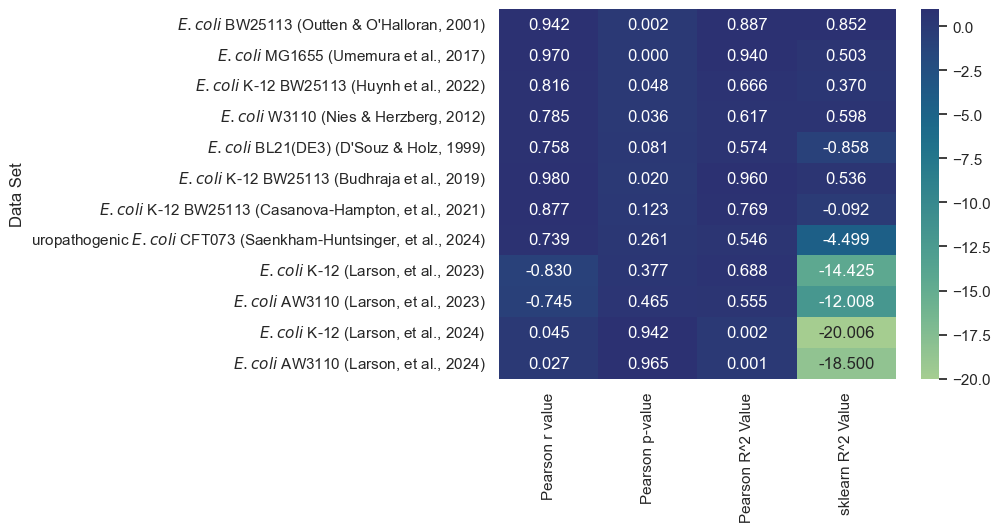

In [17]:
# Make a heatmap of the different correlation values:
LB_correlation_df_ = LB_correlation_df.drop("Elements")
LB_correlation_df_ = LB_correlation_df_.to_pandas()
LB_correlation_df_.set_index("Data Set", inplace=True)
sns.heatmap(LB_correlation_df_, annot=True, fmt=".3f", cmap="crest")

# PLOTS

## Plots with all the data sources (and no special sorting method)

I use these for help with quick visualization of my data. 


Things to consider: 
- maybe add a new font? #sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
- Issue with new fonts is that the italics words remain the old font.

In [18]:
# Custom color palettes (got colors from: https://seaborn.pydata.org/tutorial/color_palettes.html):
custom_palette1 = (sns.color_palette("tab10") + sns.color_palette("husl")[0:1] + sns.color_palette("Set2")[6:7] + sns.color_palette("Paired")[0:1]) 

custom_palette2 = (sns.color_palette("husl") + sns.color_palette("Set2")[5:6]) # adds yellow
# extra colors if needed: 
# sns.color_palette("husl")[6:7]) # adds light purple
# sns.color_palette("Set2")[5:6]) # adds yellow
# sns.color_palette("Set2")[1:2]) # adds light burnt orange
# sns.color_palette("Set2")[2:3]) # adds light periwinkle
# sns.color_palette("Set2")[6:7]) # adds tan
# sns.color_palette("Paired")[0:1]) # adds light blue

# note: it seems like when no palette is specified, the default is husl and the colors don't repeat at all!

# Marker styles (https://seaborn.pydata.org/tutorial/properties.html, https://matplotlib.org/stable/api/markers_api.html#module-matplotlib.markers): 
# marker options: ["o", "s", "D", "X", "P", "v", "^", "<", ">", "1", "2", "3", "4", "8", "p", "P", "*", "h", "H", "+", "x", "d", "|", "_"]
# more options: [(4,1,0)), (8,1,0), (8,2,0) ] # (num sides, fill style, angle)

custom_markers1_SGT = [(4,2,45), (4,2,0)] # markers for the simulation and ground truth data
custom_markers1_exp = ["o", "^", "d", (4,0,45), "p", "h", "8", "P", (4,1,0)] # markers for the experimental data

custom_markers2_SGT = ["*", (8,1,0)] # markers for the simulation and ground truth data

custom_markers3_SGT = ["o","P"]
custom_markers3_exp = ["+",(4,2,45), "1", "2", "3", "4", (8,2,0), "x", (4,2,0)]

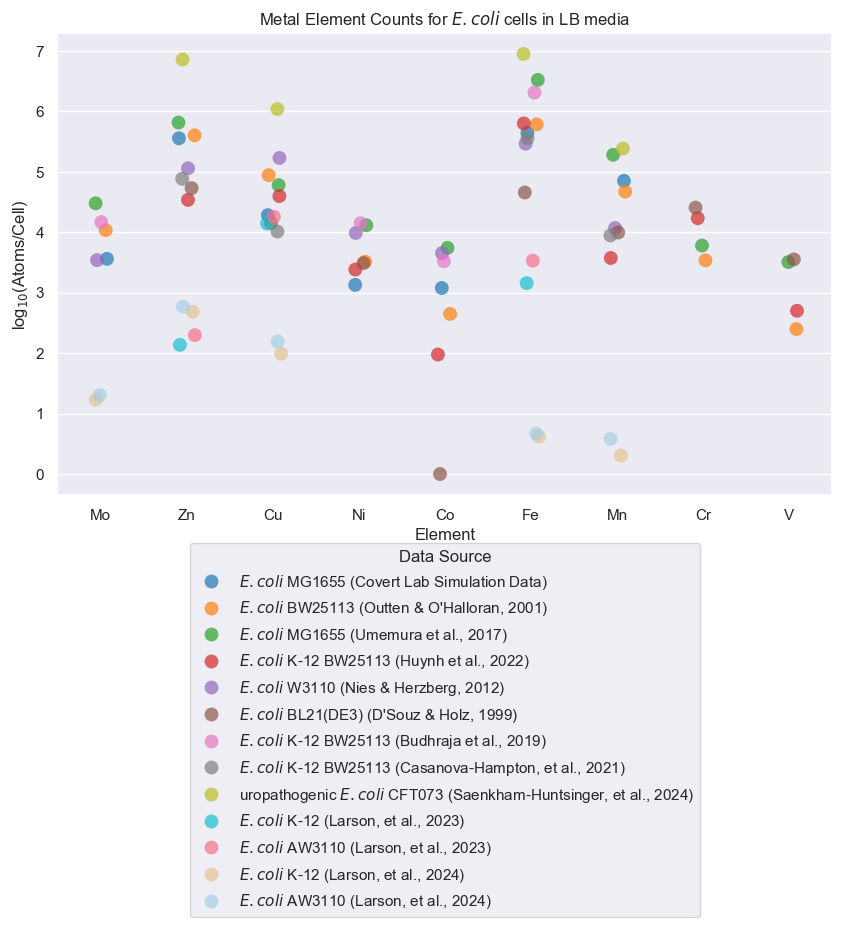

In [19]:
# Create the vertical strip plot
plt.figure(figsize=(10, 6))

ax = sns.stripplot(data=df_long_pd, y="log$_{10}$(Atoms/Cell)", x="Element", hue="Data Source", size=10, alpha=.7, palette=custom_palette1, jitter=True)
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.93))
plt.title("Metal Element Counts for $\t{E. coli}$ cells in LB media")
plt.show()

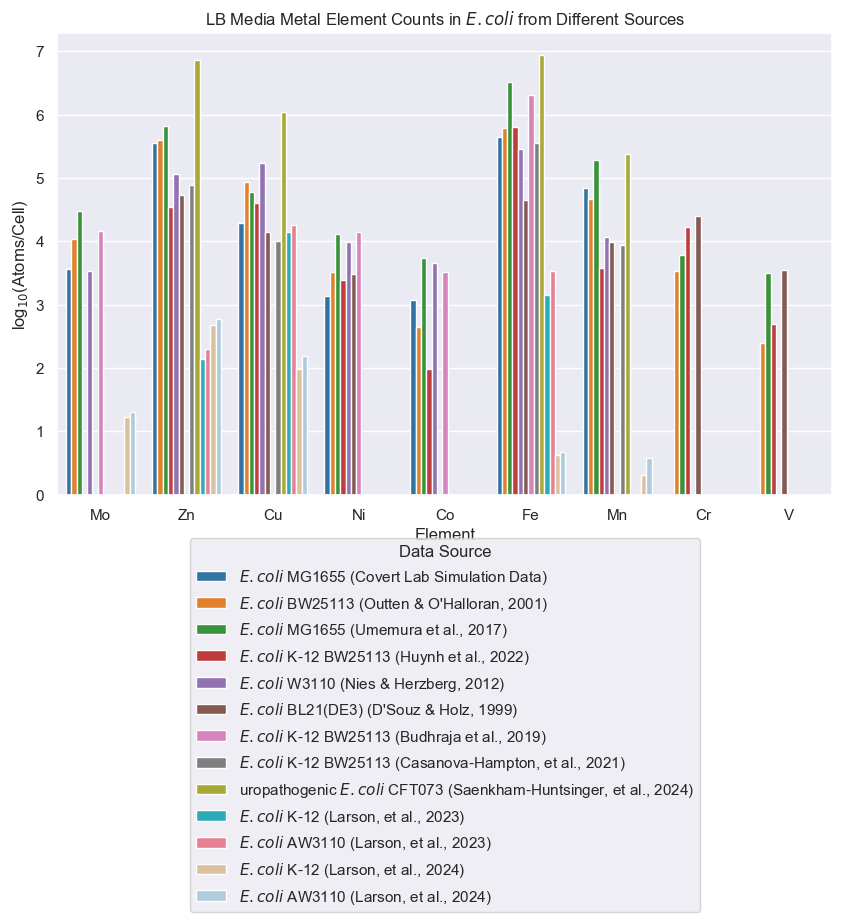

In [20]:
# create a bar plot of the metal counts data: 
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_long_pd, x="Element", y="log$_{10}$(Atoms/Cell)", palette=custom_palette1, hue="Data Source")
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.92))
plt.title("LB Media Metal Element Counts in $\t{E. coli}$ from Different Sources")
plt.show()

# Calculate Medians

Obtaining Medians for plotting:

In [21]:
# Transpose the DF for sorting
lb_exp_dataT = lb_exp_data.drop("Element")
lb_exp_dataT = lb_exp_dataT.transpose(include_header=True, header_name="Source", column_names=lb_exp_data.get_column("Element"))

# calculate the median for each column:
# could also probably use: lb_exp_dataT.select(pl.median("Mo"))
Mo_median = lb_exp_dataT.select("Mo").median()
Zn_median = lb_exp_dataT.select("Zn").median()
Cu_median = lb_exp_dataT.select("Cu").median()
Co_median = lb_exp_dataT.select("Co").median()
Ni_median = lb_exp_dataT.select("Ni").median()
Fe_median = lb_exp_dataT.select("Fe").median()
Mn_median = lb_exp_dataT.select("Mn").median()
Cr_median = lb_exp_dataT.select("Cr").median()
V_median = lb_exp_dataT.select("V").median()

medians = [Mo_median.item(), Zn_median.item(), Cu_median.item(), Ni_median.item(), Co_median.item(), Fe_median.item(), Mn_median.item(), Cr_median.item(), V_median.item()]

# next, have to manually add this back to the original data frame, sort it, then drop the medians column

# create df with medians 
medians_pre_sort = pl.DataFrame({
    "Element": ["Mo", "Zn", "Cu", "Ni", "Co", "Fe", "Mn", "Cr", "V"],
    "Median": medians})

# join the medians df with the original data frame! 
lb_exp_data_with_medians = lb_exp_data.join(medians_pre_sort, on="Element", how="left", coalesce=True)

# sort by the median column
lb_exp_data_sorted_medians = lb_exp_data_with_medians.sort("Median", descending=True)
medians_df = lb_exp_data_sorted_medians.select(["Element", "Median"])

# drop the median column
lb_exp_data_sorted_medians = lb_exp_data_sorted_medians.drop("Median")

# reshape the data for graphs
df_long_medians = lb_exp_data_sorted_medians.melt(id_vars=["Element"], variable_name="Data Source", value_name="log$_{10}$(Atoms/Cell)")
df_long_medians_pd = df_long_medians.to_pandas()

lb_exp_data_sorted_medians

shape: (9, 14)
┌─────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ Element ┆ $	{E.       ┆ $	{E.      ┆ $	{E.      ┆ … ┆ $	{E.      ┆ $	{E.      ┆ $	{E.      ┆ $	{E.      │
│ ---     ┆ coli}$     ┆ coli}$    ┆ coli}$    ┆   ┆ coli}$    ┆ coli}$    ┆ coli}$    ┆ coli}$    │
│ str     ┆ MG1655     ┆ BW25113   ┆ MG1655    ┆   ┆ K-12      ┆ AW3110    ┆ K-12      ┆ AW3110    │
│         ┆ (Covert    ┆ (Outten   ┆ (Umemura  ┆   ┆ (Larson,  ┆ (Larson,  ┆ (Larson,  ┆ (Larson,  │
│         ┆ La…        ┆ &…        ┆ e…        ┆   ┆ et …      ┆ e…        ┆ et …      ┆ e…        │
│         ┆ ---        ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│         ┆ f64        ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞═════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ Fe      ┆ 5.641744   ┆ 5.783291  ┆ 6.518514  ┆ … ┆ 3.1572    ┆ 3.528351  ┆ 0.617796  ┆ 0.667439  │
│ Zn      ┆ 5.552971   ┆ 5.601669  ┆ 5.812913  ┆ … ┆ 2.135949  ┆ 2.296861  ┆ 2.684758  ┆ 2.768254  │
│ Cu      ┆ 4.281401   ┆ 4.942388  ┆ 4.778151  ┆ … ┆ 4.142316  ┆ 4.253392  ┆ 1.990243  ┆ 2.192628  │
│ Mn      ┆ 4.848615   ┆ 4.669722  ┆ 5.278754  ┆ … ┆ null      ┆ null      ┆ 0.305102  ┆ 0.582313  │
│ Cr      ┆ null       ┆ 3.533308  ┆ 3.778151  ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ Mo      ┆ 3.559093   ┆ 4.033304  ┆ 4.477121  ┆ … ┆ null      ┆ null      ┆ 1.230293  ┆ 1.3061    │
│ Ni      ┆ 3.127828   ┆ 3.510581  ┆ 4.113943  ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ V       ┆ null       ┆ 2.396953  ┆ 3.50515   ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ Co      ┆ 3.076086   ┆ 2.646951  ┆ 3.740363  ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
└─────────┴────────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

In [22]:
medians_df

shape: (9, 2)
┌─────────┬──────────┐
│ Element ┆ Median   │
│ ---     ┆ ---      │
│ str     ┆ f64      │
╞═════════╪══════════╡
│ Fe      ┆ 5.553499 │
│ Zn      ┆ 4.80575  │
│ Cu      ┆ 4.267397 │
│ Mn      ┆ 4.031148 │
│ Cr      ┆ 4.004384 │
│ Mo      ┆ 3.559093 │
│ Ni      ┆ 3.510581 │
│ V       ┆ 3.102476 │
│ Co      ┆ 3.076086 │
└─────────┴──────────┘

## Basic Median Plots

In [23]:
# prepare data by adding a small marker for the median value of each element: 
long_medians = medians_df.melt(id_vars=["Element"], variable_name="Data Source", value_name="log$_{10}$(Atoms/Cell)")
long_medians_pd = long_medians.to_pandas()

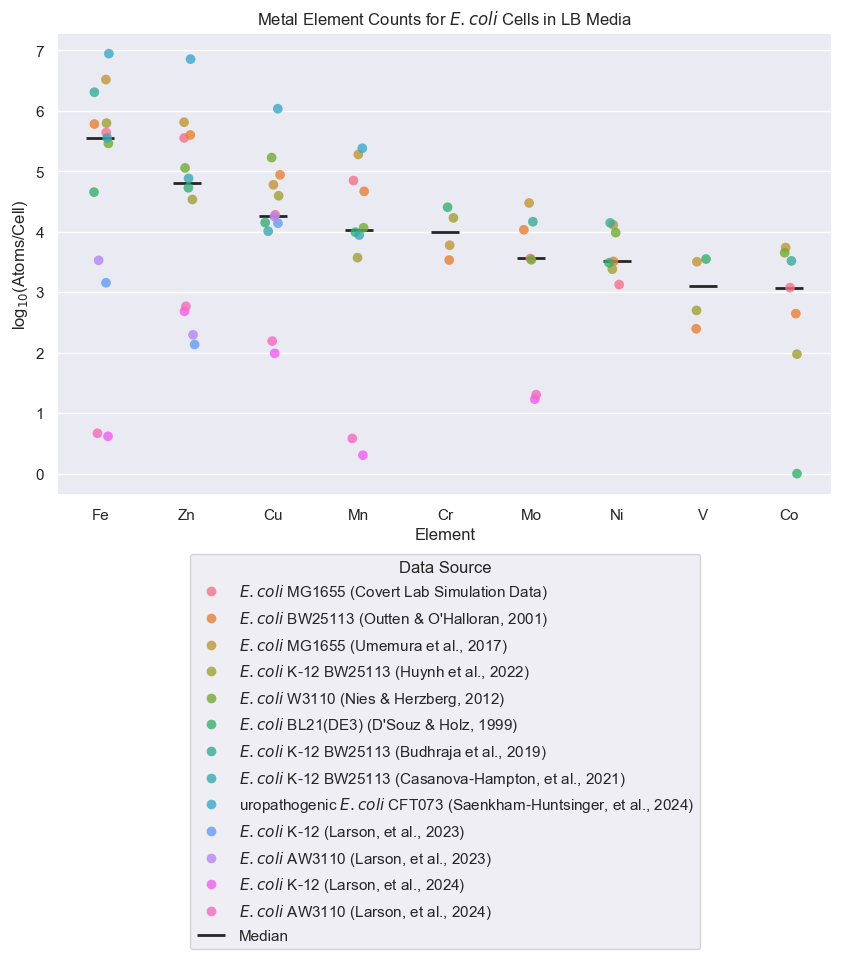

In [24]:
# Create the vertical strip plot
plt.figure(figsize=(10, 6))
ax = sns.stripplot(data=df_long_medians_pd, y="log$_{10}$(Atoms/Cell)", x="Element", hue="Data Source", size=7, alpha=.8, jitter=True)
ax = sns.pointplot(
     data=long_medians_pd, y="log$_{10}$(Atoms/Cell)", x="Element", hue="Data Source", linestyle="none", errorbar=None,
     marker="_", markersize=20, markeredgewidth=2, palette='dark:black')

# Plot Specs:
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -1))
sns.color_palette("tab10")
plt.title("Metal Element Counts for $\t{E. coli}$ Cells in LB Media")

plt.show()

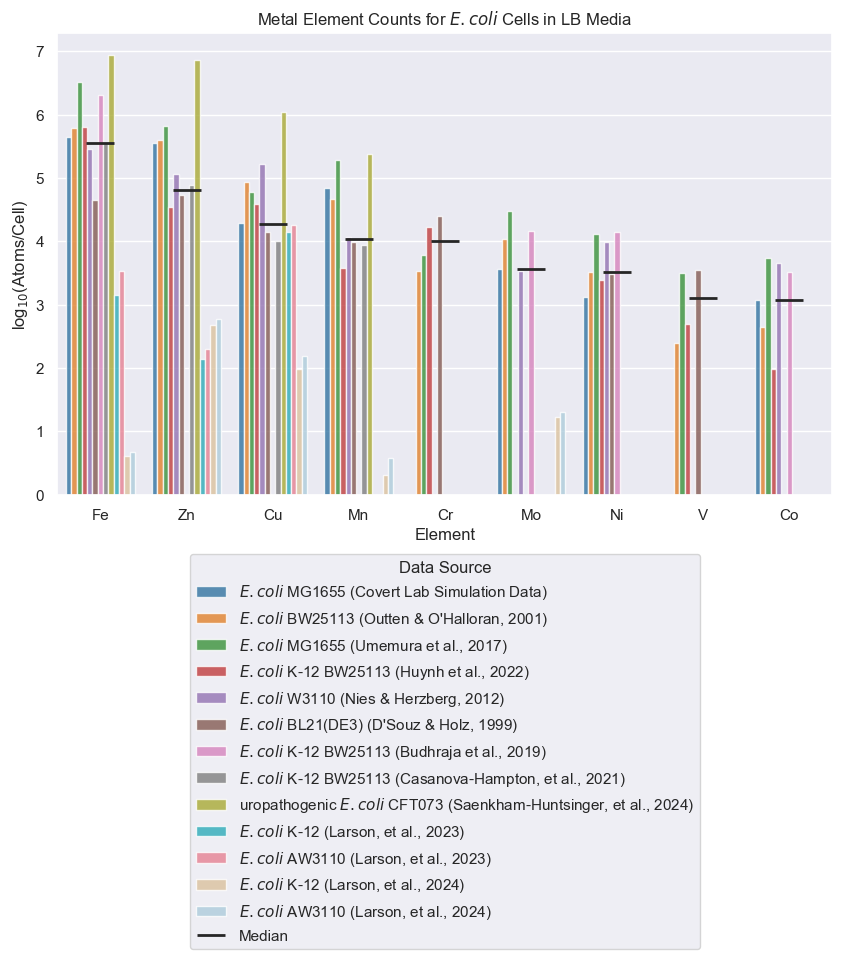

In [25]:
# create a bar plot of the metal counts data: 
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_long_medians_pd, x="Element", y="log$_{10}$(Atoms/Cell)", palette=custom_palette1, hue="Data Source", alpha=.8, linewidth=1)
ax = sns.pointplot(
     data=long_medians_pd, y="log$_{10}$(Atoms/Cell)", x="Element", hue="Data Source", linestyle="none", errorbar=None,
     marker="_", markersize=20, markeredgewidth=2, palette='dark:black')

# Plot Specs:
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -1))
plt.title("Metal Element Counts for $\t{E. coli}$ Cells in LB Media")

plt.show()

## Improve the figure styling:

This link is really helpful: https://seaborn.pydata.org/tutorial/properties.html 

# Absolute Geometric Comparisons with O'Halloran Data
 
- Cyrus said to do sum(abs(x2-x1)) for each dataset

In [26]:
# FUNCTIONS

# create function for averaging the geometric distance between two datasets:
def avg_geometric_distance_1D_log10(reference_data, experimental_data):
    # initialize a new data set of just the element names:
    geometric_distances = reference_data.select("Element")
    dataset_names = []
    average_geometric_distances = []
   
    # loop through the columns of the experimental data:
    for column in experimental_data.columns[1:]:
        col_name = str(column)
        # calculate the geometric distance between the two datasets: (since the values are log, subtract them)
        geometric_distance = abs(experimental_data[col_name] - (reference_data[reference_data.columns[1]]))
        geometric_distances = geometric_distances.with_columns(pl.Series(col_name, geometric_distance))
        
        # calculate the average geometric distance for each element:
        avg_geometric_distance = geometric_distance.mean()
        dataset_names.append(col_name)
        average_geometric_distances.append(avg_geometric_distance)
        
    average_geometric_distances = pd.DataFrame({"Data Source": dataset_names, "Average Geometric Distance": average_geometric_distances})
    return geometric_distances, average_geometric_distances

# create a function for plotting the elements averaged over on the bar plot next to each bar:
def plot_elements_averaged_over_only(all_data_noOO, average_geometric_distances_sorted):
    # determine the number and names of the elements used in the calculation for each dataset:
    elems = []
    names = [] # use this to check 
    for i in range(len(all_data_noOO.columns[1:])):
        sorted_col_name = average_geometric_distances_sorted["Data Source"].to_list()[i]
        dataset = all_data_noOO.select(["Element", sorted_col_name])
        elements = dataset.filter(pl.col(dataset.columns[1]).is_null() != True)
        elems.append(", ".join(elements["Element"].to_list()))
        names.append(sorted_col_name)
        
    # plot the elements used in the calculation for each dataset:
    for i, value in enumerate(average_geometric_distances_sorted["Average Geometric Distance"]):
        plt.text(value + 0.01, i + 0.2, elems[i], ha='left', fontsize=8)
        
# create a function for plotting the number of elements averaged over ONLY: 
def plot_num_elements_averaged_over_only(all_data_noOO, average_geometric_distances_sorted):
    # determine the number and names of the elements used in the calculation for each dataset:
    elems = []
    names = [] # use this to check the order of dataset element collection (to match sorted)
    for i in range(len(all_data_noOO.columns[1:])):
        sorted_col_name = average_geometric_distances_sorted["Data Source"].to_list()[i]
        dataset = all_data_noOO.select(["Element", sorted_col_name])
        elements = dataset.filter(pl.col(dataset.columns[1]).is_null() != True)
        num_elements = len(elements["Element"].to_list())
        elems_str = "averaged over " + str(num_elements) + " elements"
        elems.append(elems_str)
        names.append(sorted_col_name)
        
    # plot the elements used in the calculation for each dataset:
    for i, value in enumerate(average_geometric_distances_sorted["Average Geometric Distance"]):
        plt.text(value + 0.01, i + 0.15, elems[i], ha='left', fontsize=8)
        
# create a function for plotting the number of elements averaged over AND the identities of the elements averaged over: 
def plot_num_averaged_and_elements(all_data_noOO, average_geometric_distances_sorted):
    # determine the number and names of the elements used in the calculation for each dataset:
    elems = []
    names = [] # use this to check the order of dataset element collection (to match sorted)
    for i in range(len(all_data_noOO.columns[1:])):
        sorted_col_name = average_geometric_distances_sorted["Data Source"].to_list()[i]
        dataset = all_data_noOO.select(["Element", sorted_col_name])
        elements = dataset.filter(pl.col(dataset.columns[1]).is_null() != True)
        num_elements = len(elements["Element"].to_list())
        elems_str = str(num_elements) + " elements: " + ", ".join(elements["Element"].to_list())
        elems.append(elems_str)
        names.append(sorted_col_name)
        
    # plot the elements used in the calculation for each dataset:
    for i, value in enumerate(average_geometric_distances_sorted["Average Geometric Distance"]):
        plt.text(value + 0.01, i + 0.2, elems[i], ha='left', fontsize=8)

# 1) PLOTS focused around data for the following four elements: FE, Zn, Mn, Cu 

## 1.a: Scatter plot highlighting the data points for Fe, Zn, Mn, and Cu

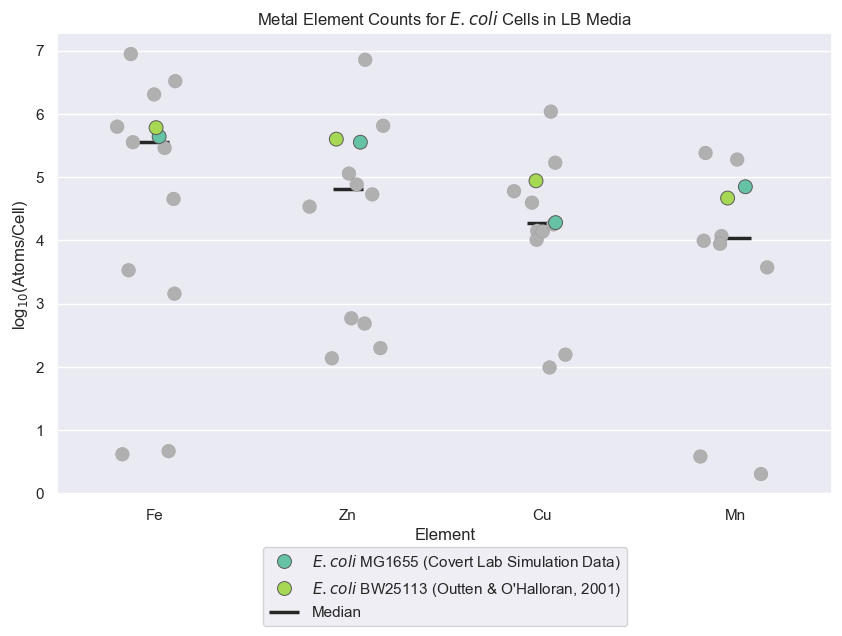

In [27]:
# Cryus' requests:

# take out Co, Cr, V, MO, and Ni from the data sorted by medians:
lb_data_no_V = lb_exp_data_sorted_medians.filter(pl.col("Element") != "V")
lb_data_no_CrV = lb_data_no_V.filter(pl.col("Element") != "Cr")
lb_data_no_CrCoV = lb_data_no_CrV.filter(pl.col("Element") != "Co")
lb_data_no_CrCoVNi = lb_data_no_CrCoV.filter(pl.col("Element") != "Ni")
lb_data_no_CrCoVNiMo = lb_data_no_CrCoVNi.filter(pl.col("Element") != "Mo")

# split the ground truth and simulation data from the rest of the literature data: 
GT_sim_LB_data_woCrCoVNiMo = lb_data_no_CrCoVNiMo["Element", "$\t{E. coli}$ MG1655 (Covert Lab Simulation Data)", "$\t{E. coli}$ BW25113 (Outten & O\'Halloran, 2001)"]
exp_LB_data_woCrCoVNiMo = lb_data_no_CrCoVNiMo[:,[0,3,4,5,6,7,8,9,10,11,12,13]]

# reshape the data for graphs
GT_sim_LB_data_woCrCoVNiMo_long = GT_sim_LB_data_woCrCoVNiMo.melt(id_vars=["Element"], variable_name="Data Source", value_name="log$_{10}$(Atoms/Cell)")
GT_sim_LB_data_woCrCoVNiMo_long_pd = GT_sim_LB_data_woCrCoVNiMo_long.to_pandas()
exp_LB_data_woCrCoVNiMo_long = exp_LB_data_woCrCoVNiMo.melt(id_vars=["Element"], variable_name="Data Source", value_name="log$_{10}$(Atoms/Cell)")
exp_LB_data_woCrCoVNiMo_long_pd = exp_LB_data_woCrCoVNiMo_long.to_pandas()

# remove the same elements from the medians data:
medians_df_no_V = medians_df.filter(pl.col("Element") != "V")
medians_df_no_CrV = medians_df_no_V.filter(pl.col("Element") != "Cr")
medians_df_no_CrCoV = medians_df_no_CrV.filter(pl.col("Element") != "Co")
medians_df_no_CrCoVNi = medians_df_no_CrCoV.filter(pl.col("Element") != "Ni")   
medians_df_no_CrCoVNiMo = medians_df_no_CrCoVNi.filter(pl.col("Element") != "Mo")

# reshape the medians data for graphing: 
long_medians_woCrCoVNiMo = medians_df_no_CrCoVNiMo.melt(id_vars=["Element"], variable_name="Data Source", value_name="log$_{10}$(Atoms/Cell)")
long_medians_woCrCoVNiMo_pd = long_medians_woCrCoVNiMo.to_pandas()

# plot the figure
plt.figure(figsize=(10, 6))

# add custom colors:
custom_palette3 = (sns.color_palette("Set2")[0:1] + sns.color_palette("Set2")[4:5])
grey_palette3 = ["#B0B0B0","#B0B0B0","#B0B0B0","#B0B0B0","#B0B0B0","#B0B0B0","#B0B0B0","#B0B0B0","#B0B0B0","#B0B0B0", "#B0B0B0"]

# add a jitter seed: (Good seeds: 0, 3, 4, 7, 10)
np.random.seed(10)

# plot the data: 
ax = sns.stripplot(data=exp_LB_data_woCrCoVNiMo_long_pd, y="log$_{10}$(Atoms/Cell)", x="Element", hue="Data Source", palette=grey_palette3, s=10, linewidth=.1, alpha=1, jitter=.2) 
ax = sns.stripplot(data=GT_sim_LB_data_woCrCoVNiMo_long_pd, y="log$_{10}$(Atoms/Cell)", x="Element",  hue="Data Source", s=10, alpha=1, palette=custom_palette3, jitter=.1, linewidth=.7,) #DC143C

# add a small marker at the median value of each element: 
ax = sns.pointplot(
     data=long_medians_woCrCoVNiMo_pd, y="log$_{10}$(Atoms/Cell)", x="Element", hue="Data Source", linestyle="none", errorbar=None,
     marker="_", markersize=22, markeredgewidth=2.5, palette='dark:black')

# Plot Specs 
plt.title("Metal Element Counts for $\t{E. coli}$ Cells in LB Media")
# Get the handles and labels from the plot
handles, labels = ax.get_legend_handles_labels()
# Specify the entries you want to include in the legend
included_labels = ["$\t{E. coli}$ MG1655 (Covert Lab Simulation Data)", '$\t{E. coli}$ BW25113 (Outten & O\'Halloran, 2001)', "Median"]  
included_handles = [handles[labels.index(label)] for label in included_labels]
# Create the legend manually
plt.legend(included_handles, included_labels, loc='upper right')
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.3))

plt.show()

## 1.b: Comparing the Average Geometric distance for elements Fe, Zn, Mn, and Cu only

In [30]:
# compute the average geometric distance between each dataset and the O'Halloran data (with the four elements: FE, Zn, Mn, Cu)
OO_data_woCrCoVNiMo = lb_data_no_CrCoVNiMo.select(["Element", "$\t{E. coli}$ BW25113 (Outten & O\'Halloran, 2001)"])
all_data_noOO_woCrCoVNiMo = lb_data_no_CrCoVNiMo.drop("$\t{E. coli}$ BW25113 (Outten & O\'Halloran, 2001)")

# compute for datasets that have values for any of the 4 elements: FE, Zn, Mn, Cu
GD_woCrCoVNiMo, AGD_woCrCoVNiMo = avg_geometric_distance_1D_log10(OO_data_woCrCoVNiMo, all_data_noOO_woCrCoVNiMo)

1.b.i: bar plot option with ALL sources from the data that has a value for at least one of the 4 elements: Fe, Zn, Mn, Cu


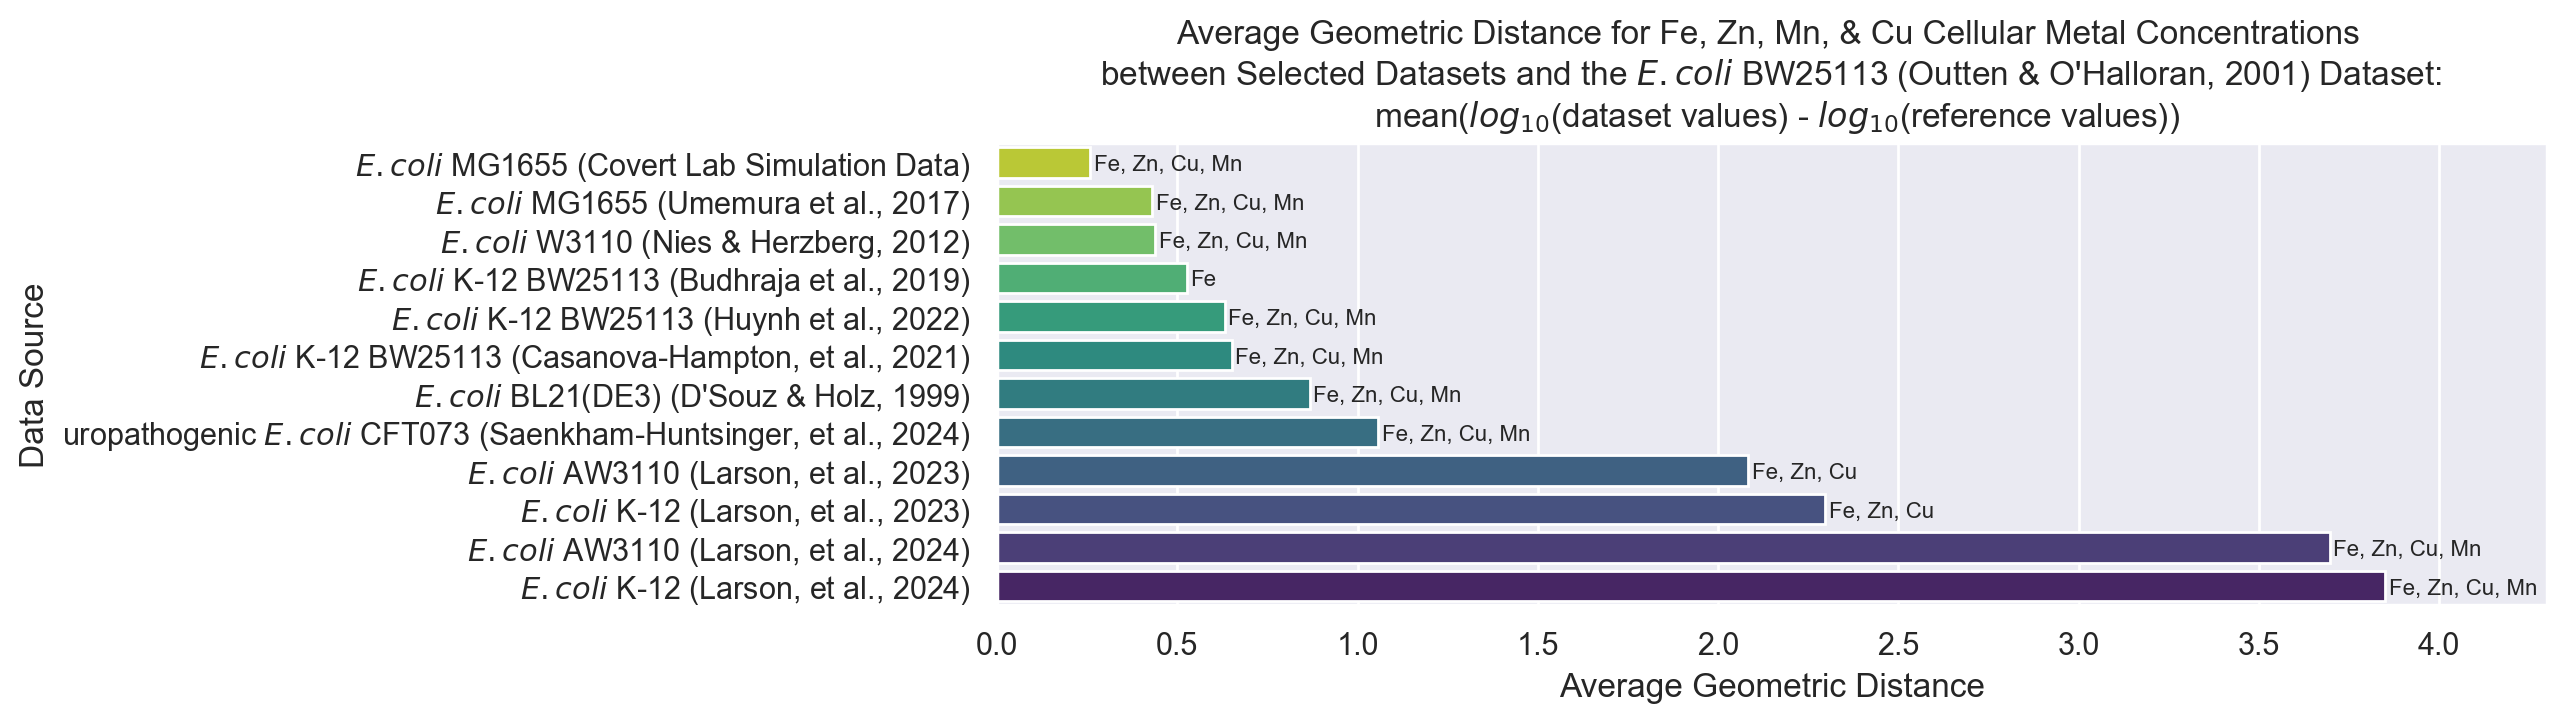

In [31]:
# sort the data by the average geometric distance:
AGD_woCrCoVNiMo_sorted = AGD_woCrCoVNiMo.sort_values("Average Geometric Distance")

# make a 1D plot of the average geometric distances:
plt.figure(dpi=200, figsize=(10, 3))
ax = sns.barplot(data=AGD_woCrCoVNiMo_sorted, y="Data Source", x="Average Geometric Distance", palette="viridis_r", hue="Data Source")

# Plot Specs:
plot_elements_averaged_over_only(all_data_noOO_woCrCoVNiMo, AGD_woCrCoVNiMo_sorted)
plt.title("Average Geometric Distance for Fe, Zn, Mn, & Cu Cellular Metal Concentrations \nbetween Selected Datasets and the $\t{E. coli}$ BW25113 (Outten & O\'Halloran, 2001) Dataset: \n mean($log_{10}$(dataset values) - $log_{10}$(reference values))")
plt.xlim([0, 4.3])

plt.show()

1.b.ii same as above, but with a different legend label

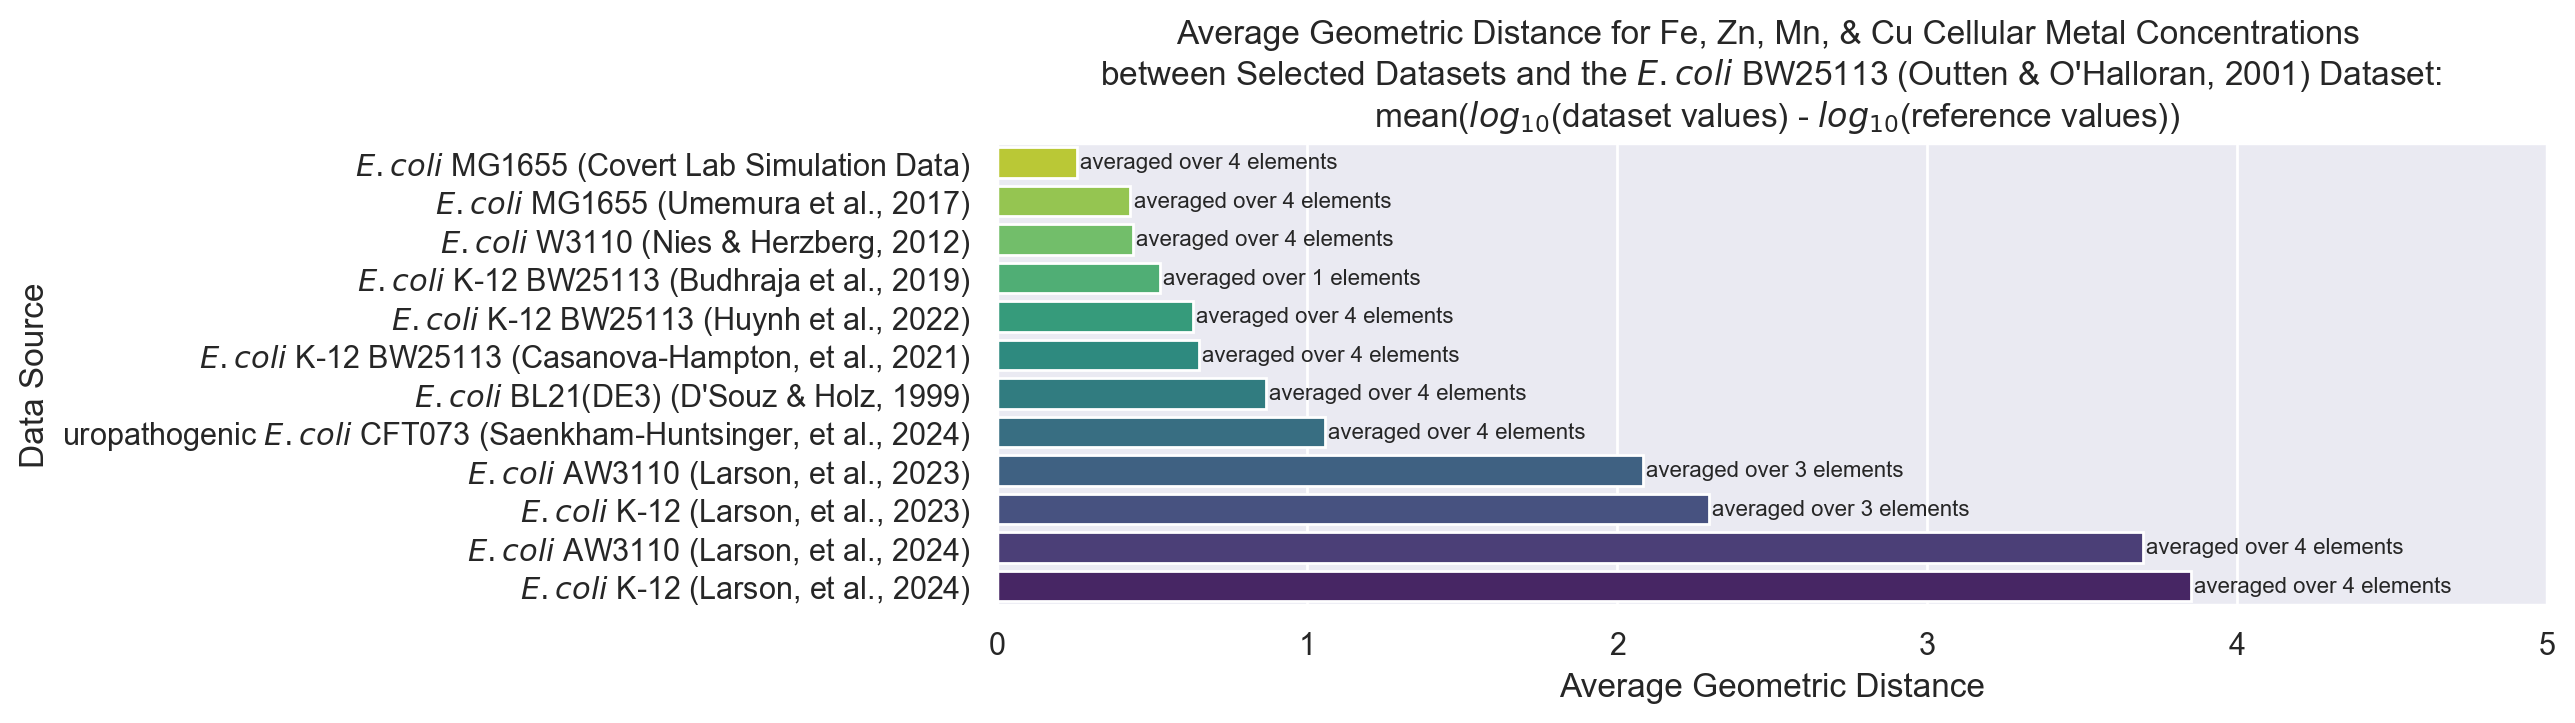

In [32]:
# sort the data by the average geometric distance:
AGD_woCrCoVNiMo_sorted = AGD_woCrCoVNiMo.sort_values("Average Geometric Distance")

# make a 1D plot of the average geometric distances:
plt.figure(dpi=200, figsize=(10, 3))
ax = sns.barplot(data=AGD_woCrCoVNiMo_sorted, y="Data Source", x="Average Geometric Distance", palette="viridis_r", hue="Data Source")

# Plot Specs:
plot_num_elements_averaged_over_only(all_data_noOO_woCrCoVNiMo, AGD_woCrCoVNiMo_sorted)
plt.title("Average Geometric Distance for Fe, Zn, Mn, & Cu Cellular Metal Concentrations \nbetween Selected Datasets and the $\t{E. coli}$ BW25113 (Outten & O\'Halloran, 2001) Dataset: \n mean($log_{10}$(dataset values) - $log_{10}$(reference values))")
plt.xlim([0, 5])

plt.show()

1.b.iii same as above, but with the elements averaged over and the number

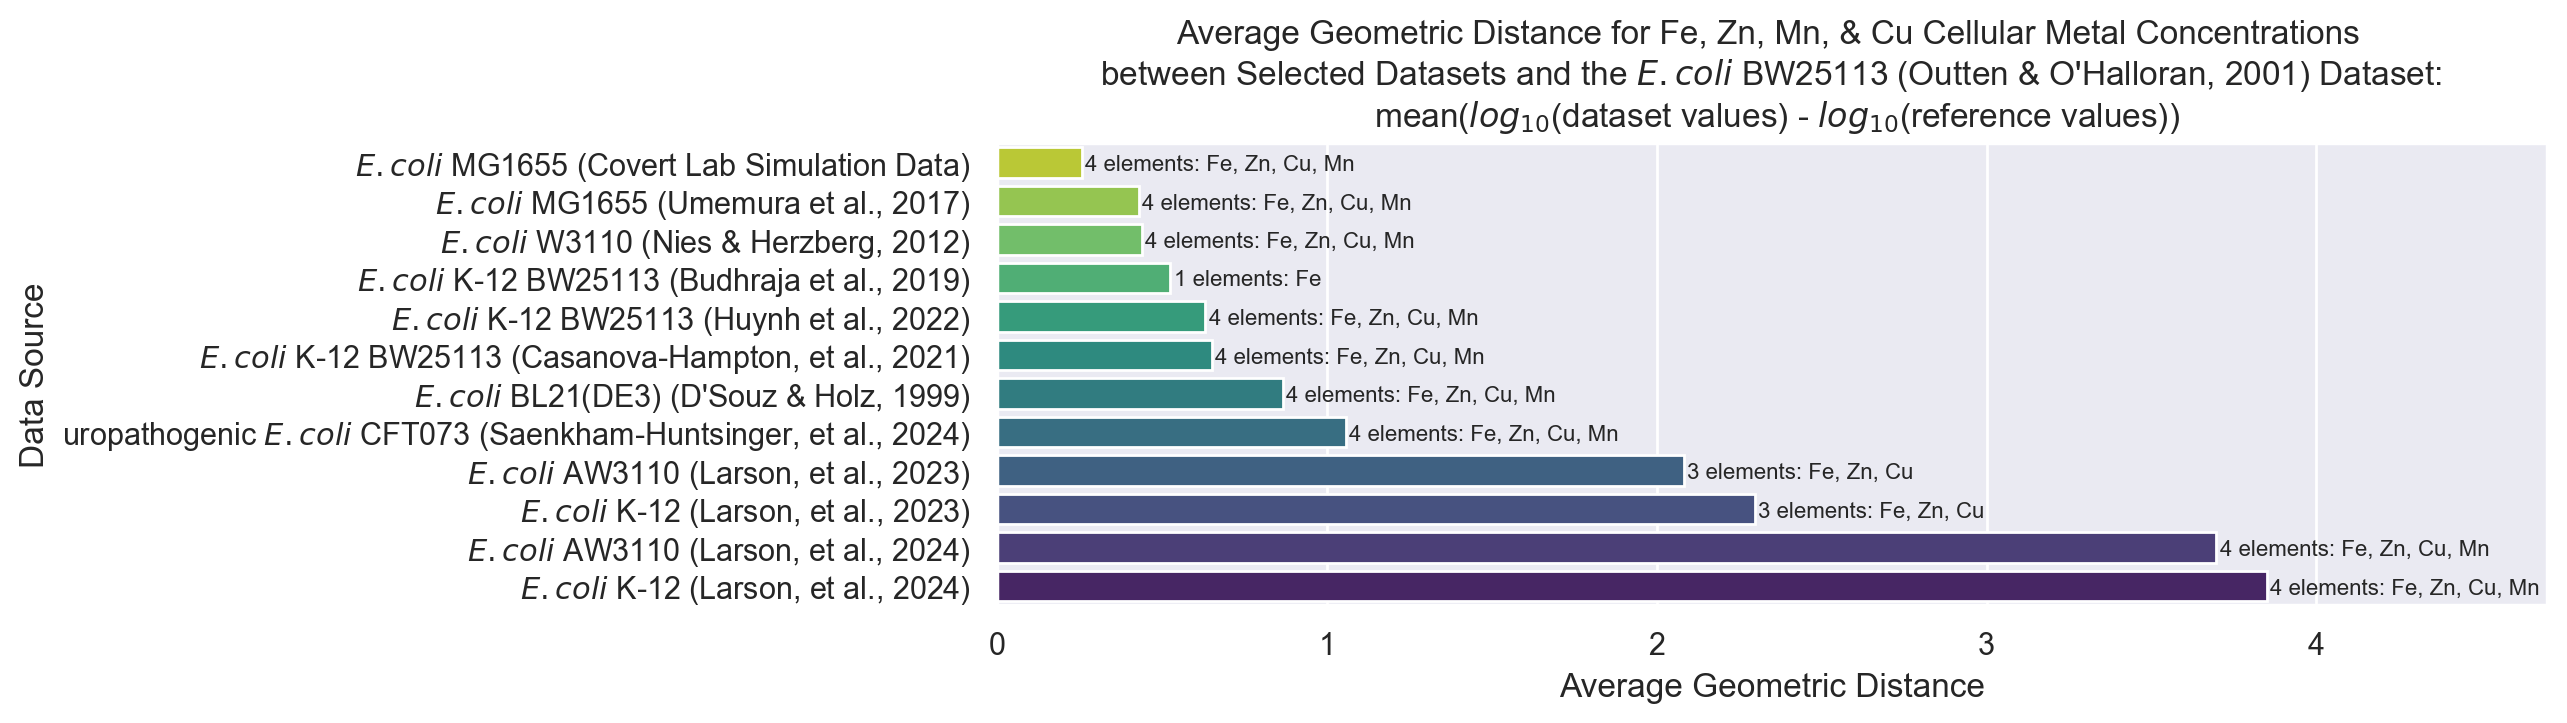

In [33]:
# sort the data by the average geometric distance:
AGD_woCrCoVNiMo_sorted = AGD_woCrCoVNiMo.sort_values("Average Geometric Distance")

# make a 1D plot of the average geometric distances:
plt.figure(dpi=200, figsize=(10, 3))
ax = sns.barplot(data=AGD_woCrCoVNiMo_sorted, y="Data Source", x="Average Geometric Distance", palette="viridis_r", hue="Data Source")

# Plot Specs:
plot_num_averaged_and_elements(all_data_noOO_woCrCoVNiMo, AGD_woCrCoVNiMo_sorted)
plt.title("Average Geometric Distance for Fe, Zn, Mn, & Cu Cellular Metal Concentrations \nbetween Selected Datasets and the $\t{E. coli}$ BW25113 (Outten & O\'Halloran, 2001) Dataset: \n mean($log_{10}$(dataset values) - $log_{10}$(reference values))")
plt.xlim([0, 4.7])

plt.show()


## 1.c: bar plots for data sources that have a value for each of the following four elements: Fe, Zn, Mn, Cu

In [34]:
# compute for datasets that have values for all the following 4 elements: FE, Zn, Mn, Cu
all_data_noNANs = all_data_noOO_woCrCoVNiMo.select([col for col in all_data_noOO_woCrCoVNiMo.columns if not all_data_noOO_woCrCoVNiMo[col].is_null().any()])
GD_woCrCoVNiMo, AGD_noNANs_woCrCoVNiMo = avg_geometric_distance_1D_log10(OO_data_woCrCoVNiMo, all_data_noNANs)

1.c.i bar plot option with ALL sources from the data that has a value for EACH of the 4 elements: FE, Zn, Mn, Cu

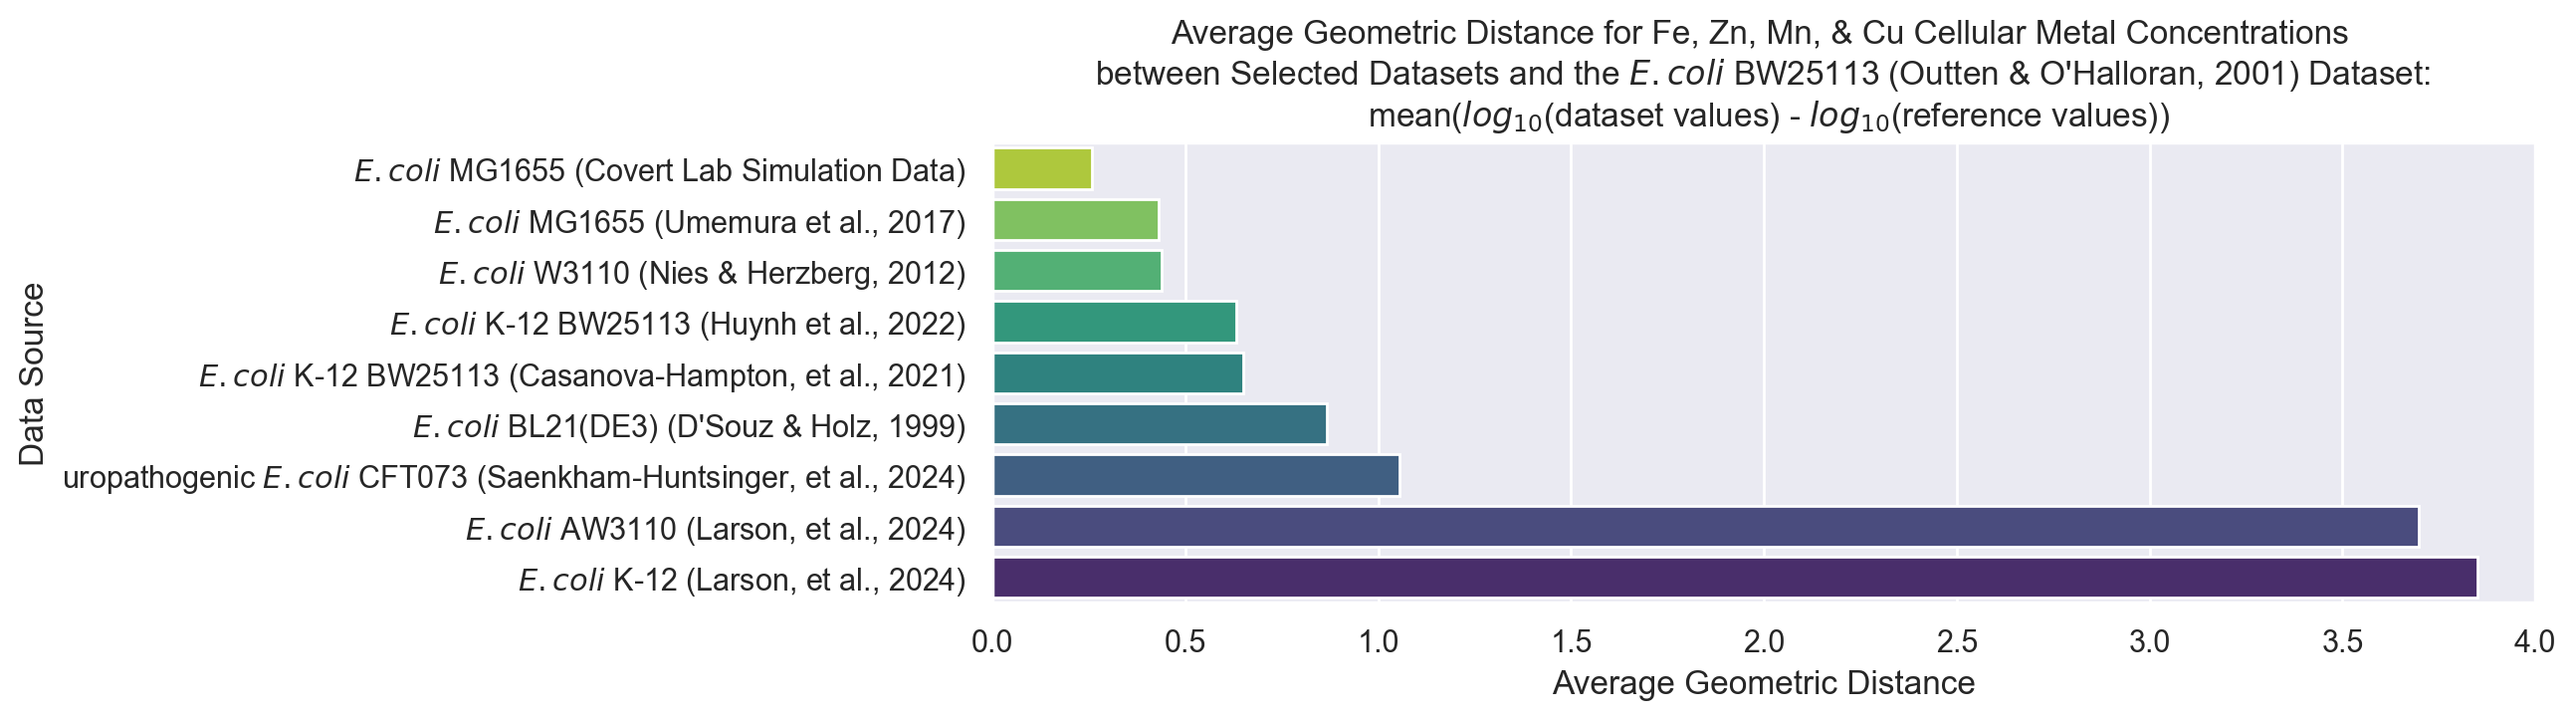

In [35]:
# sort the data by the average geometric distance:
AGD_noNANs_woCrCoVNiMo_sorted = AGD_noNANs_woCrCoVNiMo.sort_values("Average Geometric Distance")

# make a 1D plot of the average geometric distances:
plt.figure(dpi=200, figsize=(10, 3))
ax = sns.barplot(data=AGD_noNANs_woCrCoVNiMo_sorted, y="Data Source", x="Average Geometric Distance", palette="viridis_r", hue="Data Source")

# Plot Specs:
plt.title("Average Geometric Distance for Fe, Zn, Mn, & Cu Cellular Metal Concentrations \nbetween Selected Datasets and the $\t{E. coli}$ BW25113 (Outten & O\'Halloran, 2001) Dataset: \n mean($log_{10}$(dataset values) - $log_{10}$(reference values))")
plt.xlim([0, 4])

plt.show()

1.b.1.i same as above, but with the last four data sources removed 

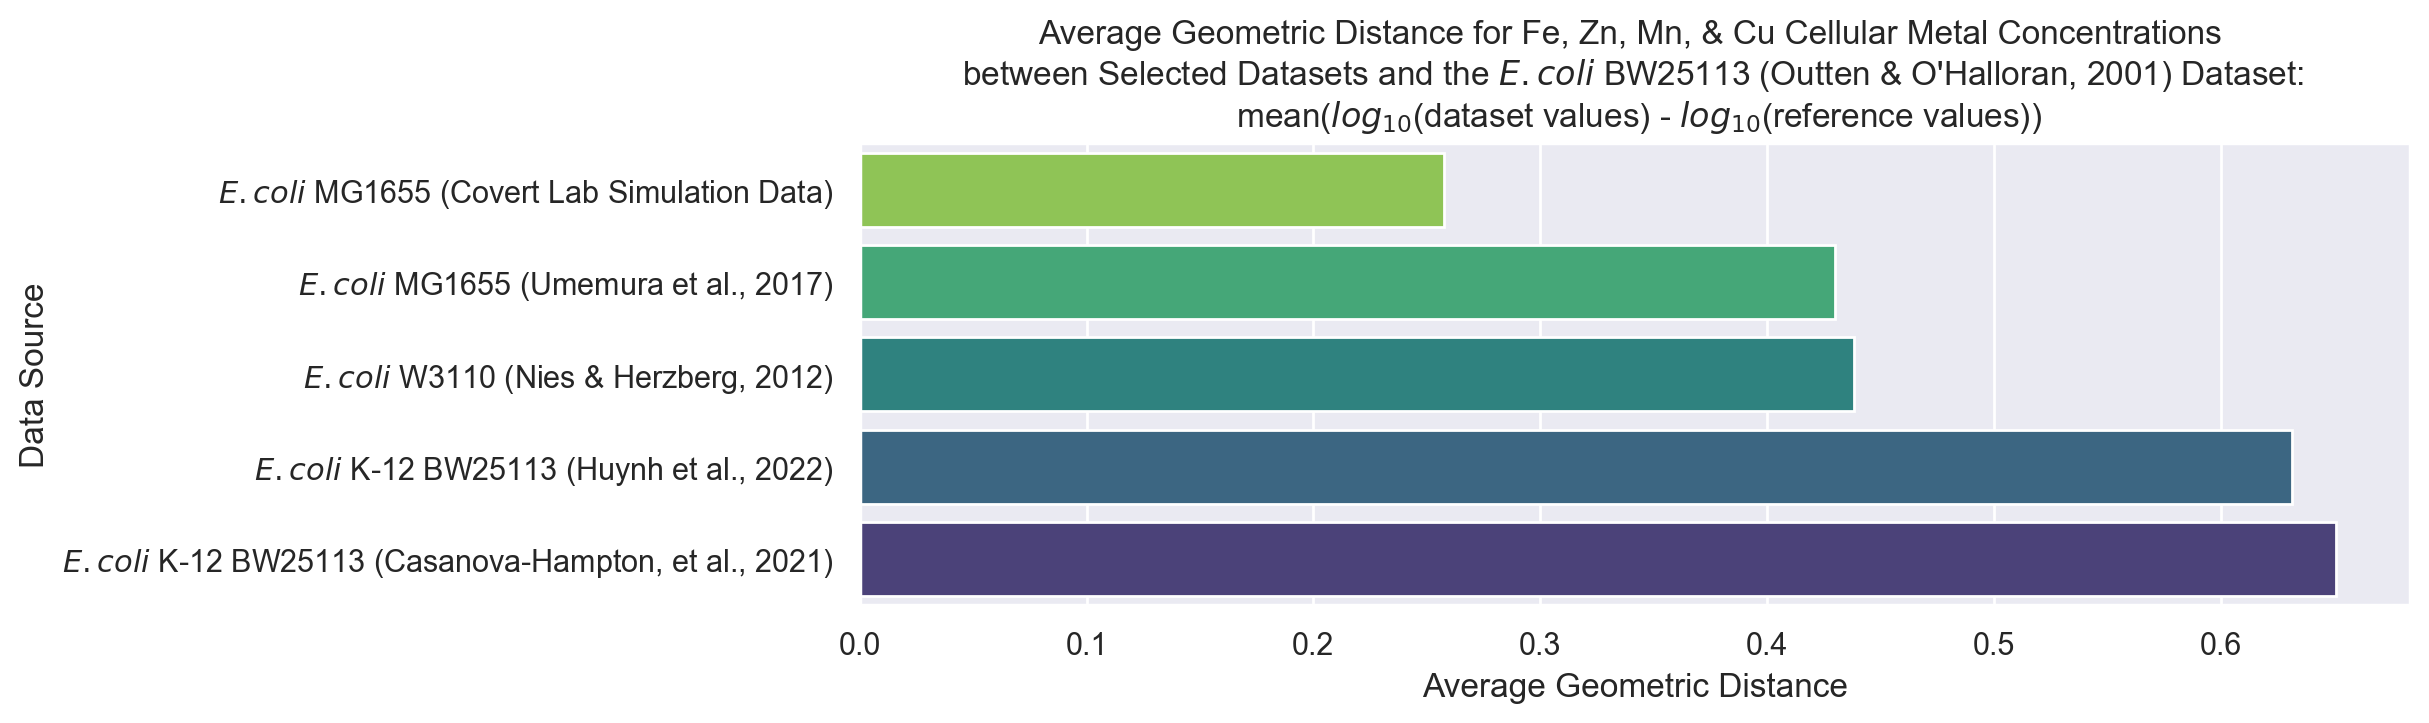

In [36]:
# sort the data by the average geometric distance:
AGD_noNANs_woCrCoVNiMo_sorted = AGD_noNANs_woCrCoVNiMo.sort_values("Average Geometric Distance")

# drop the last four Data Sources from the rest:
smallest_AGD_noNANs_woCrCoVNiMo_sorted = AGD_noNANs_woCrCoVNiMo_sorted[:-4]

# make a 1D plot of the average geometric distances:
plt.figure(dpi=200, figsize=(10, 3)) 
sns.set(style="darkgrid") # reset the style back to darkgrid
ax = sns.barplot(data=smallest_AGD_noNANs_woCrCoVNiMo_sorted, y="Data Source", x="Average Geometric Distance", palette="viridis_r", hue="Data Source")

# Plot Specs:
plt.title("Average Geometric Distance for Fe, Zn, Mn, & Cu Cellular Metal Concentrations \nbetween Selected Datasets and the $\t{E. coli}$ BW25113 (Outten & O\'Halloran, 2001) Dataset: \n mean($log_{10}$(dataset values) - $log_{10}$(reference values))")

plt.show()

# 2) Plots of the data sources with all available elements

## 2.a: Scatter Plot of all the available data sources and their elements

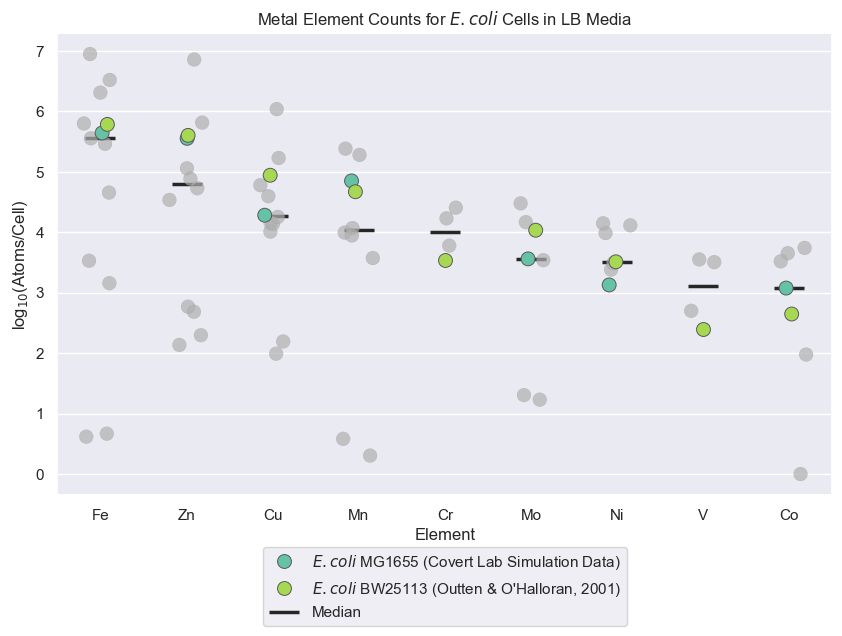

In [37]:
# split the ground truth and simulation data from the rest of the literature data: 
GT_sim_LB_data = lb_exp_data_sorted_medians["Element", "$\t{E. coli}$ MG1655 (Covert Lab Simulation Data)", "$\t{E. coli}$ BW25113 (Outten & O\'Halloran, 2001)"]
exp_LB_data = lb_exp_data_sorted_medians[:,[0,3,4,5,6,7,8,9,10,11,12,13]]

# reshape the data for graphs
GT_sim_LB_data_long = GT_sim_LB_data.melt(id_vars=["Element"], variable_name="Data Source", value_name="log$_{10}$(Atoms/Cell)")
GT_sim_LB_data_long_pd = GT_sim_LB_data_long.to_pandas()
exp_LB_data_long = exp_LB_data.melt(id_vars=["Element"], variable_name="Data Source", value_name="log$_{10}$(Atoms/Cell)")
exp_LB_data_long_pd = exp_LB_data_long.to_pandas()

# reshape the medians data for graphing: 
long_medians = medians_df.melt(id_vars=["Element"], variable_name="Data Source", value_name="log$_{10}$(Atoms/Cell)")
long_medians_pd = long_medians.to_pandas()

# plot the figure
plt.figure(figsize=(10, 6))

# add custom colors:
custom_palette3 = (sns.color_palette("Set2")[0:1] + sns.color_palette("Set2")[4:5])
grey_palette3 = ["#B0B0B0","#B0B0B0","#B0B0B0","#B0B0B0","#B0B0B0","#B0B0B0","#B0B0B0","#B0B0B0","#B0B0B0","#B0B0B0", "#B0B0B0"]

# add a jitter seed: (Good seeds: 0, 3, 4, 7, 10)
np.random.seed(10)

# plot the data: 
ax = sns.stripplot(data=exp_LB_data_long_pd, y="log$_{10}$(Atoms/Cell)", x="Element", hue="Data Source", palette=grey_palette3, s=10, linewidth=.1, alpha=.7, jitter=.2) 
ax = sns.stripplot(data=GT_sim_LB_data_long_pd, y="log$_{10}$(Atoms/Cell)", x="Element",  hue="Data Source", s=10, alpha=1, palette=custom_palette3, jitter=.1, linewidth=.7,) #DC143C

# add a small marker at the median value of each element: 
ax = sns.pointplot(
     data=long_medians_pd, y="log$_{10}$(Atoms/Cell)", x="Element", hue="Data Source", linestyle="none", errorbar=None,
     marker="_", markersize=22, markeredgewidth=2.5, palette='dark:black')

# Plot Specs:
plt.title("Metal Element Counts for $\t{E. coli}$ Cells in LB Media")
handles, labels = ax.get_legend_handles_labels() # Get the handles and labels from the plot
included_labels = ["$\t{E. coli}$ MG1655 (Covert Lab Simulation Data)", '$\t{E. coli}$ BW25113 (Outten & O\'Halloran, 2001)', "Median"] # Specify the entries you want to include in the legend 
included_handles = [handles[labels.index(label)] for label in included_labels]
plt.legend(included_handles, included_labels, loc='upper right') # Create the legend manually
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.3))

plt.show()

## 2.b: bar plots for data sources and all their elements

In [38]:
# split the data again:
OO_data_all_elements = lb_exp_data_sorted_medians.select(["Element", "$\t{E. coli}$ BW25113 (Outten & O\'Halloran, 2001)"])
all_data_noOO_all_elements = lb_exp_data_sorted_medians.drop("$\t{E. coli}$ BW25113 (Outten & O\'Halloran, 2001)")

# compute the average geometric distance between each dataset and the O'Halloran data:
GD_all, AGD_all = avg_geometric_distance_1D_log10(OO_data_all_elements, all_data_noOO_all_elements)

2.b.i bar plot option with ALL sources for ALL elements

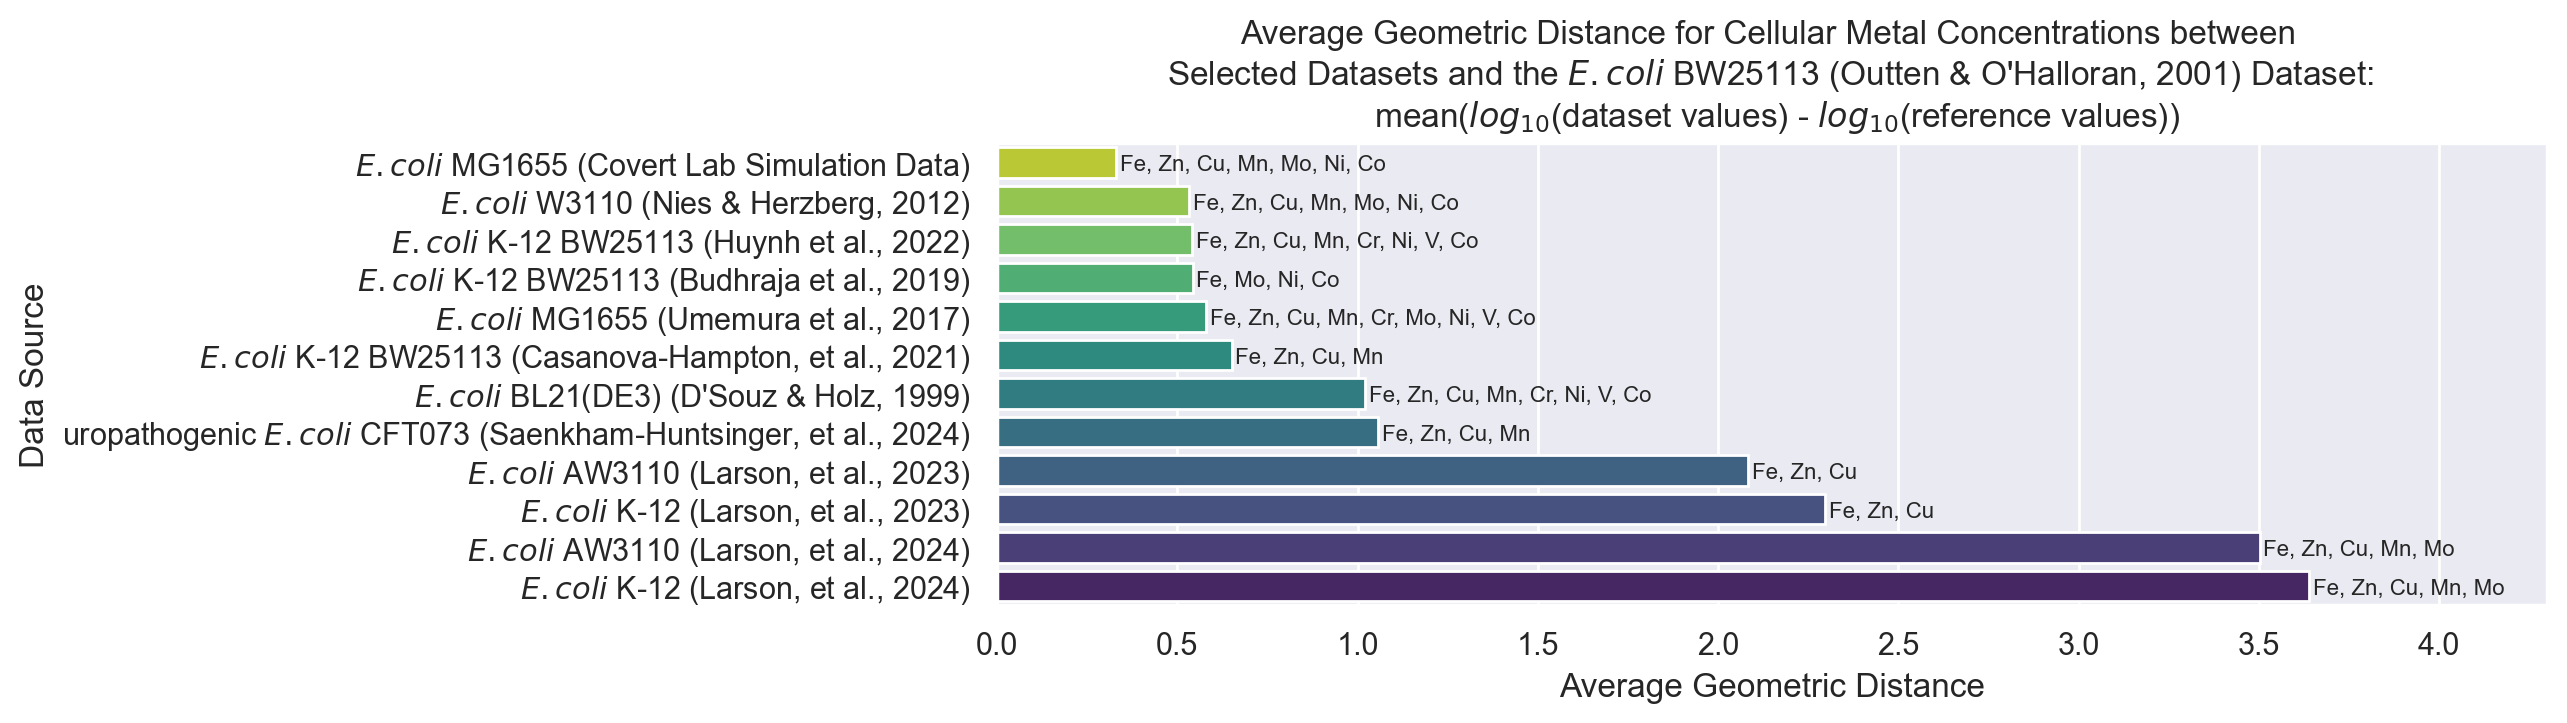

In [39]:
# sort the data by the average geometric distance:
AGD_all_sorted = AGD_all.sort_values("Average Geometric Distance")

# make a 1D plot of the average geometric distances:
plt.figure(dpi=200, figsize=(10, 3))
sns.set(style="darkgrid")
ax = sns.barplot(data=AGD_all_sorted, y="Data Source", x="Average Geometric Distance", palette="viridis_r", hue="Data Source")

# Plot Specs
plot_elements_averaged_over_only(all_data_noOO_all_elements, AGD_all_sorted)
plt.xlim([0, 4.3])
plt.title("Average Geometric Distance for Cellular Metal Concentrations between \nSelected Datasets and the $\t{E. coli}$ BW25113 (Outten & O\'Halloran, 2001) Dataset: \n mean($log_{10}$(dataset values) - $log_{10}$(reference values))")

plt.show()

2.b.ii same as above but with slightly different formatting for the text labels

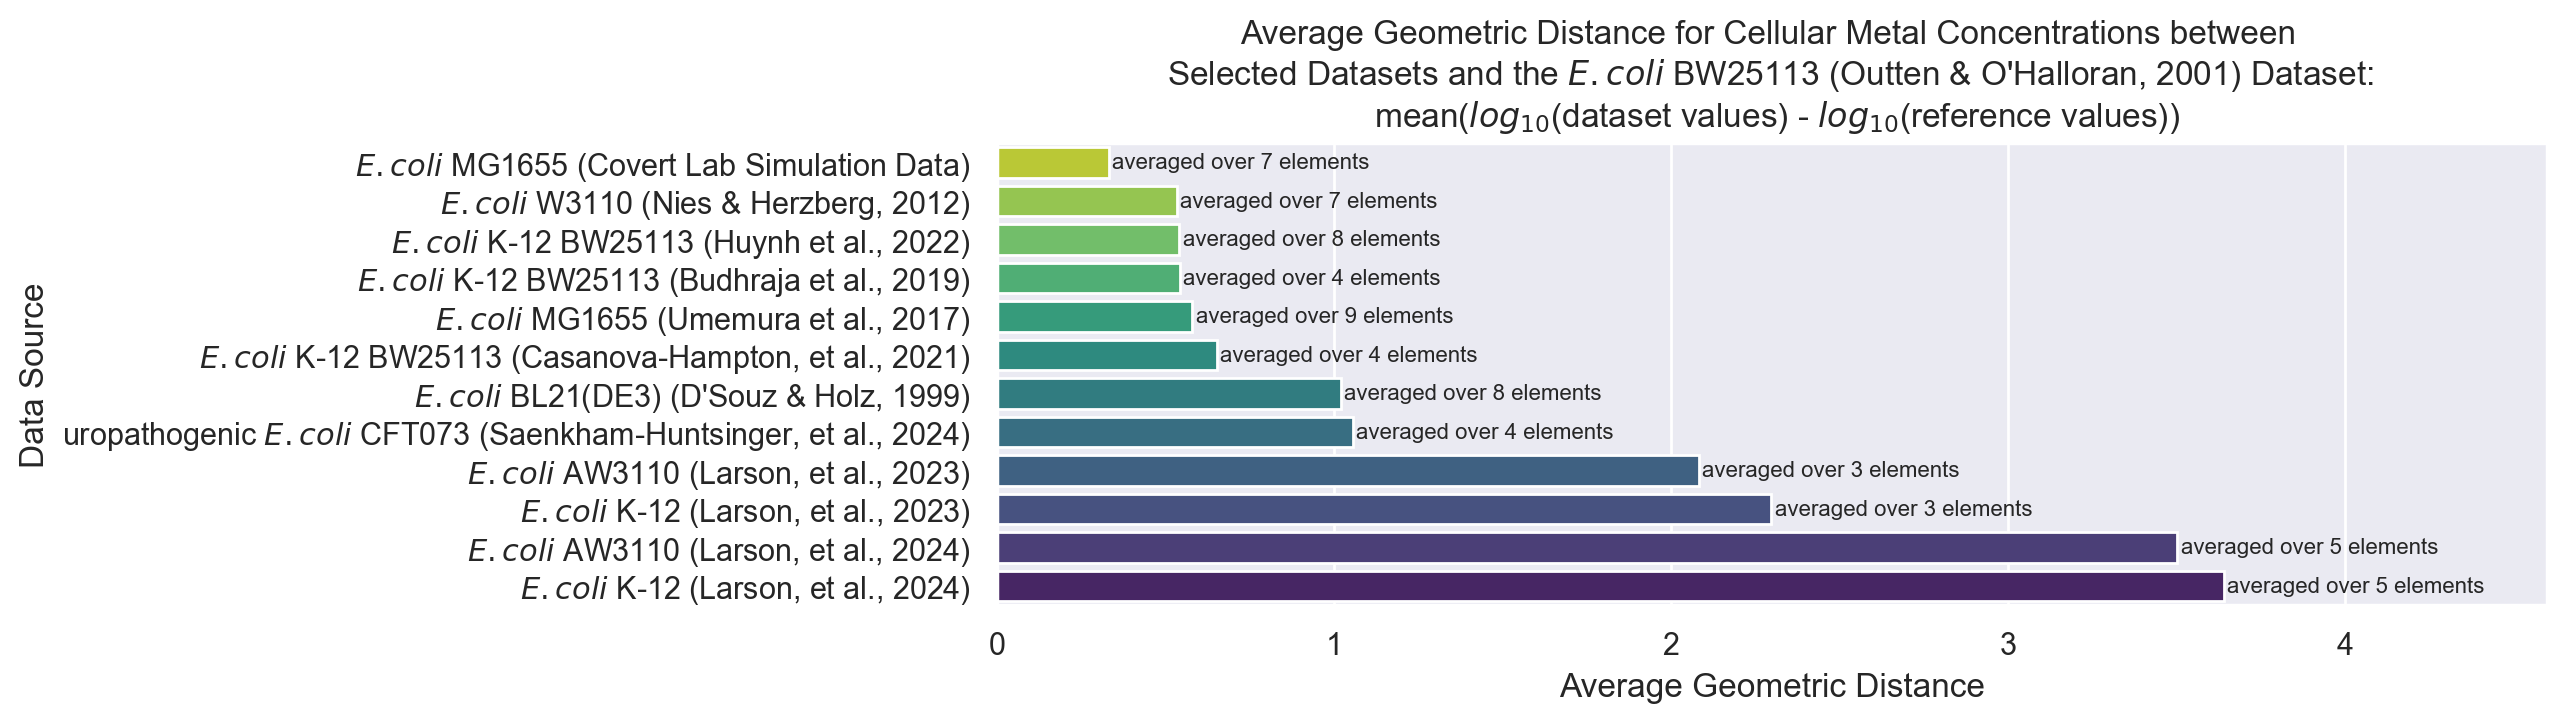

In [40]:
# sort the data by the average geometric distance:
AGD_all_sorted = AGD_all.sort_values("Average Geometric Distance")

# make a 1D plot of the average geometric distances:
plt.figure(dpi=200, figsize=(10, 3))
sns.set(style="darkgrid")
ax = sns.barplot(data=AGD_all_sorted, y="Data Source", x="Average Geometric Distance", palette="viridis_r", hue="Data Source")

# Plot Specs
plot_num_elements_averaged_over_only(all_data_noOO_all_elements, AGD_all_sorted)
plt.xlim([0, 4.6])
plt.title("Average Geometric Distance for Cellular Metal Concentrations between \nSelected Datasets and the $\t{E. coli}$ BW25113 (Outten & O\'Halloran, 2001) Dataset: \n mean($log_{10}$(dataset values) - $log_{10}$(reference values))")

plt.show()

2.b.iii same as above but with a simpler labeling system

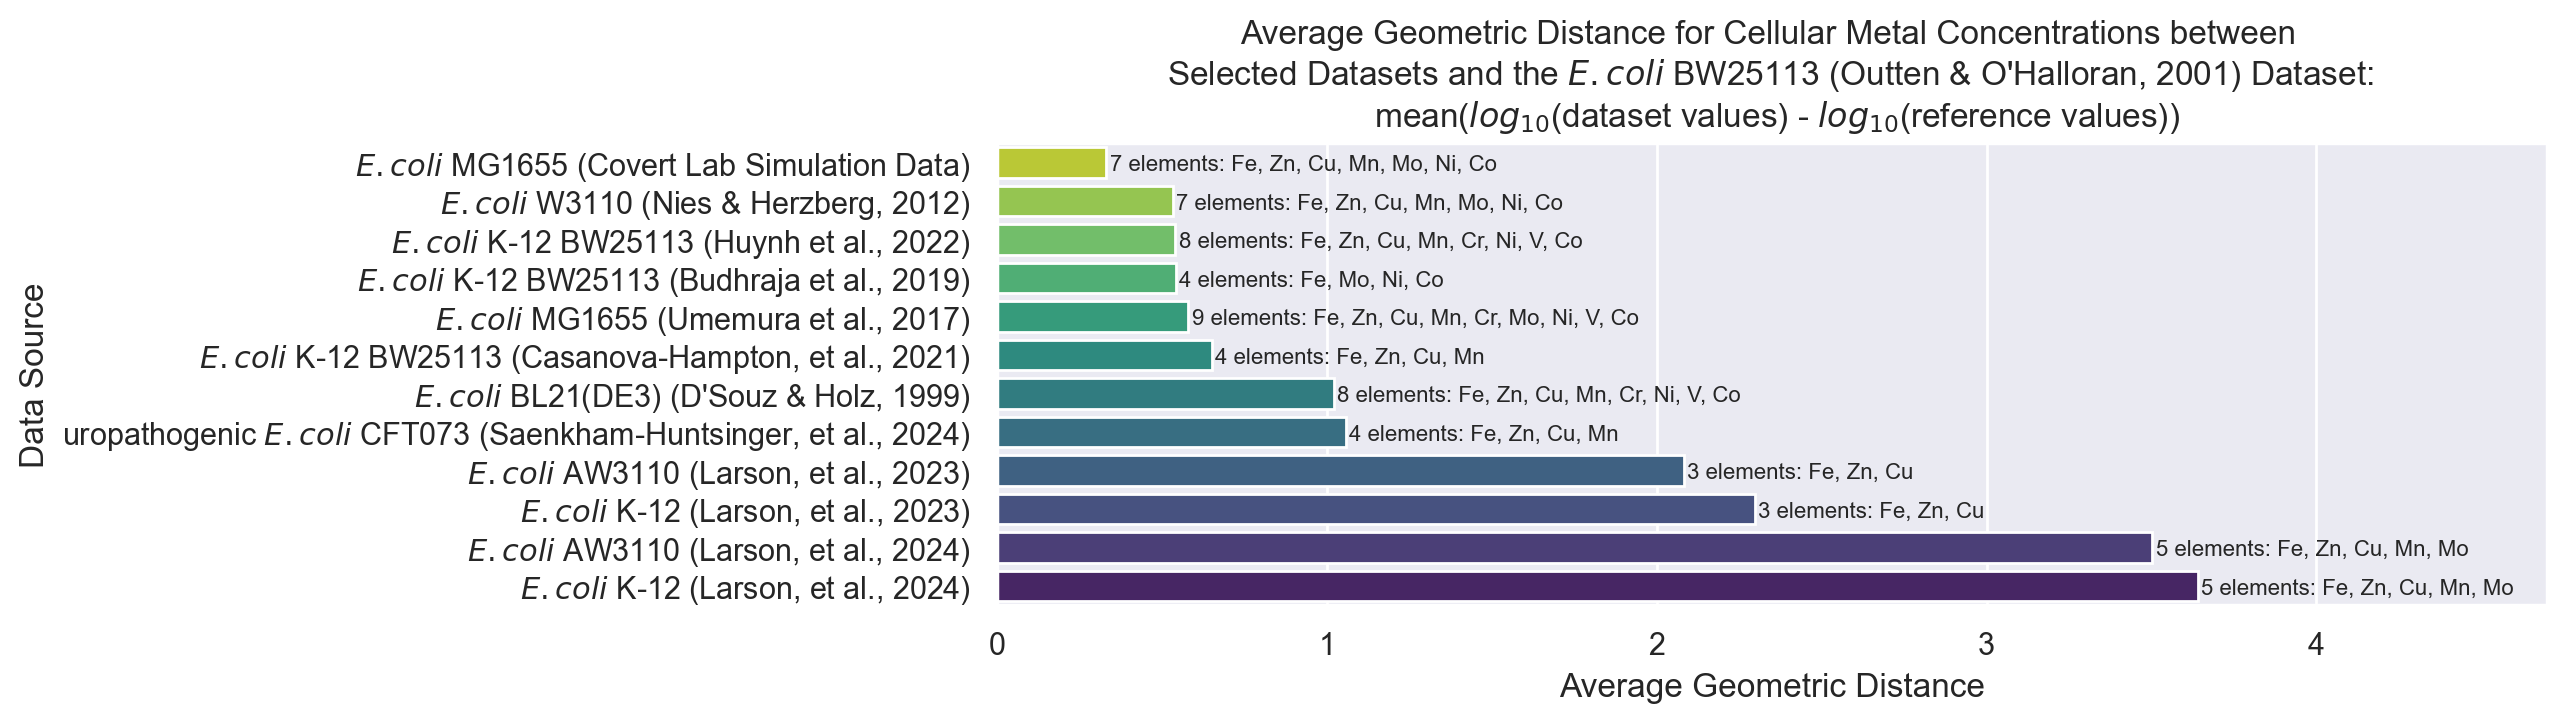

In [41]:
# sort the data by the average geometric distance:
AGD_all_sorted = AGD_all.sort_values("Average Geometric Distance")

# make a 1D plot of the average geometric distances:
plt.figure(dpi=200, figsize=(10, 3))
sns.set(style="darkgrid")
ax = sns.barplot(data=AGD_all_sorted, y="Data Source", x="Average Geometric Distance", palette="viridis_r", hue="Data Source")

# Plot Specs
plot_num_averaged_and_elements(all_data_noOO_all_elements, AGD_all_sorted)
plt.xlim([0, 4.7])
plt.title("Average Geometric Distance for Cellular Metal Concentrations between \nSelected Datasets and the $\t{E. coli}$ BW25113 (Outten & O\'Halloran, 2001) Dataset: \n mean($log_{10}$(dataset values) - $log_{10}$(reference values))")

plt.show()

# 3) Comparing trends for the following elements only: Fe, Zn, Mn, Cu, Mo and Ni 

## 3.a: Scatter plot comparing all data sources that have data for the following elements: Fe, Zn, Mn, Cu, Mo, and Ni


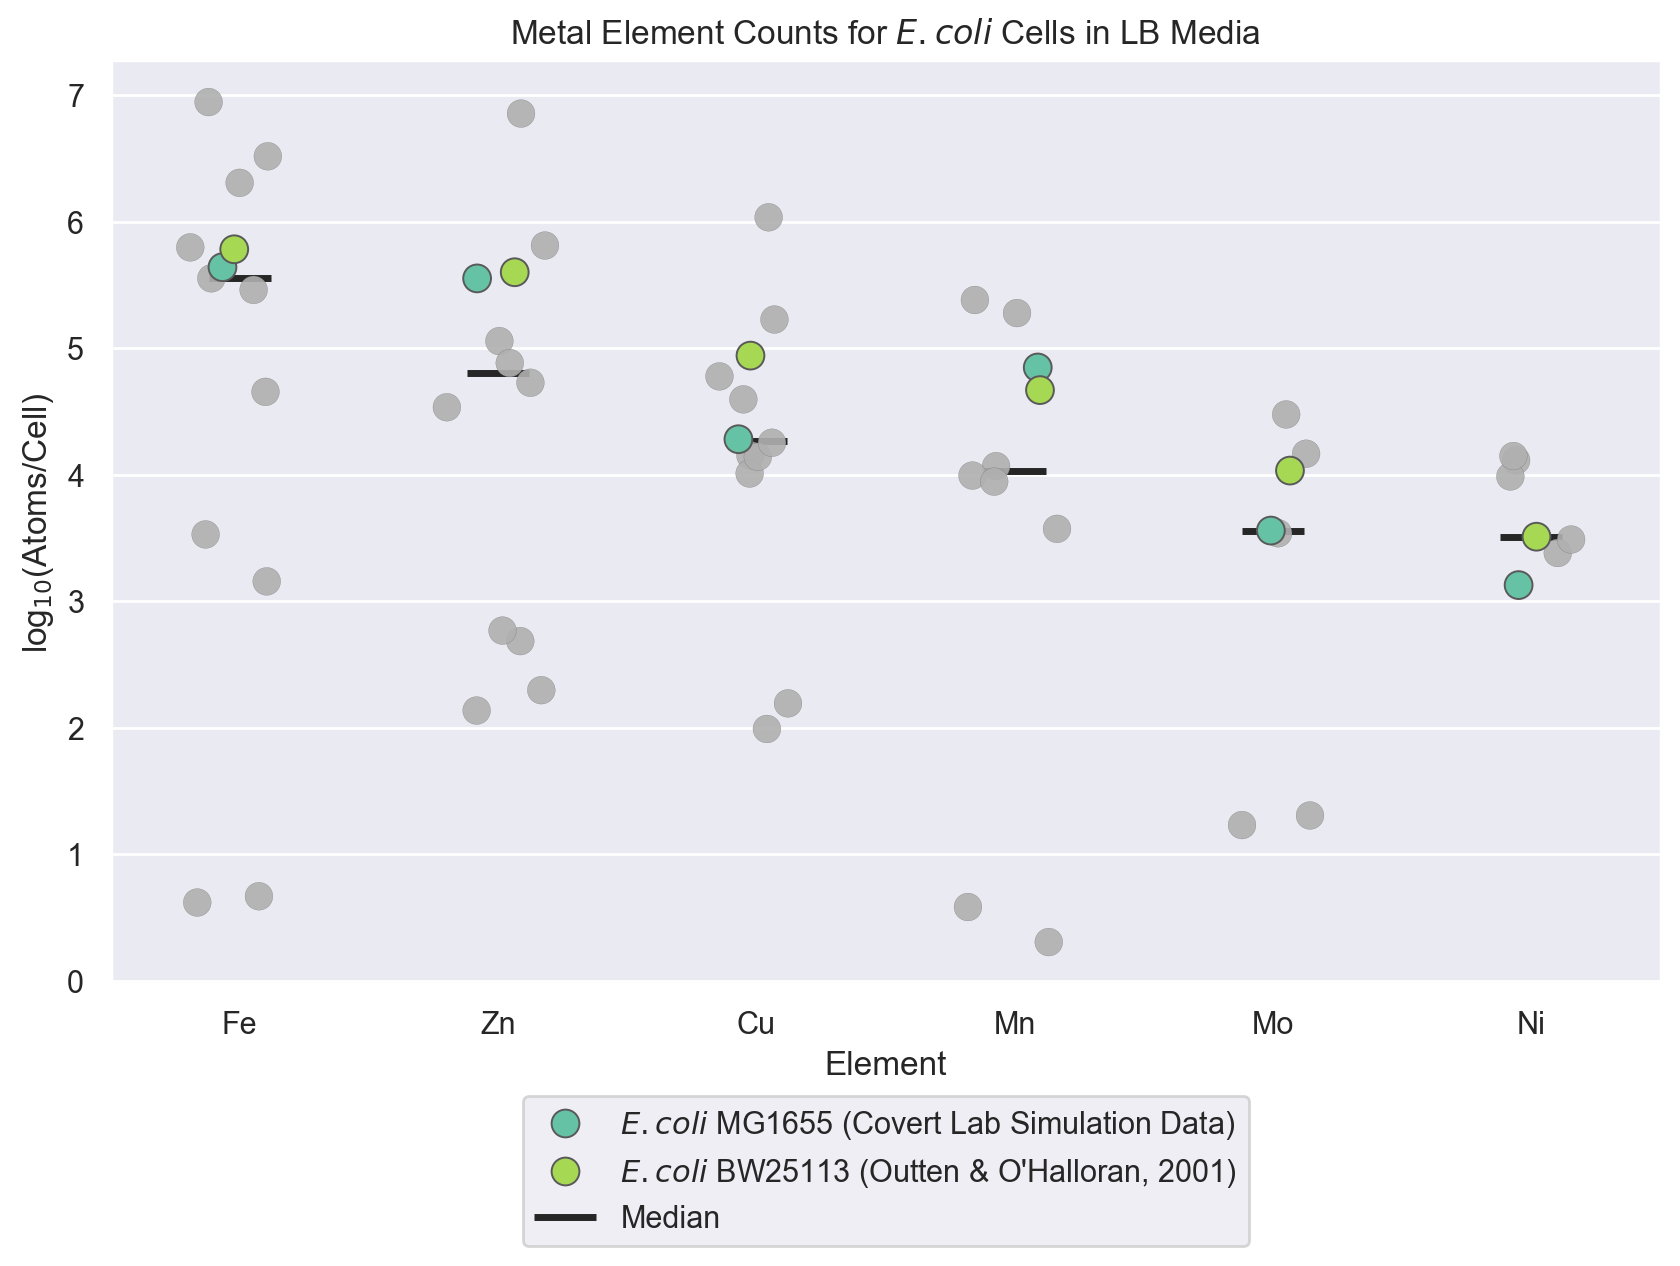

In [42]:
# Cryus' requests (as of 09/11/2024):

# take out Co, Cr, and V from the data sorted by medians:
lb_data_no_V = lb_exp_data_sorted_medians.filter(pl.col("Element") != "V")
lb_data_no_CrV = lb_data_no_V.filter(pl.col("Element") != "Cr")
lb_data_no_CrCoV = lb_data_no_CrV.filter(pl.col("Element") != "Co")

# split the ground truth and simulation data from the rest of the literature data: 
GT_sim_LB_data_woCrCoV = lb_data_no_CrCoV["Element", "$\t{E. coli}$ MG1655 (Covert Lab Simulation Data)", "$\t{E. coli}$ BW25113 (Outten & O\'Halloran, 2001)"]
exp_LB_data_woCrCoV = lb_data_no_CrCoV[:,[0,3,4,5,6,7,8,9,10,11,12,13]]

# reshape the data for graphs
GT_sim_LB_data_woCrCoV_long = GT_sim_LB_data_woCrCoV.melt(id_vars=["Element"], variable_name="Data Source", value_name="log$_{10}$(Atoms/Cell)")
GT_sim_LB_data_long_pd = GT_sim_LB_data_woCrCoV_long.to_pandas()
exp_LB_data_woCrCoV_long = exp_LB_data_woCrCoV.melt(id_vars=["Element"], variable_name="Data Source", value_name="log$_{10}$(Atoms/Cell)")
exp_LB_data_woCrCoV_long_pd = exp_LB_data_woCrCoV_long.to_pandas()

# remove the same elements from the medians data:
medians_df_no_V = medians_df.filter(pl.col("Element") != "V")
medians_df_no_CrV = medians_df_no_V.filter(pl.col("Element") != "Cr")
medians_df_no_CrCoV = medians_df_no_CrV.filter(pl.col("Element") != "Co")

# reshape the medians data for graphing: 
long_medians_woCrCoV = medians_df_no_CrCoV.melt(id_vars=["Element"], variable_name="Data Source", value_name="log$_{10}$(Atoms/Cell)")
long_medians_woCrCoV_pd = long_medians_woCrCoV.to_pandas()

# plot the figure
plt.figure(dpi=200, figsize=(10, 6))

# add custom colors for plotting:
custom_palette3 = (sns.color_palette("Set2")[0:1] + sns.color_palette("Set2")[4:5])
grey_palette3 = ["#B0B0B0","#B0B0B0","#B0B0B0","#B0B0B0","#B0B0B0","#B0B0B0","#B0B0B0","#B0B0B0","#B0B0B0","#B0B0B0", "#B0B0B0"]

# add a jitter seed: (Good seeds: 0, 3, 4, 7, 10)
np.random.seed(10)

# plot the data: 
ax = sns.stripplot(data=exp_LB_data_woCrCoV_long_pd, y="log$_{10}$(Atoms/Cell)", x="Element", hue="Data Source", palette=grey_palette3, s=10, linewidth=.1, alpha=.9, jitter=.2) 
ax = sns.stripplot(data=GT_sim_LB_data_long_pd, y="log$_{10}$(Atoms/Cell)", x="Element",  hue="Data Source", s=10, alpha=1, palette=custom_palette3, jitter=.1, linewidth=.7,) #DC143C

# add a small marker at the median value of each element: 
ax = sns.pointplot(
     data=long_medians_woCrCoV_pd, y="log$_{10}$(Atoms/Cell)", x="Element", hue="Data Source", linestyle="none", errorbar=None,
     marker="_", markersize=22, markeredgewidth=2.5, palette='dark:black')

# Plot Specs: 
plt.title("Metal Element Counts for $\t{E. coli}$ Cells in LB Media")

# Get the handles and labels from the plot
handles, labels = ax.get_legend_handles_labels()

# Specify the entries to include in the legend
included_labels = ["$\t{E. coli}$ MG1655 (Covert Lab Simulation Data)", '$\t{E. coli}$ BW25113 (Outten & O\'Halloran, 2001)', "Median"]  
included_handles = [handles[labels.index(label)] for label in included_labels]

# Create the legend manually with the labels and handles
plt.legend(included_handles, included_labels, loc='upper right')
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.3))

plt.show()

## 3.b: Bar Plots 

In [43]:
# split the data up into the Outten & O'Halloran data and the rest of the literature data:
OO_data_woCrCoV = lb_data_no_CrCoV.select(["Element", "$\t{E. coli}$ BW25113 (Outten & O\'Halloran, 2001)"])
all_data_noOO_woCrCoV = lb_data_no_CrCoV.drop("$\t{E. coli}$ BW25113 (Outten & O\'Halloran, 2001)")

# compute geometric distances (GDs) for datasets that have values for any of the 6 elements: FE, Zn, Mn, Cu, Mo, Ni
GD_woCrCoV, AGD_woCrCoV = avg_geometric_distance_1D_log10(OO_data_woCrCoV, all_data_noOO_woCrCoV)

3.b.i: bar graph of sources containing at least one of the following elements: Fe, Zn, Mn, Cu, Mo, Ni

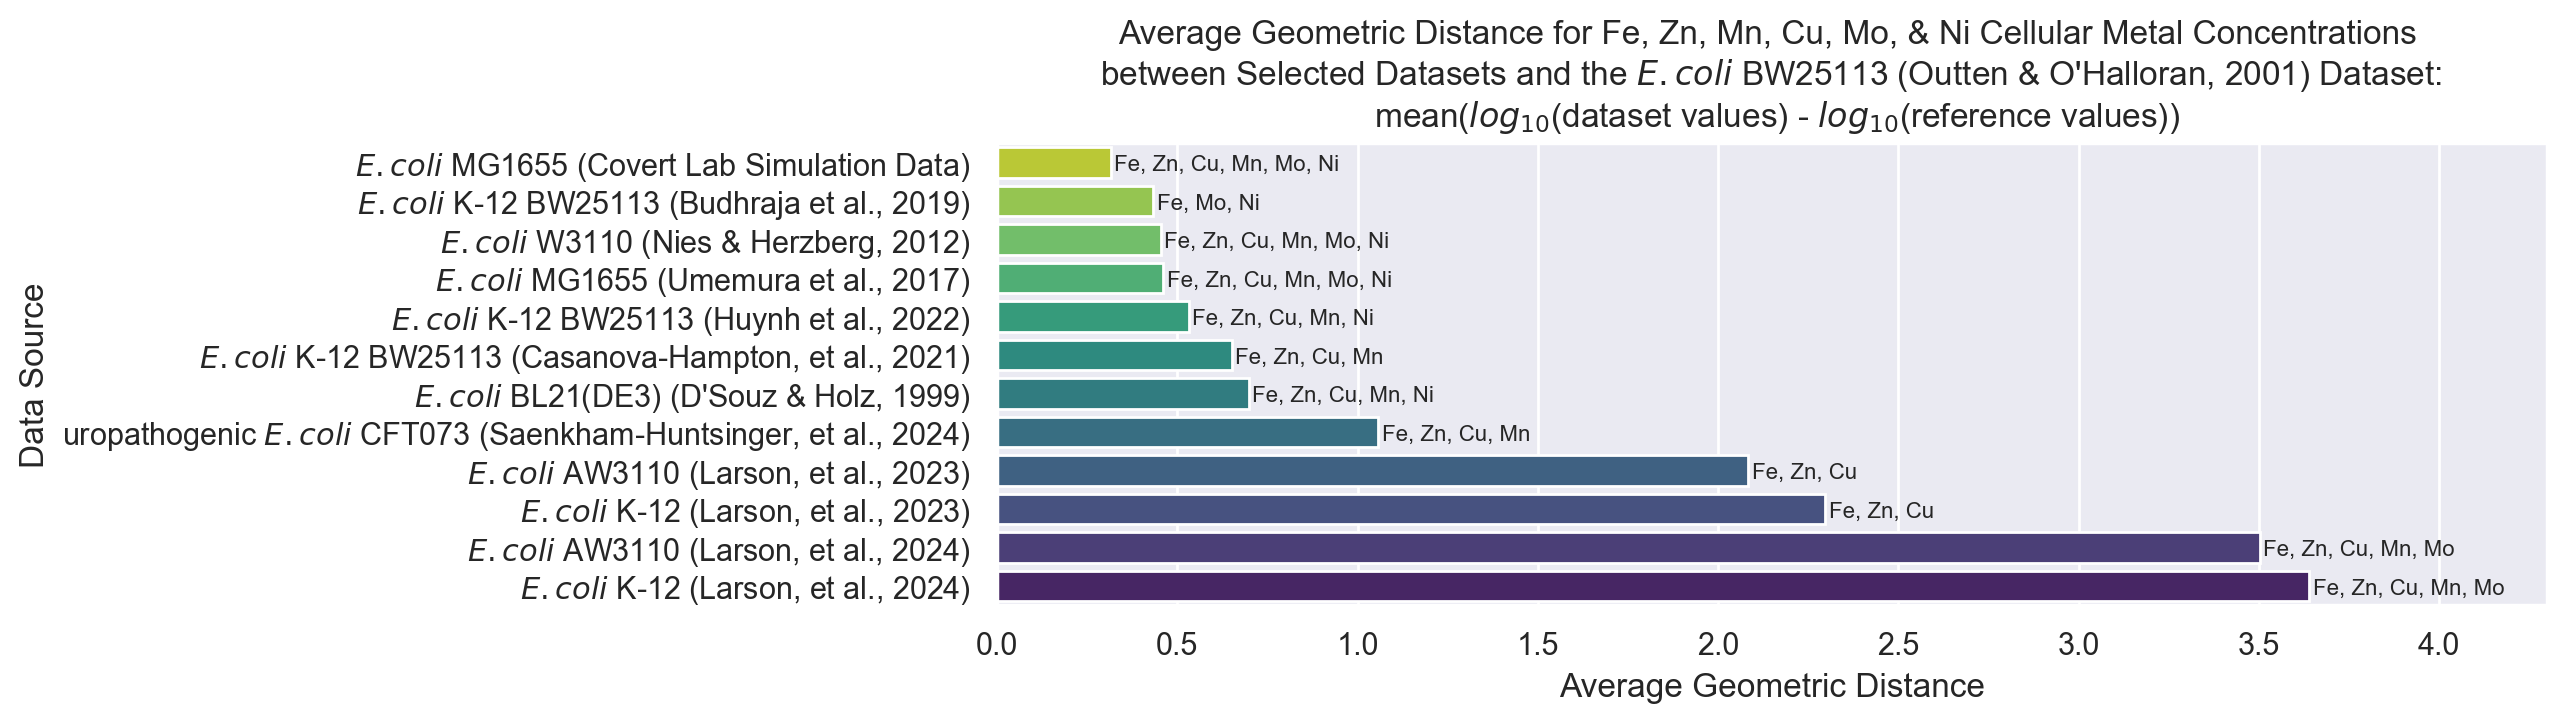

In [44]:
# sort the data by the average geometric distance:
AGD_woCrCoV_sorted = AGD_woCrCoV.sort_values("Average Geometric Distance")

# make a 1D plot of the average geometric distances:
plt.figure(dpi=200, figsize=(10, 3)) 
sns.set(style="darkgrid")
ax = sns.barplot(data=AGD_woCrCoV_sorted, y="Data Source", x="Average Geometric Distance", palette="viridis_r", hue="Data Source")

# Plot Specs
plot_elements_averaged_over_only(all_data_noOO_woCrCoV, AGD_woCrCoV_sorted)
plt.xlim([0, 4.3])
plt.title("Average Geometric Distance for Fe, Zn, Mn, Cu, Mo, & Ni Cellular Metal Concentrations \nbetween Selected Datasets and the $\t{E. coli}$ BW25113 (Outten & O\'Halloran, 2001) Dataset: \n mean($log_{10}$(dataset values) - $log_{10}$(reference values))")

plt.show()

3.b.ii: same as above but with different data labels

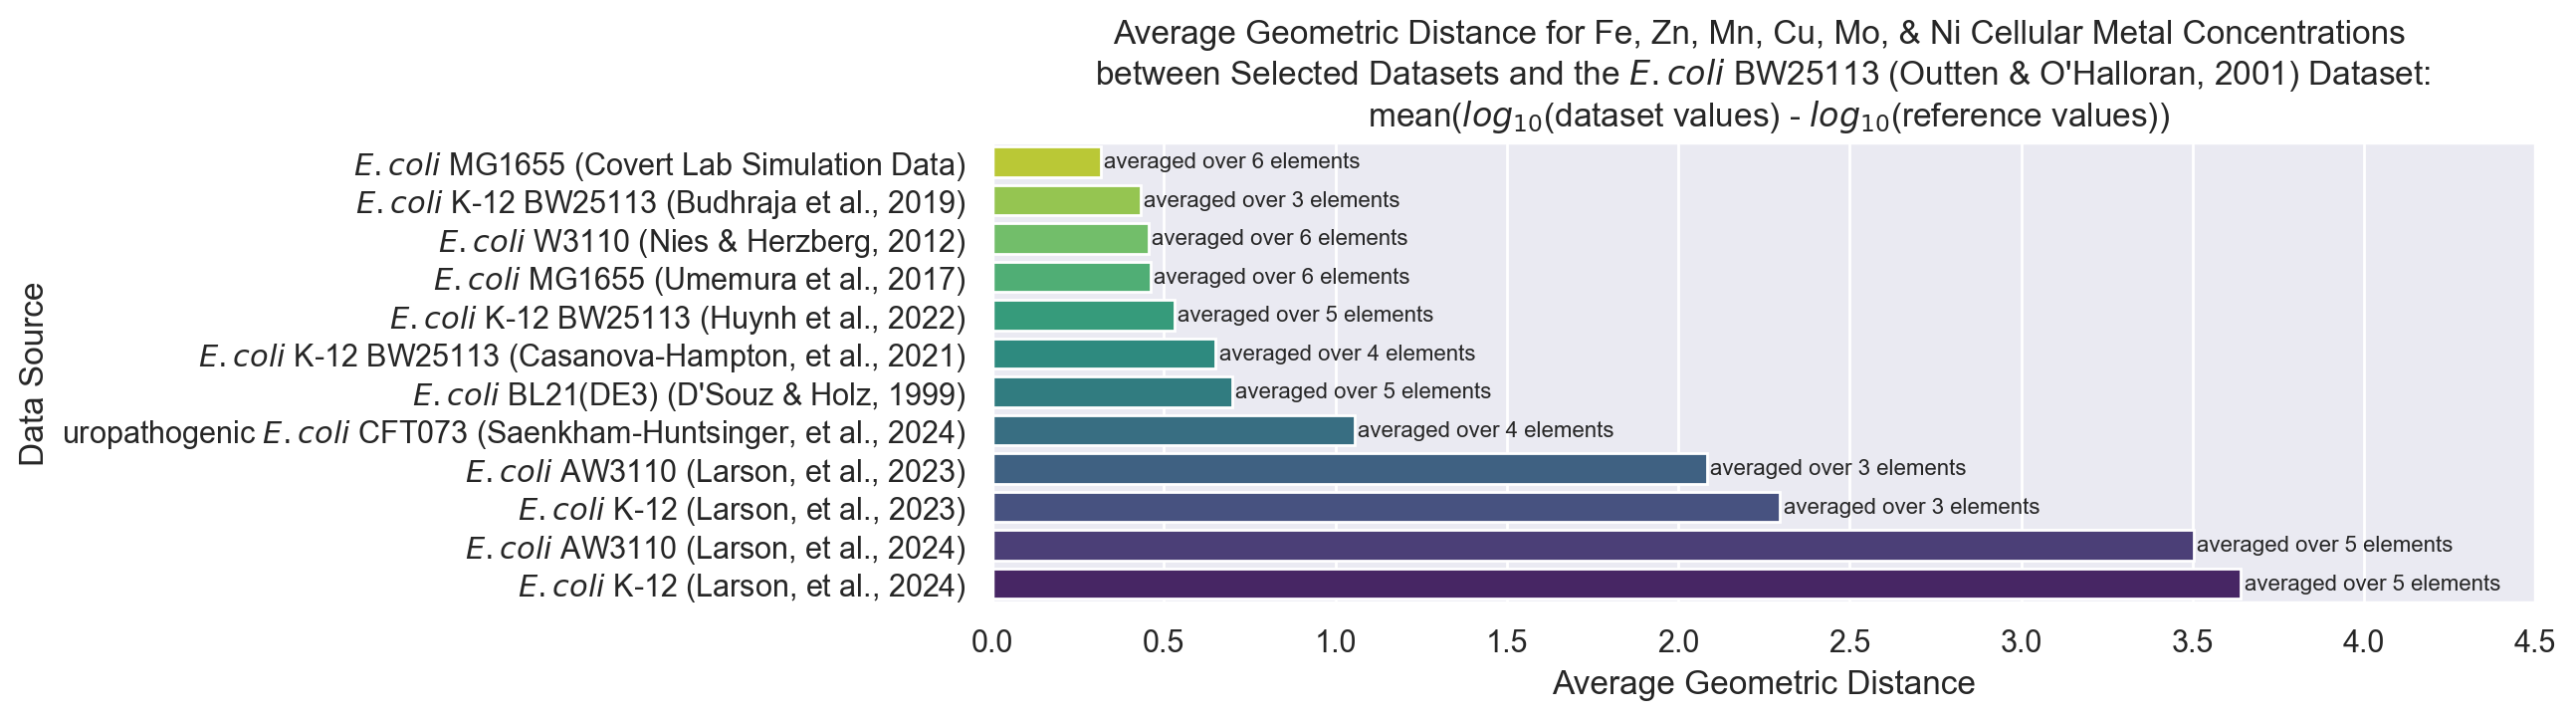

In [45]:
# sort the data by the average geometric distance:
AGD_woCrCoV_sorted = AGD_woCrCoV.sort_values("Average Geometric Distance")

# make a 1D plot of the average geometric distances:
plt.figure(dpi=200, figsize=(10, 3)) 
sns.set(style="darkgrid")
ax = sns.barplot(data=AGD_woCrCoV_sorted, y="Data Source", x="Average Geometric Distance", palette="viridis_r", hue="Data Source")

# Plot Specs
plot_num_elements_averaged_over_only(all_data_noOO_woCrCoV, AGD_woCrCoV_sorted)
plt.xlim([0, 4.5])
plt.title("Average Geometric Distance for Fe, Zn, Mn, Cu, Mo, & Ni Cellular Metal Concentrations \nbetween Selected Datasets and the $\t{E. coli}$ BW25113 (Outten & O\'Halloran, 2001) Dataset: \n mean($log_{10}$(dataset values) - $log_{10}$(reference values))")

plt.show()

3.b.iii: same as above but with different data labels

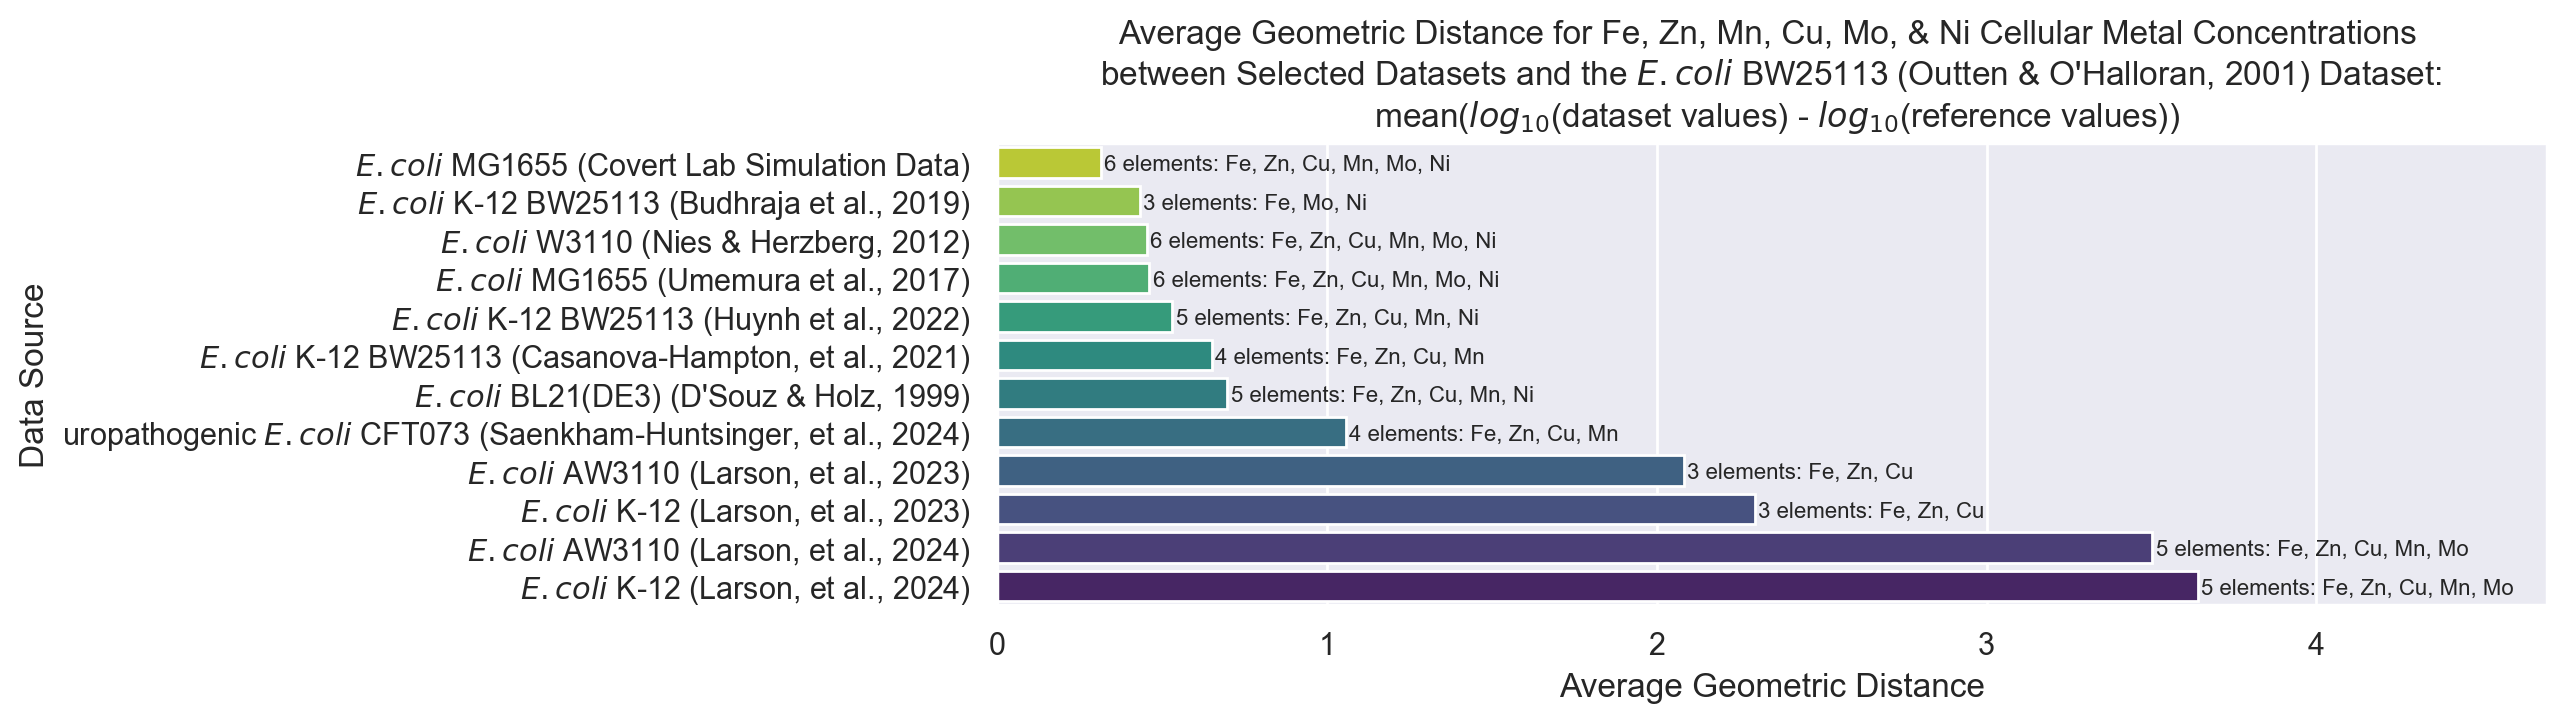

In [46]:
# sort the data by the average geometric distance:
AGD_woCrCoV_sorted = AGD_woCrCoV.sort_values("Average Geometric Distance")

# make a 1D plot of the average geometric distances:
plt.figure(dpi=200, figsize=(10, 3)) 
sns.set(style="darkgrid")
ax = sns.barplot(data=AGD_woCrCoV_sorted, y="Data Source", x="Average Geometric Distance", palette="viridis_r", hue="Data Source")

# Plot Specs
plot_num_averaged_and_elements(all_data_noOO_woCrCoV, AGD_woCrCoV_sorted)
plt.xlim([0, 4.7])
plt.title("Average Geometric Distance for Fe, Zn, Mn, Cu, Mo, & Ni Cellular Metal Concentrations \nbetween Selected Datasets and the $\t{E. coli}$ BW25113 (Outten & O\'Halloran, 2001) Dataset: \n mean($log_{10}$(dataset values) - $log_{10}$(reference values))")

plt.show()

3.c: Same as 3.b but with fewer datasets plotted

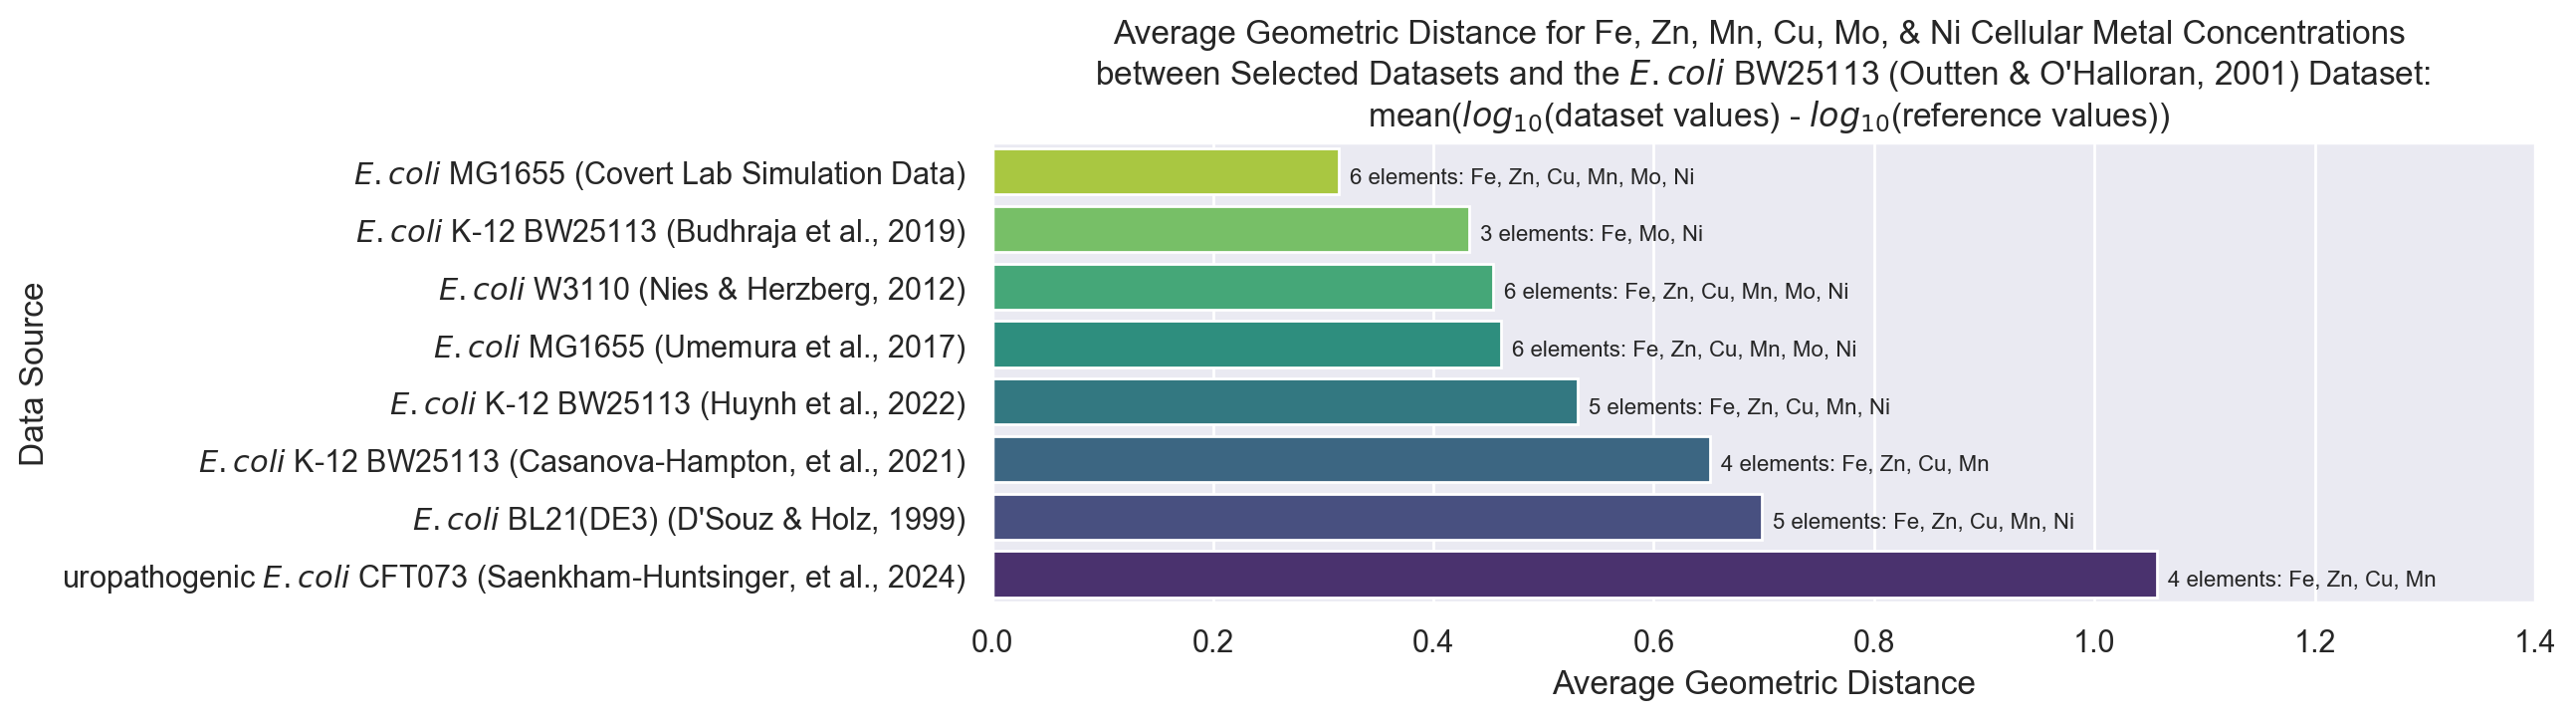

In [47]:
# sort the data by the average geometric distance:
AGD_woCrCoV_sorted = AGD_woCrCoV.sort_values("Average Geometric Distance")
# drop the last four Data Sources from the rest:
smallest_AGD_woCrCoV_sorted = AGD_woCrCoV_sorted[:-4]
smallest_all_data_noOO_woCrCoV = all_data_noOO_woCrCoV[:,:-4]

# make a 1D plot of the average geometric distances:
plt.figure(dpi=200, figsize=(10, 3)) 
sns.set(style="darkgrid")
ax = sns.barplot(data=smallest_AGD_woCrCoV_sorted, y="Data Source", x="Average Geometric Distance", palette="viridis_r", hue="Data Source")

# Plot Specs
plot_num_averaged_and_elements(smallest_all_data_noOO_woCrCoV, smallest_AGD_woCrCoV_sorted)
plt.xlim([0, 1.4])
plt.title("Average Geometric Distance for Fe, Zn, Mn, Cu, Mo, & Ni Cellular Metal Concentrations \nbetween Selected Datasets and the $\t{E. coli}$ BW25113 (Outten & O\'Halloran, 2001) Dataset: \n mean($log_{10}$(dataset values) - $log_{10}$(reference values))")

plt.show()

## 3.d: Bar plot for data sources that contain each of the following elements: Fe, Zn, Mn, Cu, Mo, & Ni

In [48]:
# compute for datasets that have values for all the following 6 elements: FE, Zn, Mn, Cu, Mo, Ni
all_data_woCrCoV_noNANs = all_data_noOO_woCrCoV.select([col for col in all_data_noOO_woCrCoV.columns if not all_data_noOO_woCrCoV[col].is_null().any()])
GD_noNANs_woCrCoV, AGD_noNANs_woCrCoV = avg_geometric_distance_1D_log10(OO_data_woCrCoV, all_data_woCrCoV_noNANs)

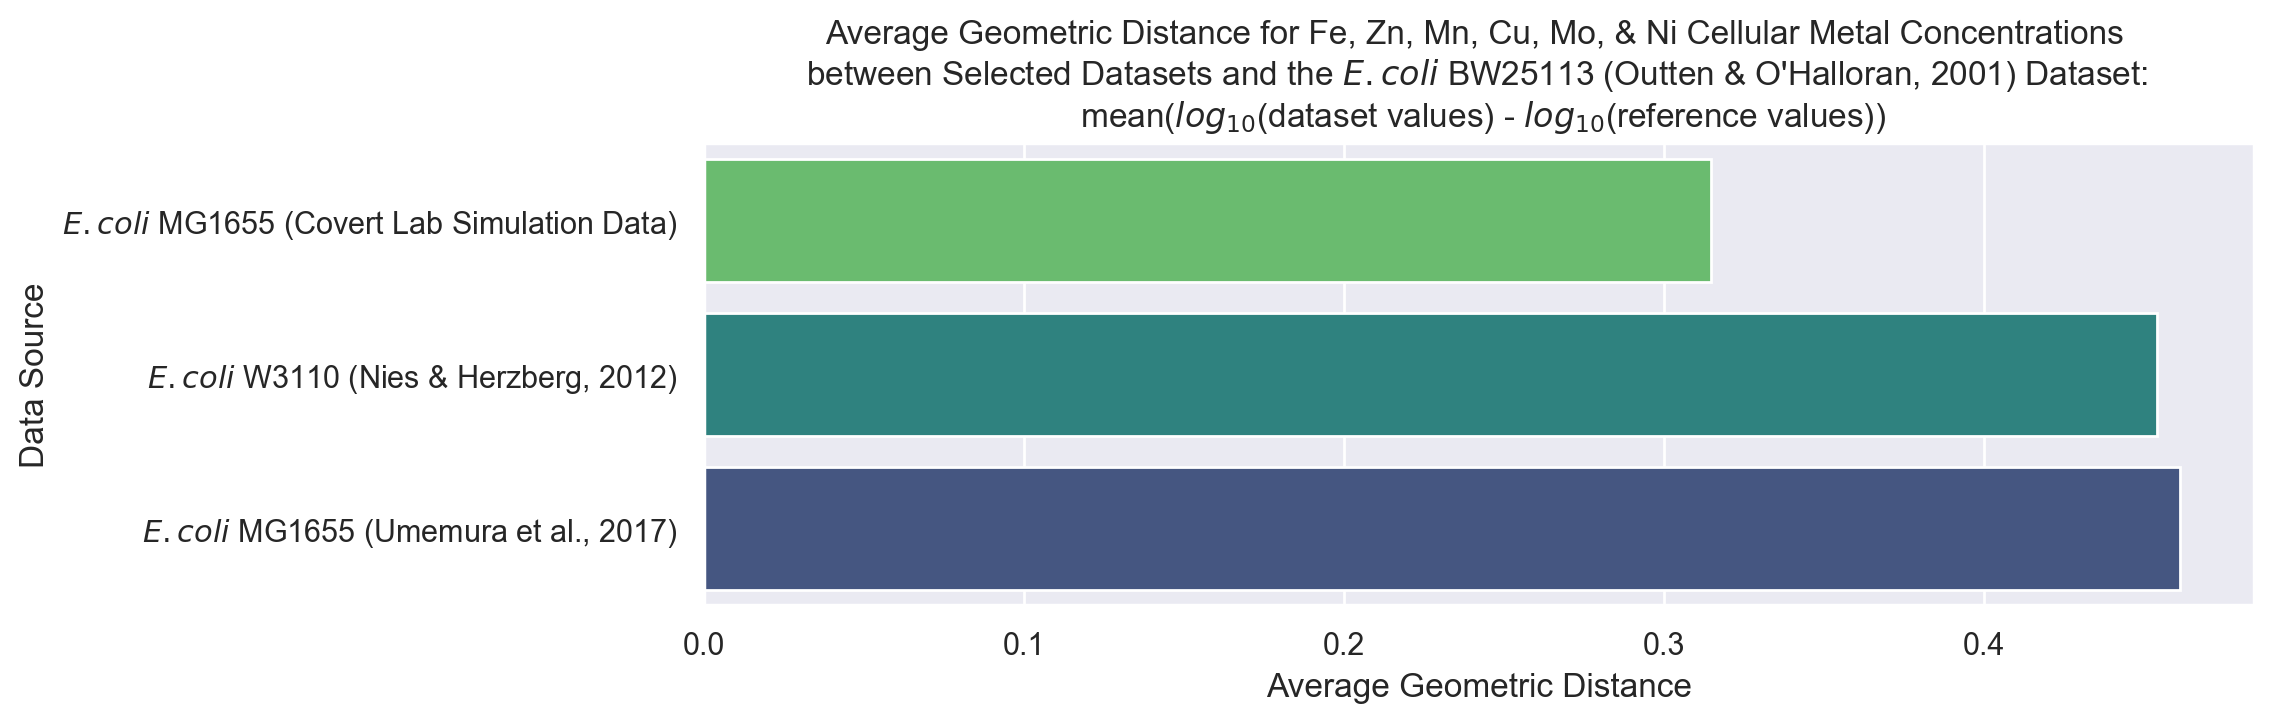

In [49]:
# sort the data by the average geometric distance:
AGD_noNANs_woCrCoV_sorted = AGD_noNANs_woCrCoV.sort_values("Average Geometric Distance")

# make a 1D plot of the average geometric distances:
plt.figure(dpi=200, figsize=(10, 3)) 
sns.set(style="darkgrid")
ax = sns.barplot(data=AGD_noNANs_woCrCoV_sorted, y="Data Source", x="Average Geometric Distance", palette="viridis_r", hue="Data Source")

# Plot Specs: 
plt.title("Average Geometric Distance for Fe, Zn, Mn, Cu, Mo, & Ni Cellular Metal Concentrations \nbetween Selected Datasets and the $\t{E. coli}$ BW25113 (Outten & O\'Halloran, 2001) Dataset: \n mean($log_{10}$(dataset values) - $log_{10}$(reference values))")

plt.show()

## Cyrus' 2nd request for 10/23/2024: "Make a new plot that’s just the absolute geometric distance to the “gold standard”, for Fe, Zn, Mn, Cu and Total as well."

Note that the graphs for this are all made from the data used in the graph below: 

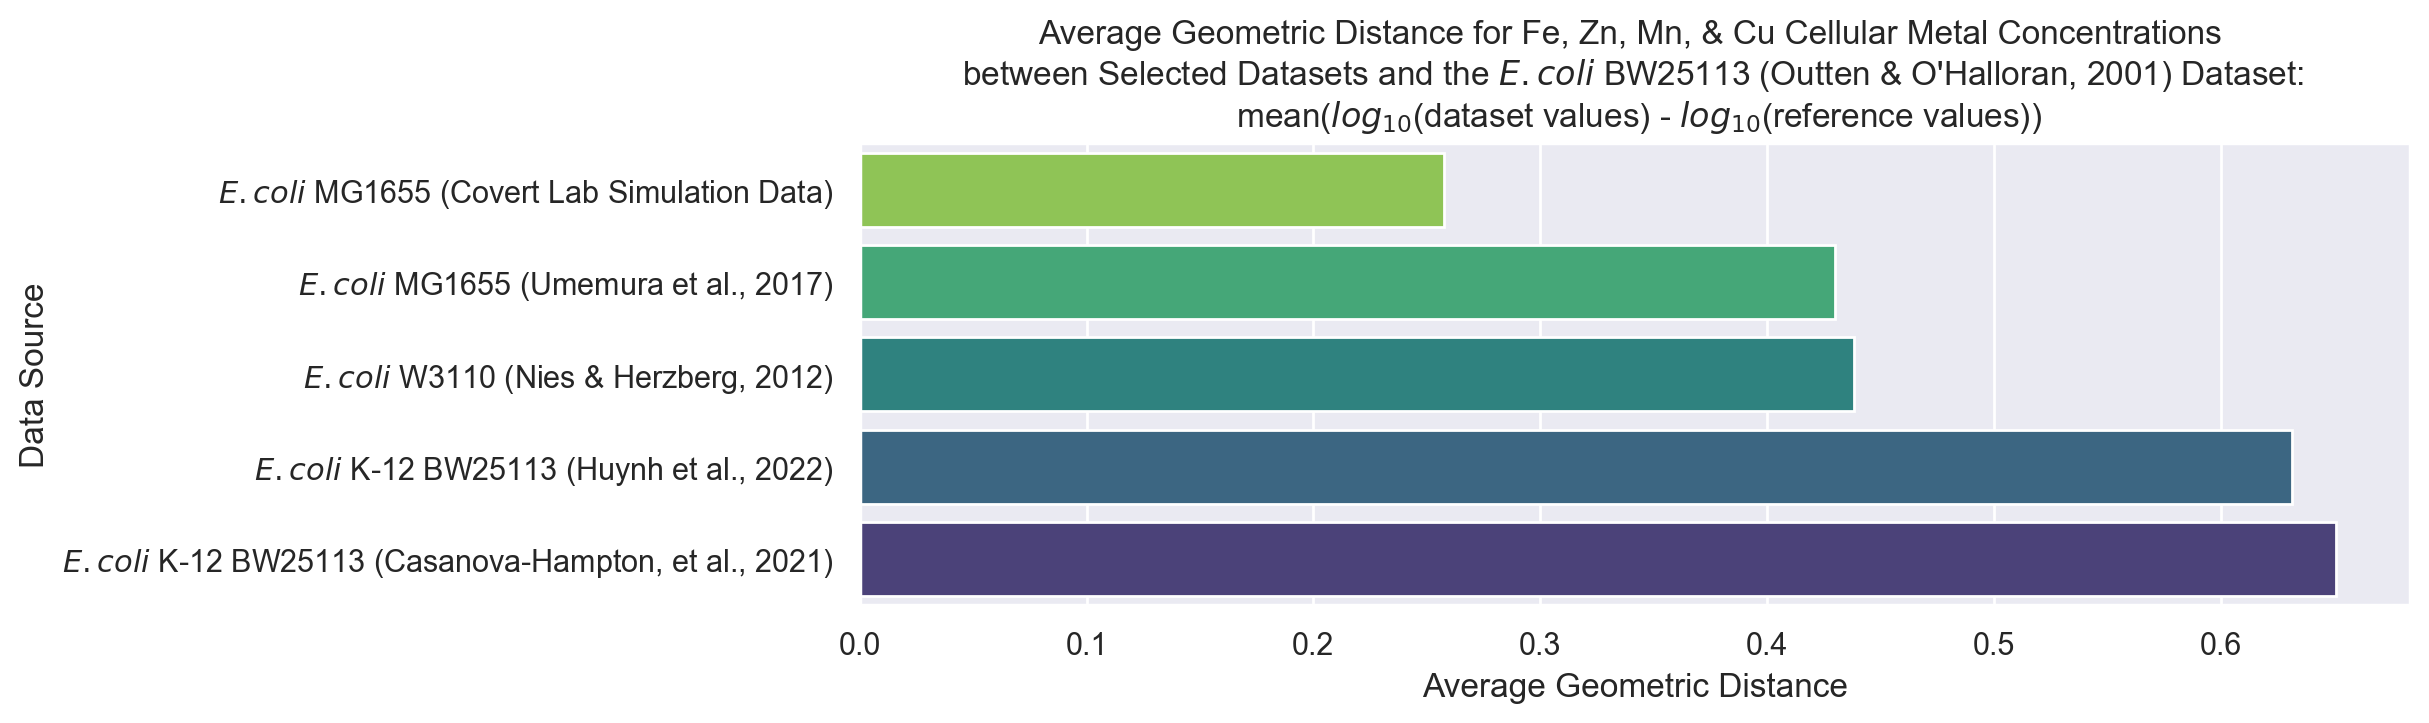

In [51]:
# sort the data by the average geometric distance:
AGD_noNANs_woCrCoVNiMo_sorted = AGD_noNANs_woCrCoVNiMo.sort_values("Average Geometric Distance")

# drop the last four Data Sources from the rest:
smallest_AGD_noNANs_woCrCoVNiMo_sorted = AGD_noNANs_woCrCoVNiMo_sorted[:-4]

# make a 1D plot of the average geometric distances:
plt.figure(dpi=200, figsize=(10, 3)) 
sns.set(style="darkgrid") # reset the style back to darkgrid
ax = sns.barplot(data=smallest_AGD_noNANs_woCrCoVNiMo_sorted, y="Data Source", x="Average Geometric Distance", palette="viridis_r", hue="Data Source")

# Plot Specs:
plt.title("Average Geometric Distance for Fe, Zn, Mn, & Cu Cellular Metal Concentrations \nbetween Selected Datasets and the $\t{E. coli}$ BW25113 (Outten & O\'Halloran, 2001) Dataset: \n mean($log_{10}$(dataset values) - $log_{10}$(reference values))")

plt.show()

Use the geometric distances calculated from the same data used in the graph above: 

In [89]:
# calculate the total of the geometric distances for Fe, Zn, Mn, Cu for each dataset:
totals = GD_woCrCoVNiMo.select(pl.all().exclude("Element").sum()).with_columns(pl.lit("Total").alias("Element"))

# Add the "Element" column as "Total" to match original DataFrame structure
totals = totals.with_columns(pl.lit("Total").alias("Element"))

# Rearrange the totals row columns to match the original DataFrame's column order
totals = totals.select(GD_woCrCoVNiMo.columns)

# Concatenate the totals row to the original DataFrame
GD_woCrCoVNiMo_with_total = pl.concat([GD_woCrCoVNiMo, totals], how="vertical")
GD_woCrCoVNiMo_with_total

shape: (5, 10)
┌─────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ Element ┆ $	{E.       ┆ $	{E.      ┆ $	{E.      ┆ … ┆ $	{E.      ┆ uropathog ┆ $	{E.      ┆ $	{E.      │
│ ---     ┆ coli}$     ┆ coli}$    ┆ coli}$    ┆   ┆ coli}$    ┆ enic $	{E. ┆ coli}$    ┆ coli}$    │
│ str     ┆ MG1655     ┆ MG1655    ┆ K-12      ┆   ┆ K-12      ┆ coli}$    ┆ K-12      ┆ AW3110    │
│         ┆ (Covert    ┆ (Umemura  ┆ BW25113   ┆   ┆ BW25113   ┆ CFT…      ┆ (Larson,  ┆ (Larson,  │
│         ┆ La…        ┆ e…        ┆ (Huy…     ┆   ┆ (Cas…     ┆ ---       ┆ et …      ┆ e…        │
│         ┆ ---        ┆ ---       ┆ ---       ┆   ┆ ---       ┆ f64       ┆ ---       ┆ ---       │
│         ┆ f64        ┆ f64       ┆ f64       ┆   ┆ f64       ┆           ┆ f64       ┆ f64       │
╞═════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ Fe      ┆ 0.141547   ┆ 0.735223  ┆ 0.014928  ┆ … ┆ 0.229792  ┆ 1.163941  ┆ 5.165495  ┆ 5.115852  │
│ Zn      ┆ 0.048699   ┆ 0.211244  ┆ 1.067545  ┆ … ┆ 0.717893  ┆ 1.254721  ┆ 2.916912  ┆ 2.833415  │
│ Cu      ┆ 0.660987   ┆ 0.164237  ┆ 0.345949  ┆ … ┆ 0.932383  ┆ 1.093736  ┆ 2.952145  ┆ 2.749761  │
│ Mn      ┆ 0.178893   ┆ 0.609031  ┆ 1.097022  ┆ … ┆ 0.723721  ┆ 0.712568  ┆ 4.364621  ┆ 4.087409  │
│ Total   ┆ 1.030126   ┆ 1.719735  ┆ 2.525445  ┆ … ┆ 2.603789  ┆ 4.224966  ┆ 15.399173 ┆ 14.786437 │
└─────────┴────────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

Style #1

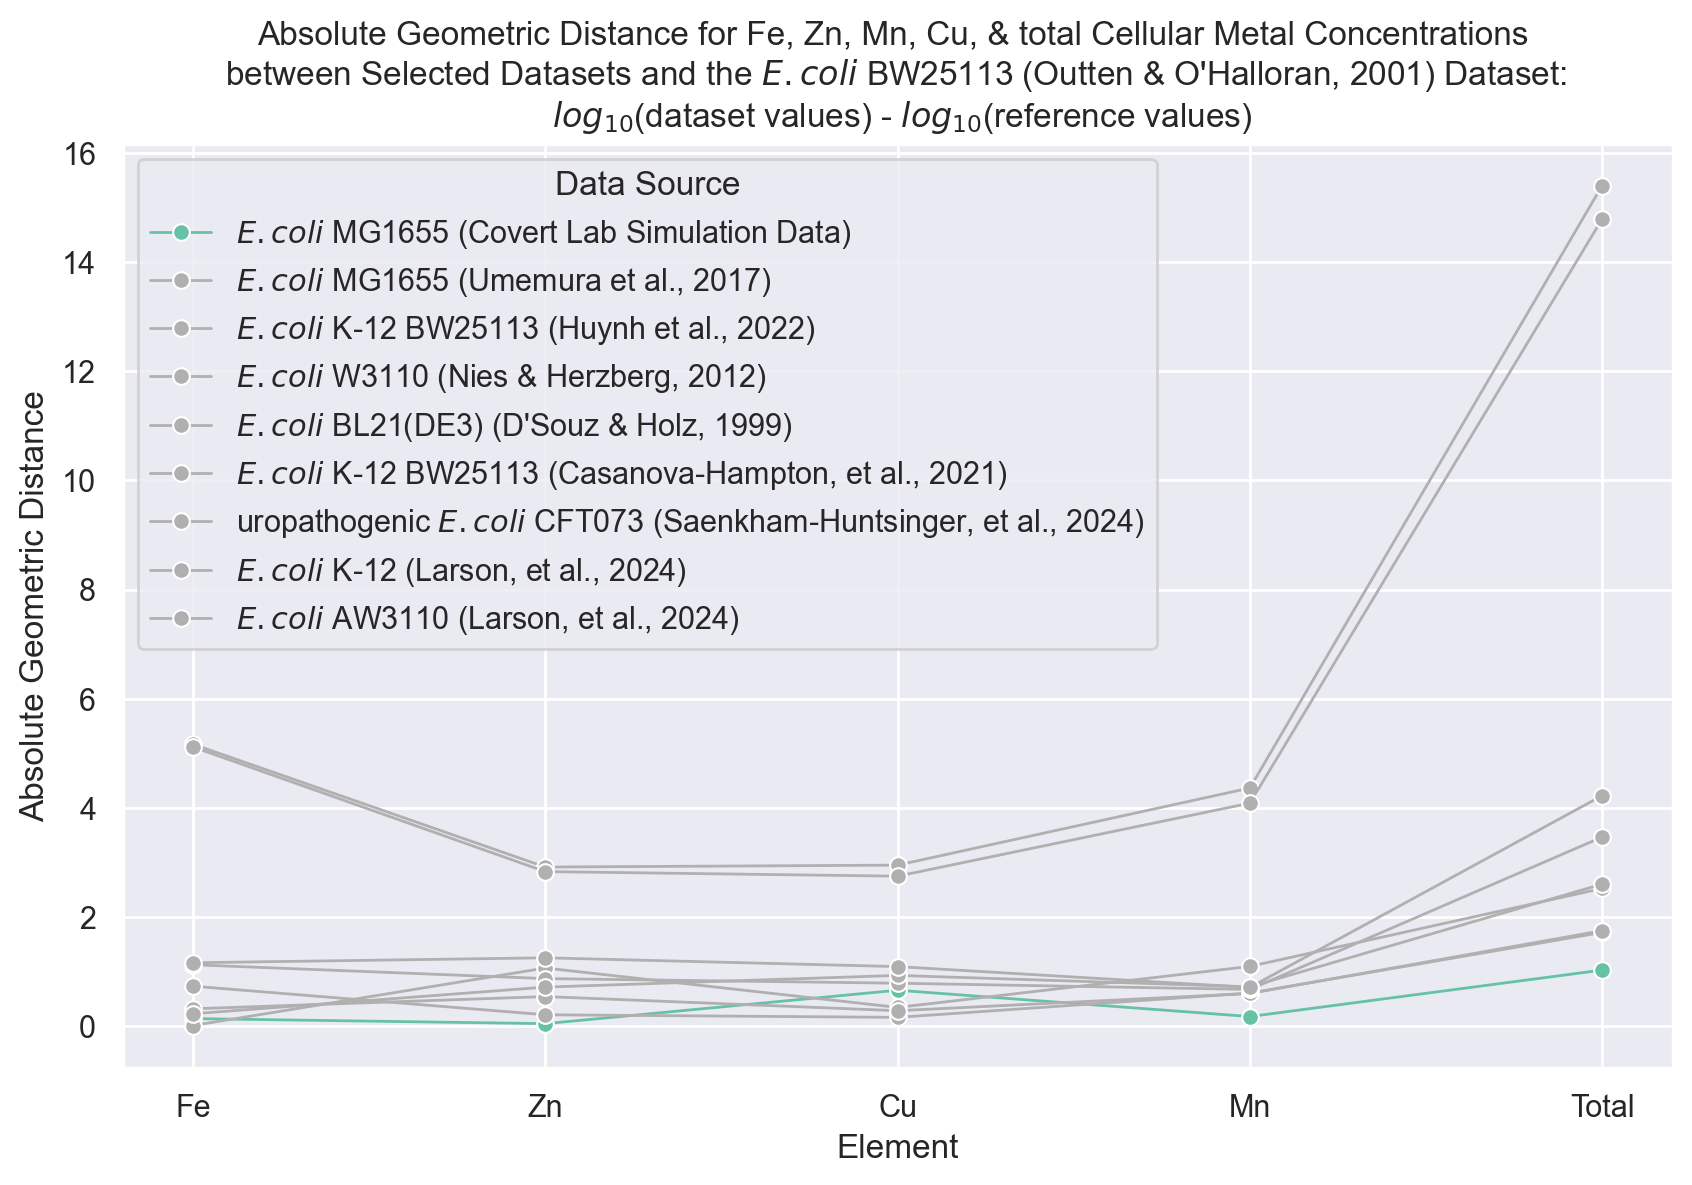

In [81]:
# plot the data with the total on a horizontal plot, with the elements on the x-axis and the datasources as different colors
plt.figure(dpi=200, figsize=(10, 6))
sns.set(style="darkgrid")

# take the last four data sources out of the data:

# put the data in long form so that the data sources can be a separate variable: 
data_long = GD_woCrCoVNiMo_with_total.melt(id_vars="Element", variable_name="Data Source", value_name="Geometric Distance").to_pandas()

# assign colors and marker styles: 
custom_palette4 = (sns.color_palette("Set2")[0:1])
grey_palette3 = ["#B0B0B0"] * len(GD_woCrCoVNiMo_with_total.columns)
marker_styles = ['o', 's', 'D', '^', 'v', 'P', 'X', '8', '*', 'h', '+']  # Customize as needed

#Create a color list for plotting
color_list = []
unique_sources = data_long['Data Source'].unique()
for source in unique_sources:
    if source == unique_sources[0]:  # First data source
        color_list.append(custom_palette4[0])  # Use custom color
    else:
        color_list.append(grey_palette3[0])  # Use grey color

# plot the data:
sns.lineplot(data=data_long, x="Element", y="Geometric Distance", hue="Data Source", palette=color_list, linewidth=1, marker='o')

# Plot Specs:
plt.title("Absolute Geometric Distance for Fe, Zn, Mn, Cu, & total Cellular Metal Concentrations \nbetween Selected Datasets and the $\t{E. coli}$ BW25113 (Outten & O\'Halloran, 2001) Dataset: \n $log_{10}$(dataset values) - $log_{10}$(reference values)")
plt.xlabel("Element")
plt.ylabel("Absolute Geometric Distance")
plt.legend(title="Data Source")
plt.show()

# Style #2

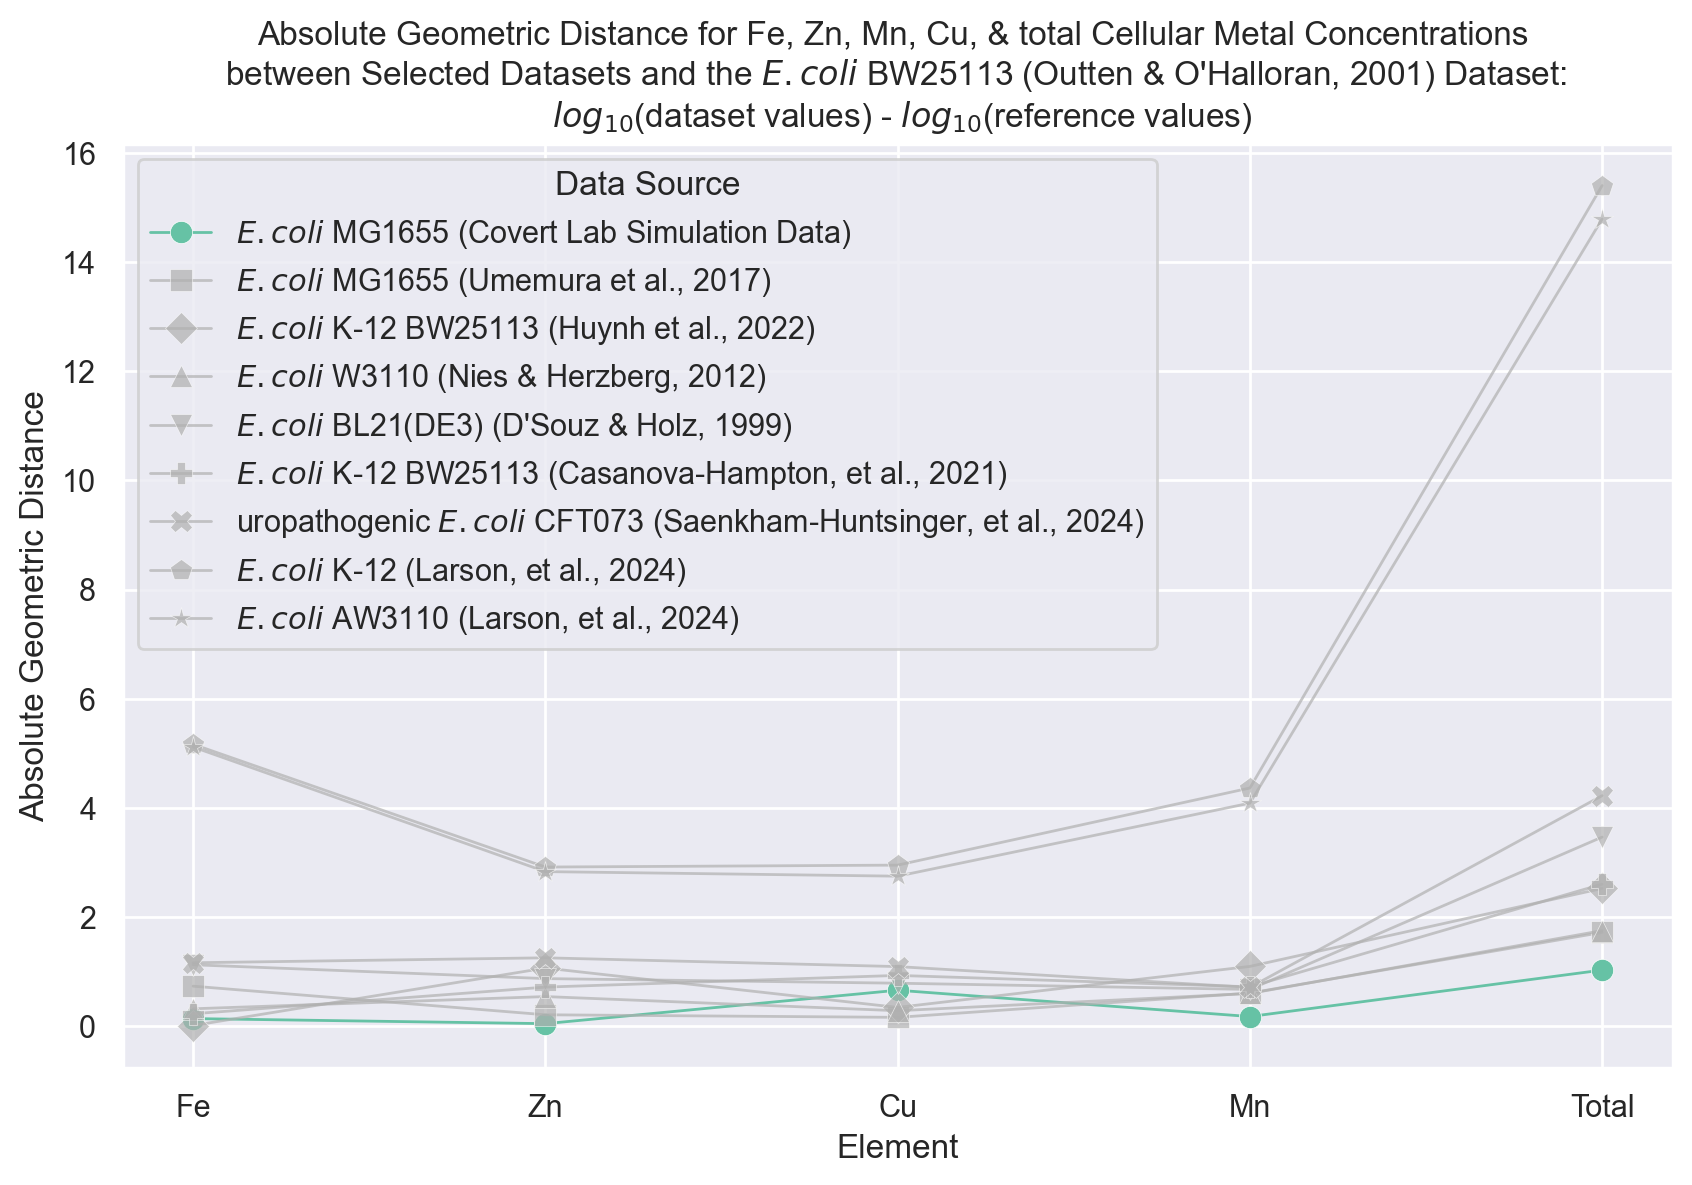

In [92]:
# plot the data with the total on a horizontal plot, with the elements on the x-axis and the datasources as different colors
plt.figure(dpi=200, figsize=(10, 6))
sns.set(style="darkgrid")


# put the data in long form so that the data sources can be a separate variable: 
data_long = GD_woCrCoVNiMo_with_total.melt(id_vars="Element", variable_name="Data Source", value_name="Geometric Distance").to_pandas()

# assign colors and marker styles: 
custom_palette4 = (sns.color_palette("Set2")[0:1])
grey_palette3 = ["#B0B0B0"] * len(GD_woCrCoVNiMo_with_total.columns)
marker_styles = ['o', 's', 'D', '^', 'v', 'P', 'X', 'p', '*', 'h', '+']  # Customize as needed


unique_sources = data_long['Data Source'].unique()
for i, source in enumerate(unique_sources):
    subset = data_long[data_long['Data Source'] == source]
    if i == 0:
        color = custom_palette4[0]  # First data source color
        alpha = 1
    else:
        color = grey_palette3[0]  # Grey color for other data sources
        alpha = 0.7  # Lower alpha for other data sources

    # Use the appropriate marker and alpha value for each dataset
    sns.lineplot(data=subset, x="Element", y="Geometric Distance", 
                 label=source, marker=marker_styles[i % len(marker_styles)], 
                 color=color, markersize=8, linewidth=1, markeredgewidth=0.25, alpha=alpha)  


# Plot Specs:
plt.title("Absolute Geometric Distance for Fe, Zn, Mn, Cu, & total Cellular Metal Concentrations \nbetween Selected Datasets and the $\t{E. coli}$ BW25113 (Outten & O\'Halloran, 2001) Dataset: \n $log_{10}$(dataset values) - $log_{10}$(reference values)")
plt.xlabel("Element")
plt.ylabel("Absolute Geometric Distance")
plt.legend(title="Data Source")
plt.show()

# Style #3

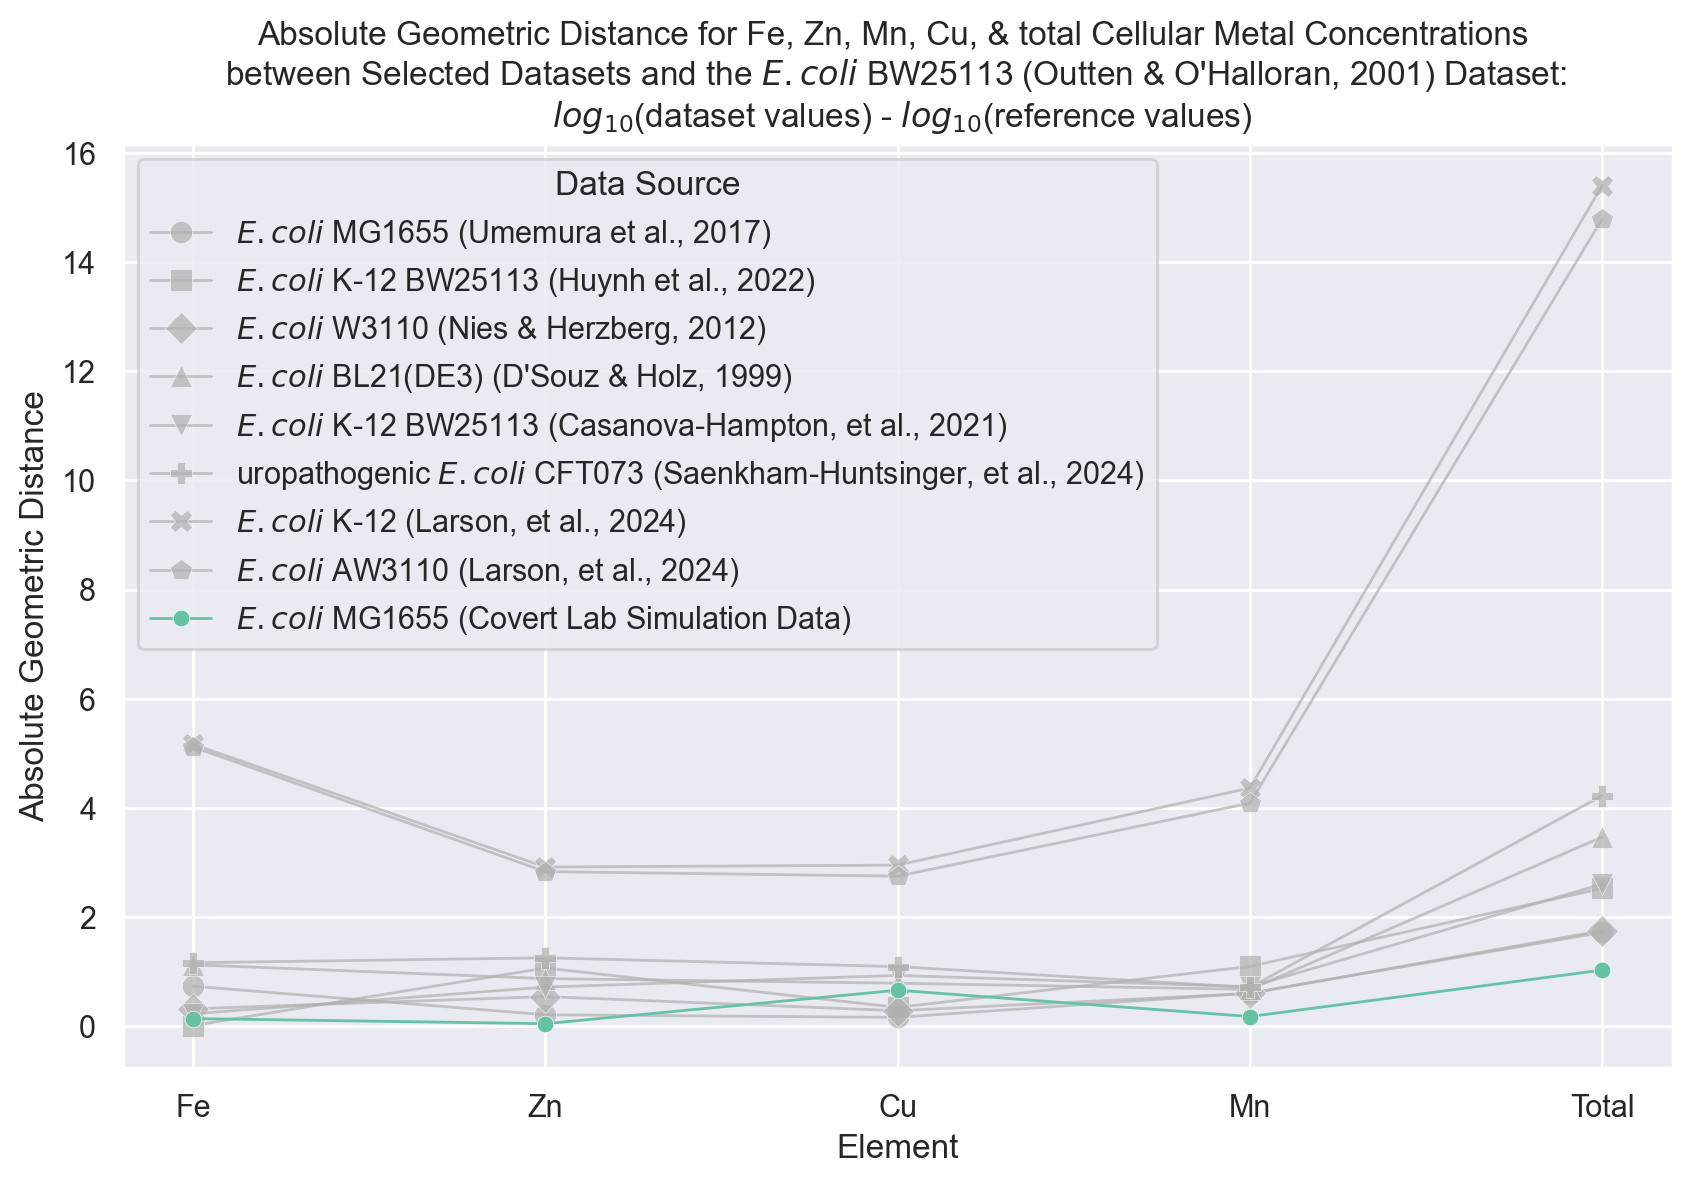

In [109]:
# plot the data with the total on a horizontal plot, with the elements on the x-axis and the datasources as different colors
plt.figure(dpi=200, figsize=(10, 6))
sns.set(style="darkgrid")

# rearrange the data to have the first data source as a separate data source:
GD_woCrCoVNiMo_with_total_sim_data = GD_woCrCoVNiMo_with_total["Element", "$\t{E. coli}$ MG1655 (Covert Lab Simulation Data)"]
GD_woCrCoVNiMo_with_total_exp_data = GD_woCrCoVNiMo_with_total[:,[0,2,3,4,5,6,7,8,9]]

# put the data in long form so that the data sources can be a separate variable: 
data_long_sim = GD_woCrCoVNiMo_with_total_sim_data.melt(id_vars="Element", variable_name="Data Source", value_name="Geometric Distance").to_pandas()
data_long_exp = GD_woCrCoVNiMo_with_total_exp_data.melt(id_vars="Element", variable_name="Data Source", value_name="Geometric Distance").to_pandas()

# assign colors and marker styles: 
custom_palette4 = (sns.color_palette("Set2")[0:1])
grey_palette3 = ["#B0B0B0"] * len(GD_woCrCoVNiMo_with_total_exp_data.columns)
marker_styles = ['o', 's', 'D', '^', 'v', 'P', 'X', 'p', '*', 'h', '+']  # Customize as needed

# plot the data: 
unique_sources = data_long_exp['Data Source'].unique()
for i, source in enumerate(unique_sources):
    subset = data_long[data_long['Data Source'] == source]
    color = grey_palette3[0]  # Grey color for other data sources
    alpha = 0.7  

    # Use the appropriate marker and alpha value for each dataset
    sns.lineplot(data=subset, x="Element", y="Geometric Distance", 
                 label=source, marker=marker_styles[i % len(marker_styles)], 
                 color=color, markersize=8, linewidth=1, markeredgewidth=0.25, alpha=alpha)  

# plot the simulation data separately so it falls on top: 
sns.lineplot(data=data_long_sim, x="Element", y="Geometric Distance", hue="Data Source", palette=custom_palette4, linewidth=1, marker='o', markeredgewidth=0.25)

# Plot Specs:
plt.title("Absolute Geometric Distance for Fe, Zn, Mn, Cu, & total Cellular Metal Concentrations \nbetween Selected Datasets and the $\t{E. coli}$ BW25113 (Outten & O\'Halloran, 2001) Dataset: \n $log_{10}$(dataset values) - $log_{10}$(reference values)")
plt.xlabel("Element")
plt.ylabel("Absolute Geometric Distance")
plt.legend(title="Data Source")
plt.show()

# Style #4

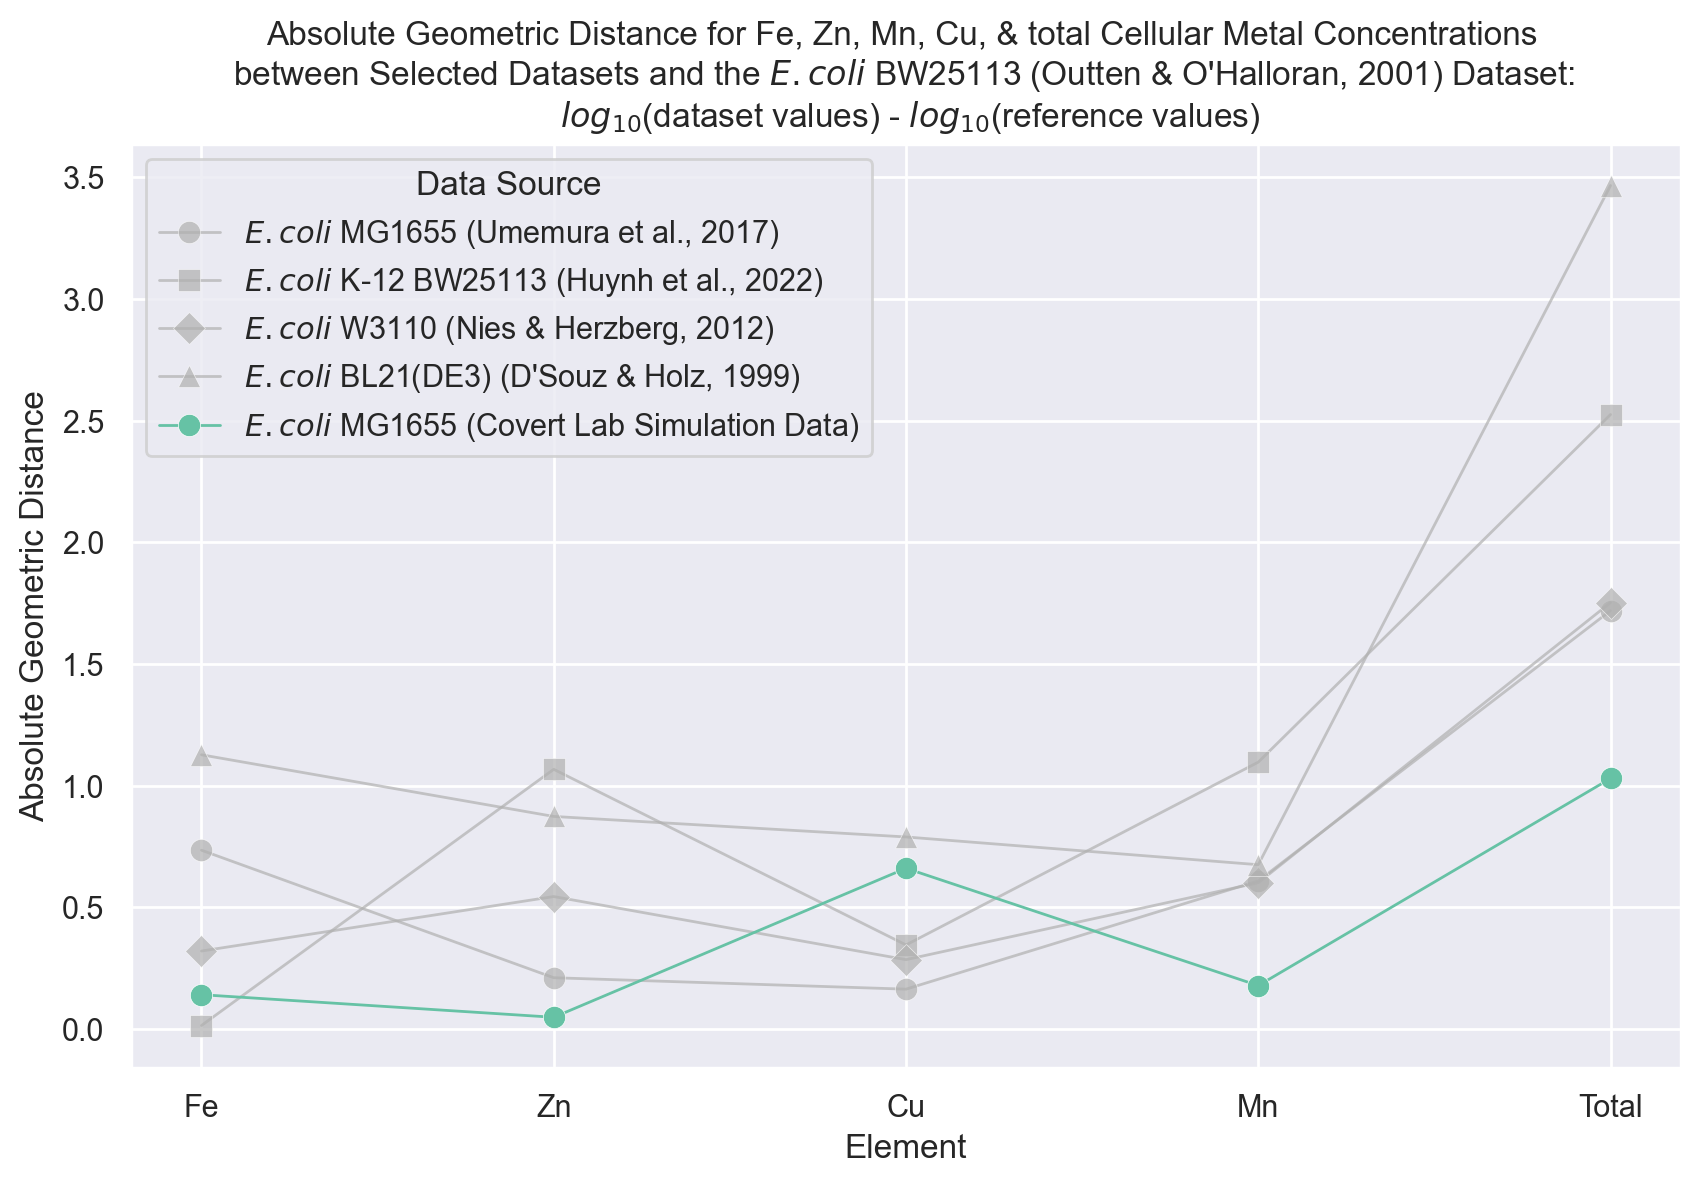

In [112]:
# plot the data with the total on a horizontal plot, with the elements on the x-axis and the datasources as different colors
plt.figure(dpi=200, figsize=(10, 6))
sns.set(style="darkgrid")

# rearrange the data to have the first data source as a separate data source:
GD_woCrCoVNiMo_with_total_sim_data = GD_woCrCoVNiMo_with_total["Element", "$\t{E. coli}$ MG1655 (Covert Lab Simulation Data)"]
GD_woCrCoVNiMo_with_total_exp_data = GD_woCrCoVNiMo_with_total[:,[0,2,3,4,5]] # subtract the last few data sources since they have the larger differences

# put the data in long form so that the data sources can be a separate variable: 
data_long_sim = GD_woCrCoVNiMo_with_total_sim_data.melt(id_vars="Element", variable_name="Data Source", value_name="Geometric Distance").to_pandas()
data_long_exp = GD_woCrCoVNiMo_with_total_exp_data.melt(id_vars="Element", variable_name="Data Source", value_name="Geometric Distance").to_pandas()

# assign colors and marker styles: 
custom_palette4 = (sns.color_palette("Set2")[0:1])
grey_palette3 = ["#B0B0B0"] * len(GD_woCrCoVNiMo_with_total_exp_data.columns)
marker_styles = ['o', 's', 'D', '^', 'v', 'P', 'X', 'p', '*', 'h', '+']  # Customize as needed

# plot the data: 
unique_sources = data_long_exp['Data Source'].unique()
for i, source in enumerate(unique_sources):
    subset = data_long[data_long['Data Source'] == source]
    color = grey_palette3[0]  # Grey color for other data sources
    alpha = 0.7  # Lower alpha for other data sources

    # Use the appropriate marker and alpha value for each dataset
    sns.lineplot(data=subset, x="Element", y="Geometric Distance", 
                label=source, marker=marker_styles[i % len(marker_styles)], 
                 color=color, markersize=8, linewidth=1, markeredgewidth=0.25, alpha=alpha)  

# plot the simulation data separately so it falls on top of the rest: 
sns.lineplot(data=data_long_sim, x="Element", y="Geometric Distance", hue="Data Source", palette=custom_palette4, linewidth=1, marker='o', markersize=8, markeredgewidth=0.25)

# Plot Specs:
plt.title("Absolute Geometric Distance for Fe, Zn, Mn, Cu, & total Cellular Metal Concentrations \nbetween Selected Datasets and the $\t{E. coli}$ BW25113 (Outten & O\'Halloran, 2001) Dataset: \n $log_{10}$(dataset values) - $log_{10}$(reference values)")
plt.xlabel("Element")
plt.ylabel("Absolute Geometric Distance")
plt.legend(title="Data Source")
plt.show()

# Style #5 (same as 4, but without extra legend entries)

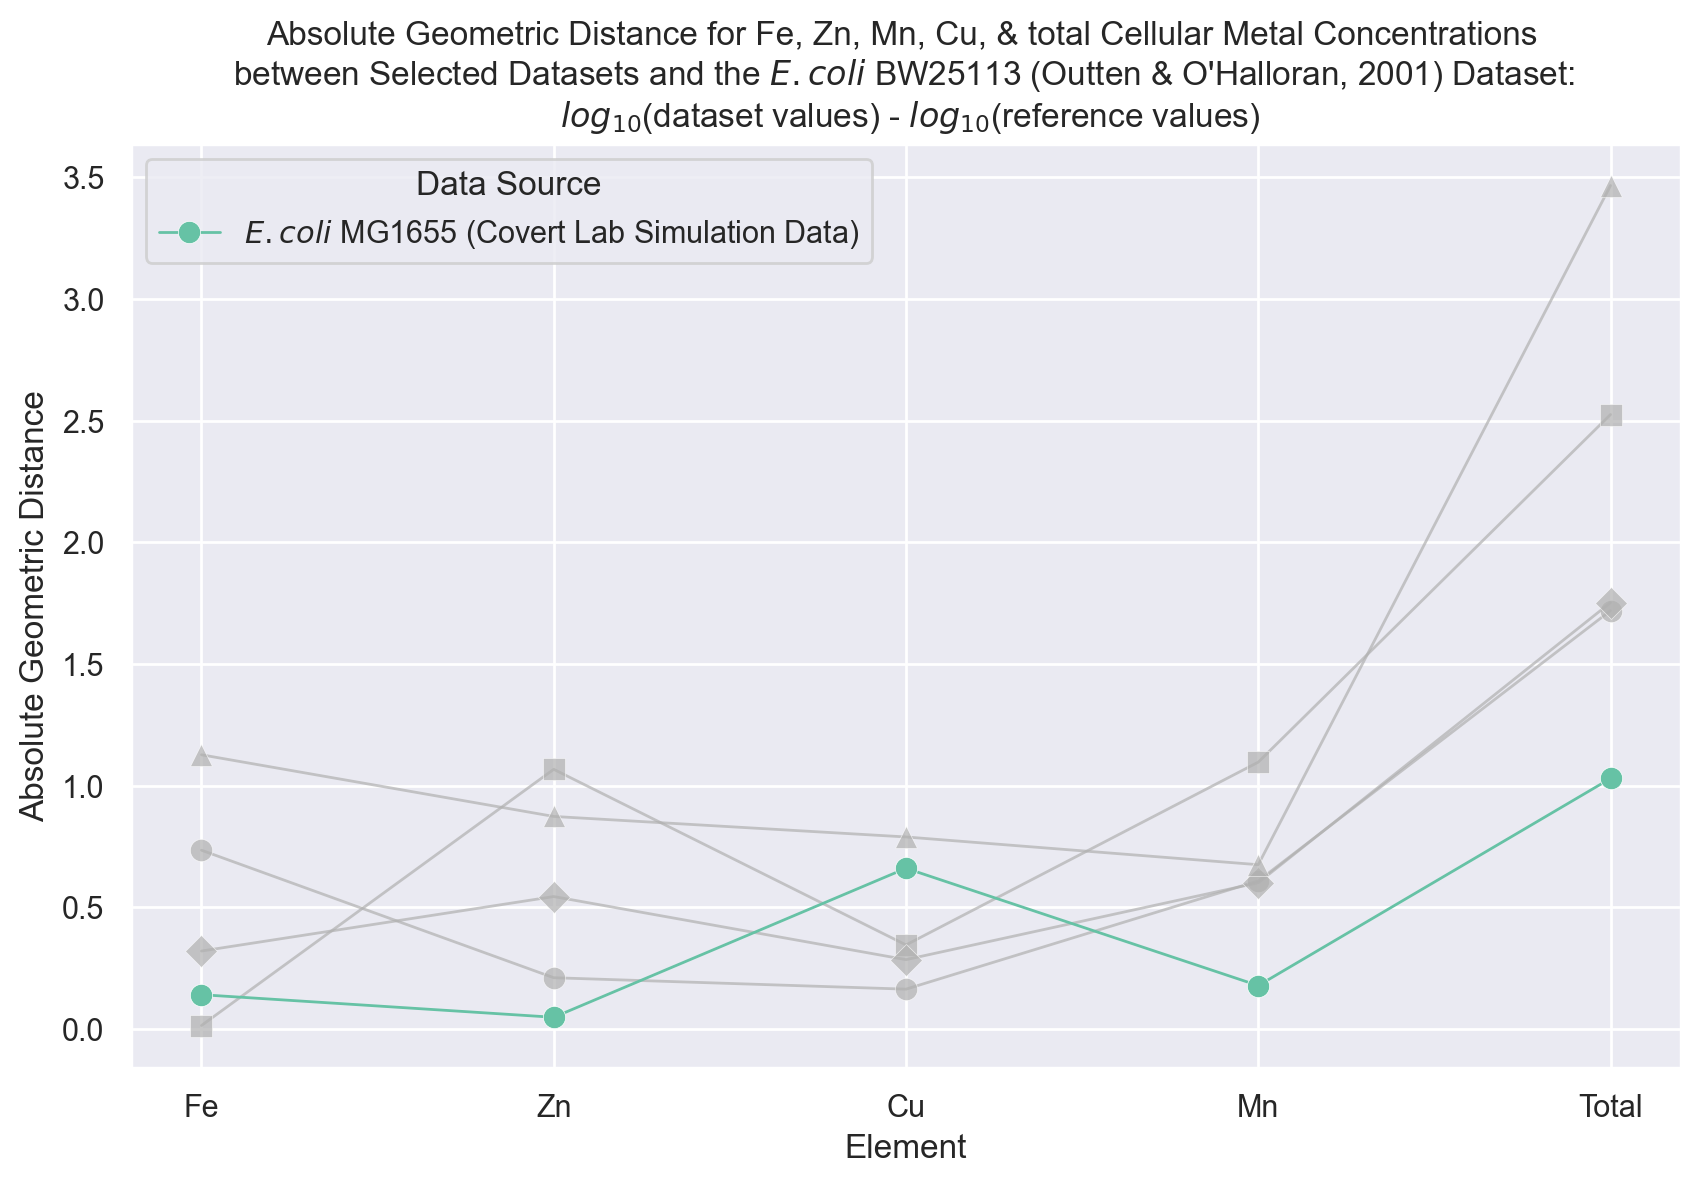

In [113]:
# plot the data with the total on a horizontal plot, with the elements on the x-axis and the datasources as different colors
plt.figure(dpi=200, figsize=(10, 6))
sns.set(style="darkgrid")

# rearrange the data to have the first data source as a separate data source:
GD_woCrCoVNiMo_with_total_sim_data = GD_woCrCoVNiMo_with_total["Element", "$\t{E. coli}$ MG1655 (Covert Lab Simulation Data)"]
GD_woCrCoVNiMo_with_total_exp_data = GD_woCrCoVNiMo_with_total[:,[0,2,3,4,5]] # subtract the last few data sources since they have the larger differences

# put the data in long form so that the data sources can be a separate variable: 
data_long_sim = GD_woCrCoVNiMo_with_total_sim_data.melt(id_vars="Element", variable_name="Data Source", value_name="Geometric Distance").to_pandas()
data_long_exp = GD_woCrCoVNiMo_with_total_exp_data.melt(id_vars="Element", variable_name="Data Source", value_name="Geometric Distance").to_pandas()

# assign colors and marker styles: 
custom_palette4 = (sns.color_palette("Set2")[0:1])
grey_palette3 = ["#B0B0B0"] * len(GD_woCrCoVNiMo_with_total_exp_data.columns)
marker_styles = ['o', 's', 'D', '^', 'v', 'P', 'X', 'p', '*', 'h', '+']  # Customize as needed

# plot the data: 
unique_sources = data_long_exp['Data Source'].unique()
for i, source in enumerate(unique_sources):
    subset = data_long[data_long['Data Source'] == source]
    color = grey_palette3[0]  # Grey color for other data sources
    alpha = 0.7  

    # Use the appropriate marker and alpha value for each dataset
    sns.lineplot(data=subset, x="Element", y="Geometric Distance", 
                 marker=marker_styles[i % len(marker_styles)], 
                 color=color, markersize=8, linewidth=1, markeredgewidth=0.25, alpha=alpha)  

# plot the simulation data separately so it falls on top of the rest: 
sns.lineplot(data=data_long_sim, x="Element", y="Geometric Distance", hue="Data Source", palette=custom_palette4, linewidth=1, marker='o', markersize=8, markeredgewidth=0.25)

# Plot Specs:
plt.title("Absolute Geometric Distance for Fe, Zn, Mn, Cu, & total Cellular Metal Concentrations \nbetween Selected Datasets and the $\t{E. coli}$ BW25113 (Outten & O\'Halloran, 2001) Dataset: \n $log_{10}$(dataset values) - $log_{10}$(reference values)")
plt.xlabel("Element")
plt.ylabel("Absolute Geometric Distance")
plt.legend(title="Data Source")
plt.show()

# Style #6 (same as 5, but with a different legend position)

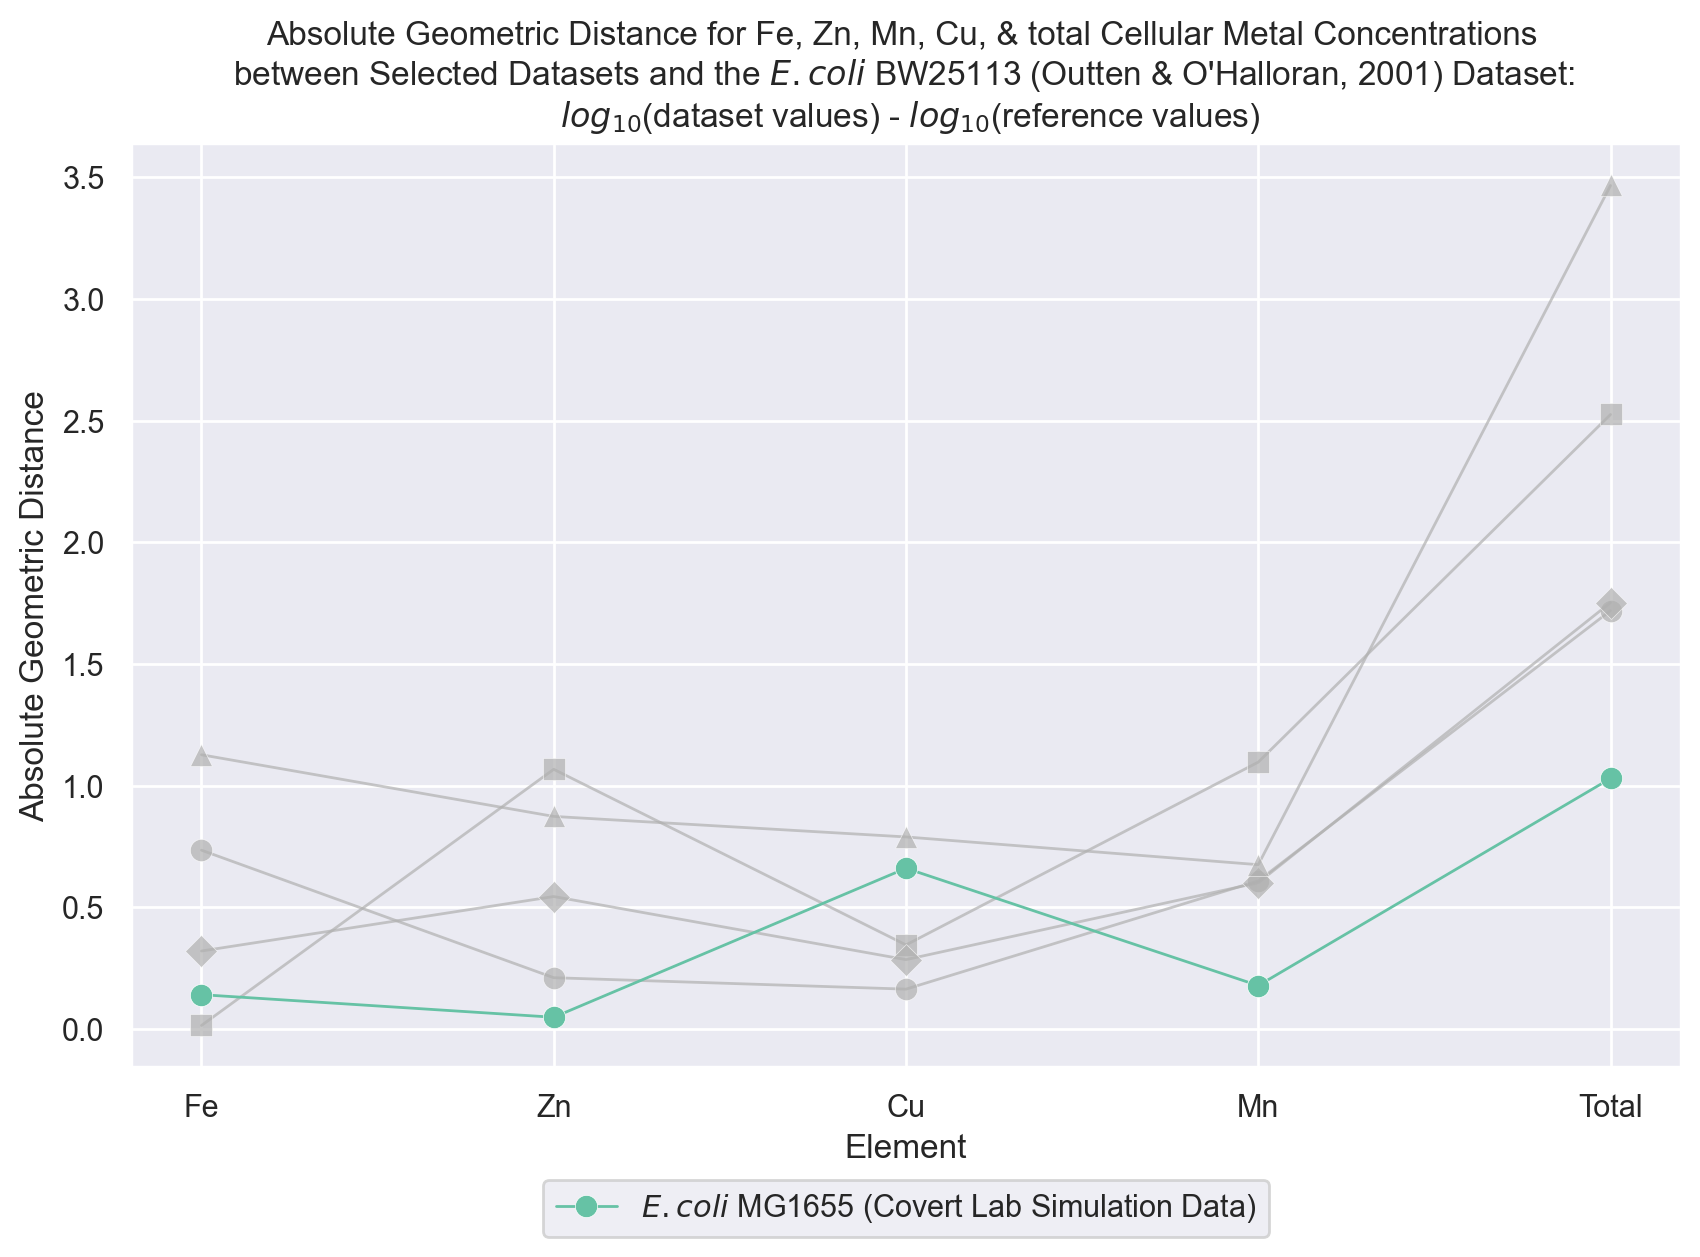

In [117]:
# plot the data with the total on a horizontal plot, with the elements on the x-axis and the datasources as different colors
plt.figure(dpi=200, figsize=(10, 6))
sns.set(style="darkgrid")

# rearrange the data to have the first data source as a separate data source:
GD_woCrCoVNiMo_with_total_sim_data = GD_woCrCoVNiMo_with_total["Element", "$\t{E. coli}$ MG1655 (Covert Lab Simulation Data)"]
GD_woCrCoVNiMo_with_total_exp_data = GD_woCrCoVNiMo_with_total[:,[0,2,3,4,5]] # subtract the last few data sources since they have the larger differences

# put the data in long form so that the data sources can be a separate variable: 
data_long_sim = GD_woCrCoVNiMo_with_total_sim_data.melt(id_vars="Element", variable_name="Data Source", value_name="Geometric Distance").to_pandas()
data_long_exp = GD_woCrCoVNiMo_with_total_exp_data.melt(id_vars="Element", variable_name="Data Source", value_name="Geometric Distance").to_pandas()

# assign colors and marker styles: 
custom_palette4 = (sns.color_palette("Set2")[0:1])
grey_palette3 = ["#B0B0B0"] * len(GD_woCrCoVNiMo_with_total_exp_data.columns)
marker_styles = ['o', 's', 'D', '^', 'v', 'P', 'X', 'p', '*', 'h', '+']  # Customize as needed

# plot the data: 
unique_sources = data_long_exp['Data Source'].unique()
for i, source in enumerate(unique_sources):
    subset = data_long[data_long['Data Source'] == source]
    color = grey_palette3[0]  # Grey color for other data sources
    alpha = 0.7  

    # Use the appropriate marker and alpha value for each dataset
    sns.lineplot(data=subset, x="Element", y="Geometric Distance", 
                 marker=marker_styles[i % len(marker_styles)], 
                 color=color, markersize=8, linewidth=1, markeredgewidth=0.25, alpha=alpha)  

# plot the simulation data separately so it falls on top of the rest: 
sns.lineplot(data=data_long_sim, x="Element", y="Geometric Distance", hue="Data Source", palette=custom_palette4, linewidth=1, marker='o', markersize=8, markeredgewidth=0.25)

# Plot Specs:
plt.title("Absolute Geometric Distance for Fe, Zn, Mn, Cu, & total Cellular Metal Concentrations \nbetween Selected Datasets and the $\t{E. coli}$ BW25113 (Outten & O\'Halloran, 2001) Dataset: \n $log_{10}$(dataset values) - $log_{10}$(reference values)")
plt.xlabel("Element")
plt.ylabel("Absolute Geometric Distance")
plt.legend()
sns.move_legend(plt.gca(), "lower center", bbox_to_anchor=(0.5, -0.2))

plt.show()

## Cyrus' 1st request for 10/23/2024: "For the raw data plot for the four elements, change the shapes of the points so each shape is a data set. Just so we can distinguish them."


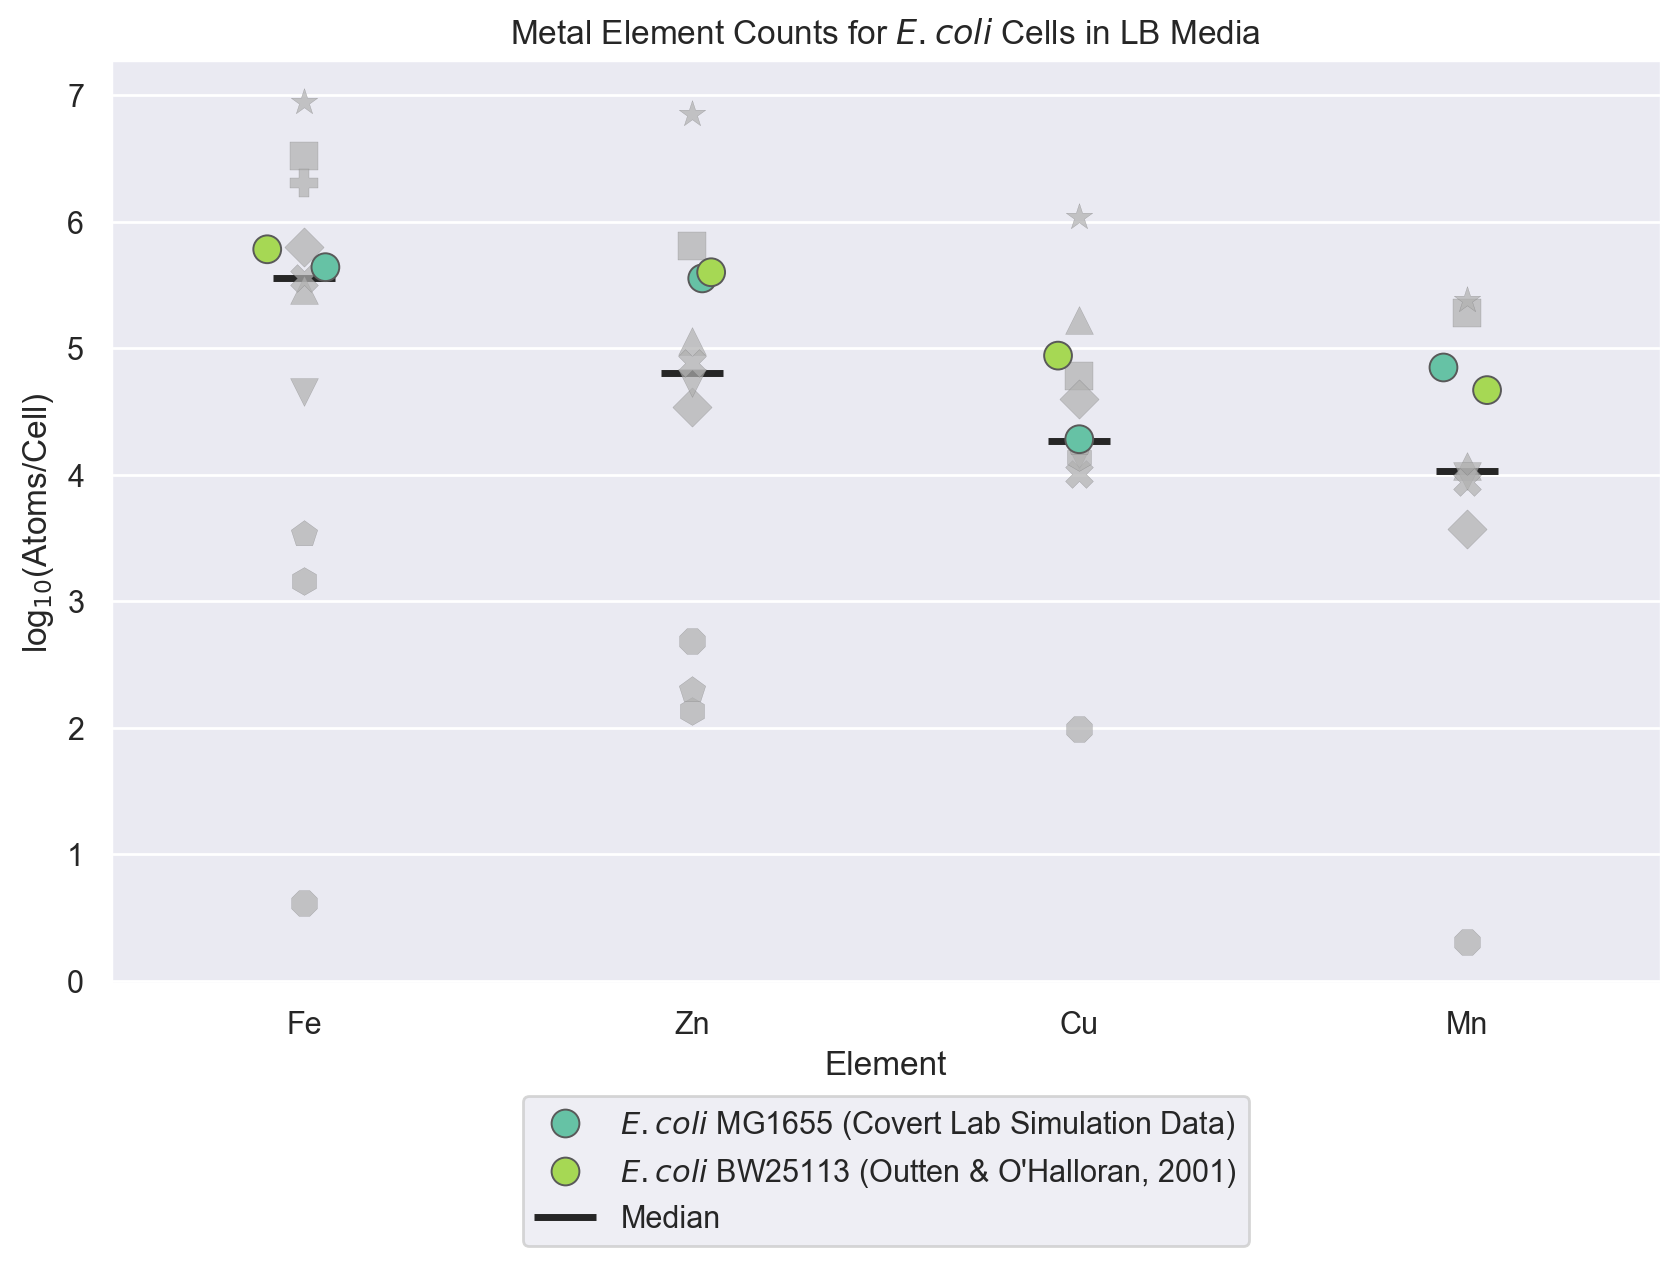

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Sample marker styles for different datasets
marker_styles = ['s', 'D', '^', 'v', 'P', 'X', '*', 'h', 'p', "8"]  # Customize as needed

# Plot setup
plt.figure(dpi=200, figsize=(10, 6))
custom_palette3 = (sns.color_palette("Set2")[0:1] + sns.color_palette("Set2")[4:5])
grey_palette3 = ["#B0B0B0"] * len(marker_styles)

# Set jitter seed for consistency
np.random.seed(10)

# Plot each grey dataset with a unique shape
for i, (data_source, marker) in enumerate(zip(exp_LB_data_woCrCoVNiMo_long_pd["Data Source"].unique(), marker_styles)):
    subset = exp_LB_data_woCrCoVNiMo_long_pd[exp_LB_data_woCrCoVNiMo_long_pd["Data Source"] == data_source]
    sns.stripplot(
        data=subset, y="log$_{10}$(Atoms/Cell)", x="Element", color=grey_palette3[i], marker=marker,
        s=10, linewidth=0.1, alpha=0.7, jitter=0.2, label=data_source)

# Plot the GT simulation data with custom colors
sns.stripplot(
    data=GT_sim_LB_data_woCrCoVNiMo_long_pd, y="log$_{10}$(Atoms/Cell)", x="Element",
    hue="Data Source", s=10, alpha=1, palette=custom_palette3, jitter=0.1, linewidth=0.7)

# Plot median markers for each element
sns.pointplot(
    data=long_medians_woCrCoVNiMo_pd, y="log$_{10}$(Atoms/Cell)", x="Element", hue="Data Source",
    linestyle="none", errorbar=None, marker="_", markersize=22, markeredgewidth=2.5, palette="dark:black")

# Plot title and legend customization
plt.title("Metal Element Counts for $\t{E. coli}$ Cells in LB Media")
handles, labels = plt.gca().get_legend_handles_labels()
included_labels = ["$\t{E. coli}$ MG1655 (Covert Lab Simulation Data)", "$\t{E. coli}$ BW25113 (Outten & O'Halloran, 2001)", "Median"]
included_handles = [handles[labels.index(label)] for label in included_labels]
plt.legend(included_handles, included_labels, loc="upper right")
sns.move_legend(plt.gca(), "lower center", bbox_to_anchor=(0.5, -0.3))

plt.show()
